# Assignement 2

This is your second assignement in the computer vision course. This time you are supposed to implement a system that outputs bounding boxes (bb) of pedestrians.

**Bounding box definition:** the smallest axis aligned rectangle containing all the pixels of the pedestrian

!!NO DEEP LEARNING APPROACHES ARE ALLOWED. You should use classic methods to address the assignment!!

Ouput format:
 - A list of [frame_id, bb_id, x, y, dx, dy]. See prenom_nom.py module for an example
 
Evaluation function:
 - Detections are converted into binary masks and we calculate the following metrics: intersecion over union. Note that this metric is not sensitive to the number of bb-s. You can find the code below for the evaluation.
 - The evaluation will be performed in an independent video sequence.
 
Scoring:
 - Your work will be evaluated as usual (complexity of the solution, clean implementation, well documented) **PLUS** the best 5 will receive +1 for the grade of the assignement.
 
You have to handle in:
 - Your code that is a single python module (possibly with requirements.txt or with a dockerfile). See the example prenom_nom.py. It has to implement the same interface, if it fails to run, your solution is considered failing.
 - Your report. Short summary of your algorithm, motivation for the algorithm used, failing cases, code and results (~1 page).
 
You should send your assignment by mail to maria.vakalopoulou@centralesupelec.fr, the name of the subject of the mail should be: VIC_Assignement2_name
 

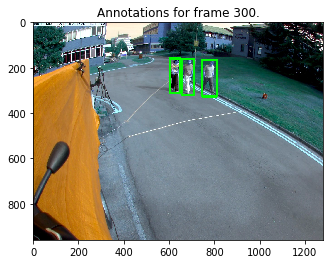

A perfect score... 1.0
A great score! 0.0008083067671351978


In [11]:
# Helpers functions
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import os
import numpy as np
import yourname
import tqdm


data_root = './img1/'
gt_path = './gt/gt.txt'

_W = 1280
_H = 960
_N = 684 # number of frames

def format_id(frame):
    """Add formatting to this id '1'--> '001'"""
    assert _N >= frame
    return '{:03d}'.format(frame)


def read_frame(root, frame):
    """Read frames and create integer frame_id-s"""
    assert _N >= frame
    return cv2.imread(os.path.join(root,format_id(frame)+'.jpg'), cv2.IMREAD_UNCHANGED)
    

def read_gt(filename):
    """Read gt and create list of bb-s"""
    """ Gt : Ground truth bounding boxes"""
    assert os.path.exists(filename)
    with open(filename, 'r') as file:
        lines = file.readlines()
    # truncate data (last columns are not needed)
    return [list(map(lambda x: int(x), line.split(',')[:6])) for line in lines]


def annotations_for_frame(solution, frame):
    assert _N >= frame
    return [bb for bb in solution if int(bb[0])==int(frame)]


def evaluate_solution(gt, solution, N):
    """Caclulate evaluation metric"""
    score = []
    #for frame in [300]:
    for frame in range(1, N):
        bbs_sol = annotations_for_frame(solution, frame)
        bbs_gt = annotations_for_frame(gt, frame)
        black_sol = np.zeros((_H, _W))
        black_gt = np.zeros((_H, _W))
        for bb in bbs_sol:
            x, y = bb[2:4]
            dx, dy = bb[4:6]
            cv2.rectangle(black_sol, (x, y), (x+dx, y+dy), (255), -1)
        for bb in bbs_gt:
            x, y = bb[2:4]
            dx, dy = bb[4:6]
            cv2.rectangle(black_gt, (x, y), (x+dx, y+dy), (255), -1)
        # intersection over union
        intersection = black_sol * black_gt
        intersection[intersection > 0.5] = 1
        union = black_sol + black_gt
        union[union > 0.5] = 1
        if not union.any():
            continue
        score.append(intersection.sum()/union.sum())    
    return np.asarray(score).mean()
    

def show_annotation(solution, frame):
    assert _N >= frame
    im = read_frame(data_root, frame)
    bbs = annotations_for_frame(solution, frame)
    for bb in bbs:
        x, y = bb[2:4]
        dx, dy = bb[4:6]
        cv2.rectangle(im, (x, y), (x+dx, y+dy), (0,255,0), 10)
    plt.imshow(im)
    plt.title('Annotations for frame {}.'.format(frame))
    plt.show()
    return

gt = read_gt(gt_path)

show_annotation(gt, 300)

print('A perfect score... {}'.format(evaluate_solution(gt, gt, _N)))

# your solution will be tested simply by changing the dataset
# and changing the module, i.e., the following has to work 
# with simply using your module 
sol = yourname.pedestrians(data_root, _W, _H, _N)
print('A great score! {}'.format(evaluate_solution(sol, gt, _N)))



***
# Solution starts here 
***

In [12]:
# In main
# Helpers functions

from matplotlib import pyplot as plt
import cv2
import os
import numpy as np
import yourname
import tqdm
from imutils.object_detection import non_max_suppression
from imutils import paths
import argparse
import imutils



data_root = './img1/'
gt_path = './gt/gt.txt'

_W = 1280
_H = 960
_N = 684 # number of frames


# args = frame_number
# algorithm_n : 1 or 2 
# NMS : True , False

def format_id(frame):
    """Add formatting to this id '1'--> '001'"""
    assert _N >= frame
    return '{:03d}'.format(frame)


def read_frame(root, frame):
    """Read frames and create integer frame_id-s"""
    assert _N >= frame
    return cv2.imread(os.path.join(root,format_id(frame)+'.jpg'), cv2.IMREAD_UNCHANGED)
    

def read_gt(filename):
    """Read gt and create list of bb-s"""
    """ Gt : Ground truth bounding boxes"""
    assert os.path.exists(filename)
    with open(filename, 'r') as file:
        lines = file.readlines()
    # truncate data (last columns are not needed)
    return [list(map(lambda x: int(x), line.split(',')[:6])) for line in lines]


def annotations_for_frame(solution, frame):
    assert _N >= frame
    return [bb for bb in solution if int(bb[0])==int(frame)]

def evaluate_solution(gt, solution, N):
    """Caclulate evaluation metric"""
    score = []
    #for frame in [300]:
    for frame in range(1, N):
        bbs_sol = annotations_for_frame(solution, frame)
        bbs_gt = annotations_for_frame(gt, frame)
        black_sol = np.zeros((_H, _W))
        black_gt = np.zeros((_H, _W))
        for bb in bbs_sol:
            x, y = bb[2:4]
            dx, dy = bb[4:6]
            cv2.rectangle(black_sol, (x, y), (x+dx, y+dy), (255), -1)
        for bb in bbs_gt:
            x, y = bb[2:4]
            dx, dy = bb[4:6]
            cv2.rectangle(black_gt, (x, y), (x+dx, y+dy), (255), -1)
        # intersection over union
        intersection = black_sol * black_gt
        intersection[intersection > 0.5] = 1
        union = black_sol + black_gt
        union[union > 0.5] = 1
        if not union.any():
            continue
        score.append(intersection.sum()/union.sum())    
    return np.asarray(score).mean()
    

def show_annotation(solution, frame):
    assert _N >= frame
    im = read_frame(data_root, frame)
    bbs = annotations_for_frame(solution, frame)
    for bb in bbs:
        x, y = bb[2:4]
        dx, dy = bb[4:6]
        cv2.rectangle(im, (x, y), (x+dx, y+dy), (0,255,0), 10)
    plt.imshow(im)
    plt.title('Annotations for frame {}.'.format(frame))
    plt.show()
    return

In [13]:
def read_show(imagePath):
    """
    This function reads and returns the frame_n and the image 
    ---
    input : imagePath ('./folder_name/frame_n.jpg')
    ---
    output : image and frame_n
    """
    frame_n = int(imagePath.split('/')[2].split('.jpg')[0])
    print('Processing image {} ...'.format(frame_n))
    image = cv2.imread(imagePath) 
    image = imutils.resize(image, width= image.shape[1]) 
    #plt.imshow(image)
    #plt.title('Original image {}'.format(frame_n))
    #plt.show()
    return image, frame_n
    
    

In [14]:
def pedestrian_detect1(imagePath,nms=True):
    """
    This fuction detects pedestrians based on HOG +SVM + OpenCV pedestrian detector 
   
        ---
    input : imagePath : ('./folder_name/frame_n.jpg') + Gray : use grascale
    ---
    output : Boundingbox [x,y,dx,dy]
    
    """
    image, frame_n= read_show(imagePath)
    img = image.copy()
    #1. Get the HOG SVM detector
    hog = cv2.HOGDescriptor()
    hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

    #2. detect people in the image using HOG
    (rect, weights) = hog.detectMultiScale(img, winStride=(4, 4),padding=(4, 4), scale=1.05)
    
    #3. apply non maximum supression or not 
    if nms:
        print('Using non-maximum supression')
        pick  = non_max_suppression(rect , probs=None, overlapThresh=0.2)
        print("[INFO] {}: {} original boxes, {} after suppression".format(frame_n, len(rect), len(pick)))
    else:
        print('NOT Using non-maximum supression')
        pick = rect.copy()
    
    
    #3. draw the original bounding boxes
    for (x,y,w,h) in pick:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),4)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(img, 'Pedestrian', (x + 6, y - 6), font, 1., (0, 255, 0), 3)
        #plt.imshow(img)
    #plt.title('After detection {}'.format(frame_n))
    #plt.show()
    return frame_n,pick 



In [15]:
def pedestrian_detect2(imagePath, nms,gray=False):
    """
    This fuction detects pedestrians based on a pretrained model that uses Haarcascade 
    ---
    input : imagePath : ('./folder_name/frame_n.jpg') + Gray : use grascale + nms: apply or not non-max-suppression
    ---
    output : Boundingbox [x,y,dx,dy]
    
    """
    image, frame_n= read_show(imagePath)
    
    img = image.copy()
    if gray :
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        plt.imshow(gray)
        plt.title('Original gray image {}'.format(frame_n))
        img = gray
        plt.show()
        
    #1. Import a pretrained classifier on another training set:
    #https://github.com/chandravenky/Computer-Vision---Object-Detection-in-Python/tree/master/xml%20files
    pedestrian_cascade = cv2.CascadeClassifier('./haarcascade_fullbody.xml')
    
    #2. Apply this classifier on the img
    pedestrians = pedestrian_cascade.detectMultiScale(img, scaleFactor = 1.05,minNeighbors = 3)
    
    #3. apply non maximum supression or not 
    if nms:
        print('Using non-maximum supression')
        pick  = non_max_suppression(pedestrians , probs=None, overlapThresh=0.2)
        print("[INFO] {}: {} original boxes, {} after suppression".format(frame_n, len(pedestrians), len(pick)))
    else:
        print('NOT Using non-maximum supression')
        pick = pedestrians.copy()
    
    #4. Draw bounding boxes
    for (x,y,w,h) in pick:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),4)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(img, 'Pedestrian', (x + 6, y - 6), font, 1., (0, 255, 0), 3)
        #plt.imshow(img)
    #plt.title('After detection {}'.format(frame_n))
    #plt.show()
    
    #5. Print results and outputs bboxes
    print('Number of detected boxes/pedestrians:', len(pick))
    return frame_n,pick    

In [16]:
def pedestrians_bb(frame_n,ped_bboxes):
    """
    Transform bboxes to this format [frame_n, bb_id,x,y,dx,dy]
    ---
    input: frame_n, ped_bboxes : pedestrian bounding boxes [x,y,dx,dy]
    ---
    output: reformatted bounding boxes [frame_n, bb_id,x,y,dx,dy]
    """
    n = len(ped_bboxes)
    output = []
    if n==0 : return []
    for i in range(n):
        x = [frame_n,i+1]+list(ped_bboxes[i])
        output.append(x)
    return output

In [17]:
def evaluate(frame_n,solution, gt):
    """
    Evaluate the result using intersection over union score
    ---
    input: frame_n : frame number , solution : reformated bounding boxes, gt: groud truth bounding boxes
    ---
    output : final score
    """
    bbs_sol = solution
    bbs_gt = annotations_for_frame(gt, frame_n)
    black_sol = np.zeros((_H, _W))
    black_gt = np.zeros((_H, _W))
    for bb in bbs_sol:
        x, y = bb[2:4]
        dx, dy = bb[4:6]
        cv2.rectangle(black_sol, (x, y), (x+dx, y+dy), (255), -1)
    for bb in bbs_gt:
        x, y = bb[2:4]
        dx, dy = bb[4:6]
        cv2.rectangle(black_gt, (x, y), (x+dx, y+dy), (255), -1)
    # intersection over union
    intersection = black_sol * black_gt
    intersection[intersection > 0.5] = 1
    union = black_sol + black_gt
    union[union > 0.5] = 1
    score=intersection.sum()/union.sum()  
    return score

In [18]:
def display_detectors_results(imagePath,detector,gt_path='./gt/gt.txt',nms=True):
    """
    This function displays the final result and gives 
    ---
    input: frame_n : frame number , solution : reformated bounding boxes, gt: groud truth bounding boxes
    ---
    output : final score for a single image
    """
    if detector ==1: 
        print('Activate First detctor: HOG +SVM + OpenCV pedestrian ...')
        frame_n,pedestrians = pedestrian_detect1(imagePath,nms)
        gt = read_gt(gt_path)
        solution = pedestrians_bb(frame_n,pedestrians)
        avg_iou_score = evaluate(frame_n,solution,gt)
        print('Frame n={}, Score = {:1.3%}'.format(frame_n,avg_iou_score))
    
        
    elif detector ==2:
        print('Activate Second detctor: pretrained model ...')
        frame_n,pedestrians = pedestrian_detect2(imagePath,nms,gray=False,)
        gt = read_gt(gt_path)
        solution = pedestrians_bb(frame_n,pedestrians)
        avg_iou_score = evaluate(frame_n,solution,gt)
        print('Frame n={}, Score = {:1.3%}'.format(frame_n,avg_iou_score))
    else: 
        print('Error ...')
    return solution
    

In [19]:
# In main
imagePath = data_root+'300.jpg'
bb = display_detectors_results(imagePath,detector=1,gt_path='./gt/gt.txt',nms=True)

Activate First detctor: HOG +SVM + OpenCV pedestrian ...
Processing image 300 ...
Using non-maximum supression
[INFO] 300: 4 original boxes, 4 after suppression
Frame n=300, Score = 43.330%


In [20]:
def evaluate_on_all_images(data_root,_N,detector):
    """
    This function evaluates both detectors onthe whole set of images
    --
    
    """
    gt = read_gt(gt_path)
    
    if detector ==1 :
        solutions =[]
        scores = []
        for i in tqdm.tqdm(range(_N)):
            imagePath = data_root+format_id(i+1)+'.jpg'
            print(imagePath)
            frame_n,pedestrians = pedestrian_detect1(imagePath,nms=True)
            solution = pedestrians_bb(frame_n,pedestrians)
            solutions.append(solution)
            score = evaluate(frame_n,solution,gt)
            scores.append(score)
            
    if detector ==2 :
        solutions =[]
        scores = []
        for i in tqdm.tqdm(range(_N)):
            imagePath = data_root+format_id(i+1)+'.jpg'
            print(imagePath)
            frame_n,pedestrians = pedestrian_detect2(imagePath,nms=True)
            solution = pedestrians_bb(frame_n,pedestrians)
            solutions.append(solution)
            score = evaluate(frame_n,solution,gt)
            scores.append(score)
    return scores, solutions

        
        
        
        
    

In [21]:
# First detector
scores1, solutions = evaluate_on_all_images(data_root,_N,detector=1)

  0%|          | 0/684 [00:00<?, ?it/s]

./img1/001.jpg
Processing image 1 ...


  0%|          | 1/684 [00:03<41:54,  3.68s/it]

Using non-maximum supression
[INFO] 1: 3 original boxes, 3 after suppression
./img1/002.jpg
Processing image 2 ...


  0%|          | 2/684 [00:06<40:19,  3.55s/it]

Using non-maximum supression
[INFO] 2: 4 original boxes, 4 after suppression
./img1/003.jpg
Processing image 3 ...


  0%|          | 3/684 [00:10<40:07,  3.54s/it]

Using non-maximum supression
[INFO] 3: 3 original boxes, 3 after suppression
./img1/004.jpg
Processing image 4 ...


  1%|          | 4/684 [00:13<40:05,  3.54s/it]

Using non-maximum supression
[INFO] 4: 3 original boxes, 3 after suppression
./img1/005.jpg
Processing image 5 ...


  1%|          | 5/684 [00:17<40:23,  3.57s/it]

Using non-maximum supression
[INFO] 5: 4 original boxes, 4 after suppression
./img1/006.jpg
Processing image 6 ...


  1%|          | 6/684 [00:21<41:40,  3.69s/it]

Using non-maximum supression
[INFO] 6: 3 original boxes, 3 after suppression
./img1/007.jpg
Processing image 7 ...


  1%|          | 7/684 [00:25<40:52,  3.62s/it]

Using non-maximum supression
[INFO] 7: 3 original boxes, 3 after suppression
./img1/008.jpg
Processing image 8 ...


  1%|          | 8/684 [00:28<41:27,  3.68s/it]

Using non-maximum supression
[INFO] 8: 4 original boxes, 4 after suppression
./img1/009.jpg
Processing image 9 ...


  1%|▏         | 9/684 [00:32<42:52,  3.81s/it]

Using non-maximum supression
[INFO] 9: 3 original boxes, 3 after suppression
./img1/010.jpg
Processing image 10 ...


  1%|▏         | 10/684 [00:36<41:15,  3.67s/it]

Using non-maximum supression
[INFO] 10: 3 original boxes, 3 after suppression
./img1/011.jpg
Processing image 11 ...


  2%|▏         | 11/684 [00:39<39:48,  3.55s/it]

Using non-maximum supression
[INFO] 11: 3 original boxes, 3 after suppression
./img1/012.jpg
Processing image 12 ...


  2%|▏         | 12/684 [00:43<41:27,  3.70s/it]

Using non-maximum supression
[INFO] 12: 5 original boxes, 5 after suppression
./img1/013.jpg
Processing image 13 ...


  2%|▏         | 13/684 [00:46<39:12,  3.51s/it]

Using non-maximum supression
[INFO] 13: 3 original boxes, 3 after suppression
./img1/014.jpg
Processing image 14 ...


  2%|▏         | 14/684 [00:50<39:25,  3.53s/it]

Using non-maximum supression
[INFO] 14: 3 original boxes, 3 after suppression
./img1/015.jpg
Processing image 15 ...


  2%|▏         | 15/684 [00:53<38:58,  3.49s/it]

Using non-maximum supression
[INFO] 15: 4 original boxes, 4 after suppression
./img1/016.jpg
Processing image 16 ...


  2%|▏         | 16/684 [00:56<38:11,  3.43s/it]

Using non-maximum supression
[INFO] 16: 3 original boxes, 3 after suppression
./img1/017.jpg
Processing image 17 ...


  2%|▏         | 17/684 [01:00<39:57,  3.59s/it]

Using non-maximum supression
[INFO] 17: 3 original boxes, 3 after suppression
./img1/018.jpg
Processing image 18 ...


  3%|▎         | 18/684 [01:04<41:03,  3.70s/it]

Using non-maximum supression
[INFO] 18: 2 original boxes, 2 after suppression
./img1/019.jpg
Processing image 19 ...


  3%|▎         | 19/684 [01:09<42:46,  3.86s/it]

Using non-maximum supression
[INFO] 19: 3 original boxes, 3 after suppression
./img1/020.jpg
Processing image 20 ...


  3%|▎         | 20/684 [01:13<43:23,  3.92s/it]

Using non-maximum supression
[INFO] 20: 2 original boxes, 2 after suppression
./img1/021.jpg
Processing image 21 ...


  3%|▎         | 21/684 [01:17<43:56,  3.98s/it]

Using non-maximum supression
[INFO] 21: 3 original boxes, 3 after suppression
./img1/022.jpg
Processing image 22 ...


  3%|▎         | 22/684 [01:20<41:42,  3.78s/it]

Using non-maximum supression
[INFO] 22: 3 original boxes, 3 after suppression
./img1/023.jpg
Processing image 23 ...


  3%|▎         | 23/684 [01:24<43:18,  3.93s/it]

Using non-maximum supression
[INFO] 23: 3 original boxes, 3 after suppression
./img1/024.jpg
Processing image 24 ...


  4%|▎         | 24/684 [01:28<41:33,  3.78s/it]

Using non-maximum supression
[INFO] 24: 2 original boxes, 2 after suppression
./img1/025.jpg
Processing image 25 ...


  4%|▎         | 25/684 [01:31<40:09,  3.66s/it]

Using non-maximum supression
[INFO] 25: 3 original boxes, 3 after suppression
./img1/026.jpg
Processing image 26 ...


  4%|▍         | 26/684 [01:35<41:52,  3.82s/it]

Using non-maximum supression
[INFO] 26: 3 original boxes, 3 after suppression
./img1/027.jpg
Processing image 27 ...


  4%|▍         | 27/684 [01:39<41:23,  3.78s/it]

Using non-maximum supression
[INFO] 27: 3 original boxes, 3 after suppression
./img1/028.jpg
Processing image 28 ...


  4%|▍         | 28/684 [01:43<41:11,  3.77s/it]

Using non-maximum supression
[INFO] 28: 3 original boxes, 3 after suppression
./img1/029.jpg
Processing image 29 ...


  4%|▍         | 29/684 [01:47<43:02,  3.94s/it]

Using non-maximum supression
[INFO] 29: 3 original boxes, 3 after suppression
./img1/030.jpg
Processing image 30 ...


  4%|▍         | 30/684 [01:50<40:55,  3.75s/it]

Using non-maximum supression
[INFO] 30: 3 original boxes, 3 after suppression
./img1/031.jpg
Processing image 31 ...


  5%|▍         | 31/684 [01:54<40:08,  3.69s/it]

Using non-maximum supression
[INFO] 31: 4 original boxes, 4 after suppression
./img1/032.jpg
Processing image 32 ...


  5%|▍         | 32/684 [01:58<40:05,  3.69s/it]

Using non-maximum supression
[INFO] 32: 3 original boxes, 3 after suppression
./img1/033.jpg
Processing image 33 ...


  5%|▍         | 33/684 [02:01<38:15,  3.53s/it]

Using non-maximum supression
[INFO] 33: 3 original boxes, 3 after suppression
./img1/034.jpg
Processing image 34 ...


  5%|▍         | 34/684 [02:04<36:34,  3.38s/it]

Using non-maximum supression
[INFO] 34: 3 original boxes, 3 after suppression
./img1/035.jpg
Processing image 35 ...


  5%|▌         | 35/684 [02:08<38:50,  3.59s/it]

Using non-maximum supression
[INFO] 35: 4 original boxes, 4 after suppression
./img1/036.jpg
Processing image 36 ...


  5%|▌         | 36/684 [02:12<38:38,  3.58s/it]

Using non-maximum supression
[INFO] 36: 3 original boxes, 3 after suppression
./img1/037.jpg
Processing image 37 ...


  5%|▌         | 37/684 [02:16<40:34,  3.76s/it]

Using non-maximum supression
[INFO] 37: 4 original boxes, 4 after suppression
./img1/038.jpg
Processing image 38 ...


  6%|▌         | 38/684 [02:20<42:38,  3.96s/it]

Using non-maximum supression
[INFO] 38: 3 original boxes, 3 after suppression
./img1/039.jpg
Processing image 39 ...


  6%|▌         | 39/684 [02:23<40:16,  3.75s/it]

Using non-maximum supression
[INFO] 39: 3 original boxes, 3 after suppression
./img1/040.jpg
Processing image 40 ...


  6%|▌         | 40/684 [02:27<38:59,  3.63s/it]

Using non-maximum supression
[INFO] 40: 4 original boxes, 4 after suppression
./img1/041.jpg
Processing image 41 ...


  6%|▌         | 41/684 [02:30<38:01,  3.55s/it]

Using non-maximum supression
[INFO] 41: 4 original boxes, 4 after suppression
./img1/042.jpg
Processing image 42 ...


  6%|▌         | 42/684 [02:33<36:16,  3.39s/it]

Using non-maximum supression
[INFO] 42: 4 original boxes, 4 after suppression
./img1/043.jpg
Processing image 43 ...


  6%|▋         | 43/684 [02:36<35:32,  3.33s/it]

Using non-maximum supression
[INFO] 43: 3 original boxes, 3 after suppression
./img1/044.jpg
Processing image 44 ...


  6%|▋         | 44/684 [02:40<35:44,  3.35s/it]

Using non-maximum supression
[INFO] 44: 3 original boxes, 3 after suppression
./img1/045.jpg
Processing image 45 ...


  7%|▋         | 45/684 [02:43<34:23,  3.23s/it]

Using non-maximum supression
[INFO] 45: 4 original boxes, 4 after suppression
./img1/046.jpg
Processing image 46 ...


  7%|▋         | 46/684 [02:46<34:02,  3.20s/it]

Using non-maximum supression
[INFO] 46: 4 original boxes, 4 after suppression
./img1/047.jpg
Processing image 47 ...


  7%|▋         | 47/684 [02:49<34:05,  3.21s/it]

Using non-maximum supression
[INFO] 47: 3 original boxes, 3 after suppression
./img1/048.jpg
Processing image 48 ...


  7%|▋         | 48/684 [02:53<35:07,  3.31s/it]

Using non-maximum supression
[INFO] 48: 3 original boxes, 3 after suppression
./img1/049.jpg
Processing image 49 ...


  7%|▋         | 49/684 [02:56<36:05,  3.41s/it]

Using non-maximum supression
[INFO] 49: 3 original boxes, 3 after suppression
./img1/050.jpg
Processing image 50 ...


  7%|▋         | 50/684 [02:59<34:18,  3.25s/it]

Using non-maximum supression
[INFO] 50: 3 original boxes, 3 after suppression
./img1/051.jpg
Processing image 51 ...


  7%|▋         | 51/684 [03:02<33:36,  3.19s/it]

Using non-maximum supression
[INFO] 51: 3 original boxes, 3 after suppression
./img1/052.jpg
Processing image 52 ...


  8%|▊         | 52/684 [03:06<34:55,  3.32s/it]

Using non-maximum supression
[INFO] 52: 3 original boxes, 3 after suppression
./img1/053.jpg
Processing image 53 ...


  8%|▊         | 53/684 [03:09<33:47,  3.21s/it]

Using non-maximum supression
[INFO] 53: 3 original boxes, 3 after suppression
./img1/054.jpg
Processing image 54 ...


  8%|▊         | 54/684 [03:12<32:57,  3.14s/it]

Using non-maximum supression
[INFO] 54: 3 original boxes, 3 after suppression
./img1/055.jpg
Processing image 55 ...


  8%|▊         | 55/684 [03:15<33:55,  3.24s/it]

Using non-maximum supression
[INFO] 55: 3 original boxes, 3 after suppression
./img1/056.jpg
Processing image 56 ...


  8%|▊         | 56/684 [03:18<32:39,  3.12s/it]

Using non-maximum supression
[INFO] 56: 3 original boxes, 3 after suppression
./img1/057.jpg
Processing image 57 ...


  8%|▊         | 57/684 [03:21<33:06,  3.17s/it]

Using non-maximum supression
[INFO] 57: 3 original boxes, 3 after suppression
./img1/058.jpg
Processing image 58 ...


  8%|▊         | 58/684 [03:23<29:00,  2.78s/it]

Using non-maximum supression
[INFO] 58: 3 original boxes, 3 after suppression
./img1/059.jpg
Processing image 59 ...


  9%|▊         | 59/684 [03:26<28:41,  2.75s/it]

Using non-maximum supression
[INFO] 59: 3 original boxes, 3 after suppression
./img1/060.jpg
Processing image 60 ...


  9%|▉         | 60/684 [03:28<25:48,  2.48s/it]

Using non-maximum supression
[INFO] 60: 3 original boxes, 3 after suppression
./img1/061.jpg
Processing image 61 ...


  9%|▉         | 61/684 [03:30<23:44,  2.29s/it]

Using non-maximum supression
[INFO] 61: 3 original boxes, 3 after suppression
./img1/062.jpg
Processing image 62 ...


  9%|▉         | 62/684 [03:31<22:18,  2.15s/it]

Using non-maximum supression
[INFO] 62: 3 original boxes, 3 after suppression
./img1/063.jpg
Processing image 63 ...


  9%|▉         | 63/684 [03:33<21:15,  2.05s/it]

Using non-maximum supression
[INFO] 63: 3 original boxes, 3 after suppression
./img1/064.jpg
Processing image 64 ...


  9%|▉         | 64/684 [03:35<20:34,  1.99s/it]

Using non-maximum supression
[INFO] 64: 3 original boxes, 3 after suppression
./img1/065.jpg
Processing image 65 ...


 10%|▉         | 65/684 [03:37<20:07,  1.95s/it]

Using non-maximum supression
[INFO] 65: 3 original boxes, 3 after suppression
./img1/066.jpg
Processing image 66 ...


 10%|▉         | 66/684 [03:39<19:45,  1.92s/it]

Using non-maximum supression
[INFO] 66: 3 original boxes, 3 after suppression
./img1/067.jpg
Processing image 67 ...


 10%|▉         | 67/684 [03:41<19:27,  1.89s/it]

Using non-maximum supression
[INFO] 67: 3 original boxes, 3 after suppression
./img1/068.jpg
Processing image 68 ...


 10%|▉         | 68/684 [03:42<19:13,  1.87s/it]

Using non-maximum supression
[INFO] 68: 3 original boxes, 3 after suppression
./img1/069.jpg
Processing image 69 ...


 10%|█         | 69/684 [03:44<19:03,  1.86s/it]

Using non-maximum supression
[INFO] 69: 3 original boxes, 3 after suppression
./img1/070.jpg
Processing image 70 ...


 10%|█         | 70/684 [03:46<18:55,  1.85s/it]

Using non-maximum supression
[INFO] 70: 3 original boxes, 3 after suppression
./img1/071.jpg
Processing image 71 ...


 10%|█         | 71/684 [03:48<18:52,  1.85s/it]

Using non-maximum supression
[INFO] 71: 4 original boxes, 4 after suppression
./img1/072.jpg
Processing image 72 ...


 11%|█         | 72/684 [03:50<18:52,  1.85s/it]

Using non-maximum supression
[INFO] 72: 3 original boxes, 3 after suppression
./img1/073.jpg
Processing image 73 ...


 11%|█         | 73/684 [03:52<18:45,  1.84s/it]

Using non-maximum supression
[INFO] 73: 3 original boxes, 3 after suppression
./img1/074.jpg
Processing image 74 ...


 11%|█         | 74/684 [03:54<19:27,  1.91s/it]

Using non-maximum supression
[INFO] 74: 3 original boxes, 3 after suppression
./img1/075.jpg
Processing image 75 ...


 11%|█         | 75/684 [03:56<21:04,  2.08s/it]

Using non-maximum supression
[INFO] 75: 2 original boxes, 2 after suppression
./img1/076.jpg
Processing image 76 ...


 11%|█         | 76/684 [03:59<23:25,  2.31s/it]

Using non-maximum supression
[INFO] 76: 2 original boxes, 2 after suppression
./img1/077.jpg
Processing image 77 ...


 11%|█▏        | 77/684 [04:01<22:01,  2.18s/it]

Using non-maximum supression
[INFO] 77: 2 original boxes, 2 after suppression
./img1/078.jpg
Processing image 78 ...


 11%|█▏        | 78/684 [04:03<20:57,  2.07s/it]

Using non-maximum supression
[INFO] 78: 2 original boxes, 2 after suppression
./img1/079.jpg
Processing image 79 ...


 12%|█▏        | 79/684 [04:05<20:12,  2.00s/it]

Using non-maximum supression
[INFO] 79: 4 original boxes, 4 after suppression
./img1/080.jpg
Processing image 80 ...


 12%|█▏        | 80/684 [04:06<19:39,  1.95s/it]

Using non-maximum supression
[INFO] 80: 3 original boxes, 3 after suppression
./img1/081.jpg
Processing image 81 ...


 12%|█▏        | 81/684 [04:08<19:16,  1.92s/it]

Using non-maximum supression
[INFO] 81: 3 original boxes, 3 after suppression
./img1/082.jpg
Processing image 82 ...


 12%|█▏        | 82/684 [04:10<19:02,  1.90s/it]

Using non-maximum supression
[INFO] 82: 5 original boxes, 5 after suppression
./img1/083.jpg
Processing image 83 ...


 12%|█▏        | 83/684 [04:12<18:50,  1.88s/it]

Using non-maximum supression
[INFO] 83: 3 original boxes, 3 after suppression
./img1/084.jpg
Processing image 84 ...


 12%|█▏        | 84/684 [04:14<18:39,  1.87s/it]

Using non-maximum supression
[INFO] 84: 3 original boxes, 3 after suppression
./img1/085.jpg
Processing image 85 ...


 12%|█▏        | 85/684 [04:16<18:33,  1.86s/it]

Using non-maximum supression
[INFO] 85: 3 original boxes, 3 after suppression
./img1/086.jpg
Processing image 86 ...


 13%|█▎        | 86/684 [04:17<18:30,  1.86s/it]

Using non-maximum supression
[INFO] 86: 3 original boxes, 3 after suppression
./img1/087.jpg
Processing image 87 ...


 13%|█▎        | 87/684 [04:19<18:24,  1.85s/it]

Using non-maximum supression
[INFO] 87: 3 original boxes, 3 after suppression
./img1/088.jpg
Processing image 88 ...


 13%|█▎        | 88/684 [04:21<18:21,  1.85s/it]

Using non-maximum supression
[INFO] 88: 3 original boxes, 3 after suppression
./img1/089.jpg
Processing image 89 ...


 13%|█▎        | 89/684 [04:23<18:19,  1.85s/it]

Using non-maximum supression
[INFO] 89: 3 original boxes, 3 after suppression
./img1/090.jpg
Processing image 90 ...


 13%|█▎        | 90/684 [04:25<18:16,  1.85s/it]

Using non-maximum supression
[INFO] 90: 2 original boxes, 2 after suppression
./img1/091.jpg
Processing image 91 ...


 13%|█▎        | 91/684 [04:27<18:12,  1.84s/it]

Using non-maximum supression
[INFO] 91: 2 original boxes, 2 after suppression
./img1/092.jpg
Processing image 92 ...


 13%|█▎        | 92/684 [04:28<18:08,  1.84s/it]

Using non-maximum supression
[INFO] 92: 3 original boxes, 3 after suppression
./img1/093.jpg
Processing image 93 ...


 14%|█▎        | 93/684 [04:31<19:53,  2.02s/it]

Using non-maximum supression
[INFO] 93: 3 original boxes, 3 after suppression
./img1/094.jpg
Processing image 94 ...


 14%|█▎        | 94/684 [04:33<21:29,  2.19s/it]

Using non-maximum supression
[INFO] 94: 3 original boxes, 3 after suppression
./img1/095.jpg
Processing image 95 ...


 14%|█▍        | 95/684 [04:36<21:39,  2.21s/it]

Using non-maximum supression
[INFO] 95: 2 original boxes, 2 after suppression
./img1/096.jpg
Processing image 96 ...


 14%|█▍        | 96/684 [04:38<21:24,  2.18s/it]

Using non-maximum supression
[INFO] 96: 3 original boxes, 3 after suppression
./img1/097.jpg
Processing image 97 ...


 14%|█▍        | 97/684 [04:40<22:14,  2.27s/it]

Using non-maximum supression
[INFO] 97: 2 original boxes, 2 after suppression
./img1/098.jpg
Processing image 98 ...


 14%|█▍        | 98/684 [04:43<22:21,  2.29s/it]

Using non-maximum supression
[INFO] 98: 2 original boxes, 2 after suppression
./img1/099.jpg
Processing image 99 ...


 14%|█▍        | 99/684 [04:45<22:09,  2.27s/it]

Using non-maximum supression
[INFO] 99: 2 original boxes, 2 after suppression
./img1/100.jpg
Processing image 100 ...


 15%|█▍        | 100/684 [04:47<22:04,  2.27s/it]

Using non-maximum supression
[INFO] 100: 2 original boxes, 2 after suppression
./img1/101.jpg
Processing image 101 ...


 15%|█▍        | 101/684 [04:49<22:03,  2.27s/it]

Using non-maximum supression
[INFO] 101: 3 original boxes, 3 after suppression
./img1/102.jpg
Processing image 102 ...


 15%|█▍        | 102/684 [04:52<22:03,  2.27s/it]

Using non-maximum supression
[INFO] 102: 3 original boxes, 3 after suppression
./img1/103.jpg
Processing image 103 ...


 15%|█▌        | 103/684 [04:54<21:40,  2.24s/it]

Using non-maximum supression
[INFO] 103: 3 original boxes, 3 after suppression
./img1/104.jpg
Processing image 104 ...


 15%|█▌        | 104/684 [04:56<22:39,  2.34s/it]

Using non-maximum supression
[INFO] 104: 4 original boxes, 4 after suppression
./img1/105.jpg
Processing image 105 ...


 15%|█▌        | 105/684 [04:59<22:41,  2.35s/it]

Using non-maximum supression
[INFO] 105: 3 original boxes, 3 after suppression
./img1/106.jpg
Processing image 106 ...


 15%|█▌        | 106/684 [05:01<21:50,  2.27s/it]

Using non-maximum supression
[INFO] 106: 3 original boxes, 3 after suppression
./img1/107.jpg
Processing image 107 ...


 16%|█▌        | 107/684 [05:03<21:16,  2.21s/it]

Using non-maximum supression
[INFO] 107: 2 original boxes, 2 after suppression
./img1/108.jpg
Processing image 108 ...


 16%|█▌        | 108/684 [05:06<23:12,  2.42s/it]

Using non-maximum supression
[INFO] 108: 3 original boxes, 3 after suppression
./img1/109.jpg
Processing image 109 ...


 16%|█▌        | 109/684 [05:09<24:01,  2.51s/it]

Using non-maximum supression
[INFO] 109: 3 original boxes, 3 after suppression
./img1/110.jpg
Processing image 110 ...


 16%|█▌        | 110/684 [05:11<23:19,  2.44s/it]

Using non-maximum supression
[INFO] 110: 4 original boxes, 4 after suppression
./img1/111.jpg
Processing image 111 ...


 16%|█▌        | 111/684 [05:13<22:39,  2.37s/it]

Using non-maximum supression
[INFO] 111: 4 original boxes, 4 after suppression
./img1/112.jpg
Processing image 112 ...


 16%|█▋        | 112/684 [05:15<21:54,  2.30s/it]

Using non-maximum supression
[INFO] 112: 1 original boxes, 1 after suppression
./img1/113.jpg
Processing image 113 ...


 17%|█▋        | 113/684 [05:18<22:31,  2.37s/it]

Using non-maximum supression
[INFO] 113: 3 original boxes, 3 after suppression
./img1/114.jpg
Processing image 114 ...


 17%|█▋        | 114/684 [05:20<23:24,  2.46s/it]

Using non-maximum supression
[INFO] 114: 3 original boxes, 3 after suppression
./img1/115.jpg
Processing image 115 ...


 17%|█▋        | 115/684 [05:23<22:53,  2.41s/it]

Using non-maximum supression
[INFO] 115: 2 original boxes, 2 after suppression
./img1/116.jpg
Processing image 116 ...


 17%|█▋        | 116/684 [05:25<21:54,  2.31s/it]

Using non-maximum supression
[INFO] 116: 3 original boxes, 3 after suppression
./img1/117.jpg
Processing image 117 ...


 17%|█▋        | 117/684 [05:27<21:57,  2.32s/it]

Using non-maximum supression
[INFO] 117: 4 original boxes, 4 after suppression
./img1/118.jpg
Processing image 118 ...


 17%|█▋        | 118/684 [05:29<21:33,  2.29s/it]

Using non-maximum supression
[INFO] 118: 1 original boxes, 1 after suppression
./img1/119.jpg
Processing image 119 ...


 17%|█▋        | 119/684 [05:32<22:01,  2.34s/it]

Using non-maximum supression
[INFO] 119: 4 original boxes, 4 after suppression
./img1/120.jpg
Processing image 120 ...


 18%|█▊        | 120/684 [05:34<21:45,  2.31s/it]

Using non-maximum supression
[INFO] 120: 5 original boxes, 5 after suppression
./img1/121.jpg
Processing image 121 ...


 18%|█▊        | 121/684 [05:36<21:02,  2.24s/it]

Using non-maximum supression
[INFO] 121: 4 original boxes, 4 after suppression
./img1/122.jpg
Processing image 122 ...


 18%|█▊        | 122/684 [05:39<23:24,  2.50s/it]

Using non-maximum supression
[INFO] 122: 4 original boxes, 4 after suppression
./img1/123.jpg
Processing image 123 ...


 18%|█▊        | 123/684 [05:42<24:16,  2.60s/it]

Using non-maximum supression
[INFO] 123: 3 original boxes, 3 after suppression
./img1/124.jpg
Processing image 124 ...


 18%|█▊        | 124/684 [05:44<23:11,  2.49s/it]

Using non-maximum supression
[INFO] 124: 4 original boxes, 4 after suppression
./img1/125.jpg
Processing image 125 ...


 18%|█▊        | 125/684 [05:47<22:33,  2.42s/it]

Using non-maximum supression
[INFO] 125: 3 original boxes, 3 after suppression
./img1/126.jpg
Processing image 126 ...


 18%|█▊        | 126/684 [05:49<22:53,  2.46s/it]

Using non-maximum supression
[INFO] 126: 3 original boxes, 3 after suppression
./img1/127.jpg
Processing image 127 ...


 19%|█▊        | 127/684 [05:52<22:53,  2.47s/it]

Using non-maximum supression
[INFO] 127: 4 original boxes, 4 after suppression
./img1/128.jpg
Processing image 128 ...


 19%|█▊        | 128/684 [05:54<21:46,  2.35s/it]

Using non-maximum supression
[INFO] 128: 3 original boxes, 3 after suppression
./img1/129.jpg
Processing image 129 ...


 19%|█▉        | 129/684 [05:56<21:20,  2.31s/it]

Using non-maximum supression
[INFO] 129: 2 original boxes, 2 after suppression
./img1/130.jpg
Processing image 130 ...


 19%|█▉        | 130/684 [05:58<20:56,  2.27s/it]

Using non-maximum supression
[INFO] 130: 2 original boxes, 2 after suppression
./img1/131.jpg
Processing image 131 ...


 19%|█▉        | 131/684 [06:00<20:50,  2.26s/it]

Using non-maximum supression
[INFO] 131: 2 original boxes, 2 after suppression
./img1/132.jpg
Processing image 132 ...


 19%|█▉        | 132/684 [06:03<20:49,  2.26s/it]

Using non-maximum supression
[INFO] 132: 4 original boxes, 4 after suppression
./img1/133.jpg
Processing image 133 ...


 19%|█▉        | 133/684 [06:05<20:09,  2.20s/it]

Using non-maximum supression
[INFO] 133: 4 original boxes, 4 after suppression
./img1/134.jpg
Processing image 134 ...


 20%|█▉        | 134/684 [06:07<19:52,  2.17s/it]

Using non-maximum supression
[INFO] 134: 3 original boxes, 3 after suppression
./img1/135.jpg
Processing image 135 ...


 20%|█▉        | 135/684 [06:09<20:29,  2.24s/it]

Using non-maximum supression
[INFO] 135: 3 original boxes, 3 after suppression
./img1/136.jpg
Processing image 136 ...


 20%|█▉        | 136/684 [06:13<24:04,  2.64s/it]

Using non-maximum supression
[INFO] 136: 3 original boxes, 3 after suppression
./img1/137.jpg
Processing image 137 ...


 20%|██        | 137/684 [06:15<24:19,  2.67s/it]

Using non-maximum supression
[INFO] 137: 4 original boxes, 4 after suppression
./img1/138.jpg
Processing image 138 ...


 20%|██        | 138/684 [06:17<22:41,  2.49s/it]

Using non-maximum supression
[INFO] 138: 5 original boxes, 5 after suppression
./img1/139.jpg
Processing image 139 ...


 20%|██        | 139/684 [06:20<23:47,  2.62s/it]

Using non-maximum supression
[INFO] 139: 5 original boxes, 5 after suppression
./img1/140.jpg
Processing image 140 ...


 20%|██        | 140/684 [06:23<25:02,  2.76s/it]

Using non-maximum supression
[INFO] 140: 2 original boxes, 2 after suppression
./img1/141.jpg
Processing image 141 ...


 21%|██        | 141/684 [06:27<26:52,  2.97s/it]

Using non-maximum supression
[INFO] 141: 4 original boxes, 4 after suppression
./img1/142.jpg
Processing image 142 ...


 21%|██        | 142/684 [06:30<28:18,  3.13s/it]

Using non-maximum supression
[INFO] 142: 3 original boxes, 3 after suppression
./img1/143.jpg
Processing image 143 ...


 21%|██        | 143/684 [06:34<28:13,  3.13s/it]

Using non-maximum supression
[INFO] 143: 1 original boxes, 1 after suppression
./img1/144.jpg
Processing image 144 ...


 21%|██        | 144/684 [06:36<26:54,  2.99s/it]

Using non-maximum supression
[INFO] 144: 3 original boxes, 3 after suppression
./img1/145.jpg
Processing image 145 ...


 21%|██        | 145/684 [06:39<25:34,  2.85s/it]

Using non-maximum supression
[INFO] 145: 2 original boxes, 2 after suppression
./img1/146.jpg
Processing image 146 ...


 21%|██▏       | 146/684 [06:41<23:14,  2.59s/it]

Using non-maximum supression
[INFO] 146: 3 original boxes, 3 after suppression
./img1/147.jpg
Processing image 147 ...


 21%|██▏       | 147/684 [06:43<22:09,  2.48s/it]

Using non-maximum supression
[INFO] 147: 3 original boxes, 3 after suppression
./img1/148.jpg
Processing image 148 ...


 22%|██▏       | 148/684 [06:46<22:57,  2.57s/it]

Using non-maximum supression
[INFO] 148: 2 original boxes, 2 after suppression
./img1/149.jpg
Processing image 149 ...


 22%|██▏       | 149/684 [06:49<24:24,  2.74s/it]

Using non-maximum supression
[INFO] 149: 3 original boxes, 3 after suppression
./img1/150.jpg
Processing image 150 ...


 22%|██▏       | 150/684 [06:51<22:24,  2.52s/it]

Using non-maximum supression
[INFO] 150: 3 original boxes, 3 after suppression
./img1/151.jpg
Processing image 151 ...


 22%|██▏       | 151/684 [06:53<20:57,  2.36s/it]

Using non-maximum supression
[INFO] 151: 2 original boxes, 2 after suppression
./img1/152.jpg
Processing image 152 ...


 22%|██▏       | 152/684 [06:55<19:36,  2.21s/it]

Using non-maximum supression
[INFO] 152: 4 original boxes, 4 after suppression
./img1/153.jpg
Processing image 153 ...


 22%|██▏       | 153/684 [06:57<19:13,  2.17s/it]

Using non-maximum supression
[INFO] 153: 3 original boxes, 3 after suppression
./img1/154.jpg
Processing image 154 ...


 23%|██▎       | 154/684 [06:59<18:41,  2.12s/it]

Using non-maximum supression
[INFO] 154: 2 original boxes, 2 after suppression
./img1/155.jpg
Processing image 155 ...


 23%|██▎       | 155/684 [07:01<18:14,  2.07s/it]

Using non-maximum supression
[INFO] 155: 1 original boxes, 1 after suppression
./img1/156.jpg
Processing image 156 ...


 23%|██▎       | 156/684 [07:03<18:21,  2.09s/it]

Using non-maximum supression
[INFO] 156: 1 original boxes, 1 after suppression
./img1/157.jpg
Processing image 157 ...


 23%|██▎       | 157/684 [07:05<17:58,  2.05s/it]

Using non-maximum supression
[INFO] 157: 2 original boxes, 2 after suppression
./img1/158.jpg
Processing image 158 ...


 23%|██▎       | 158/684 [07:07<18:47,  2.14s/it]

Using non-maximum supression
[INFO] 158: 1 original boxes, 1 after suppression
./img1/159.jpg
Processing image 159 ...


 23%|██▎       | 159/684 [07:10<19:13,  2.20s/it]

Using non-maximum supression
[INFO] 159: 1 original boxes, 1 after suppression
./img1/160.jpg
Processing image 160 ...


 23%|██▎       | 160/684 [07:12<19:17,  2.21s/it]

Using non-maximum supression
[INFO] 160: 3 original boxes, 3 after suppression
./img1/161.jpg
Processing image 161 ...


 24%|██▎       | 161/684 [07:14<19:14,  2.21s/it]

Using non-maximum supression
[INFO] 161: 1 original boxes, 1 after suppression
./img1/162.jpg
Processing image 162 ...


 24%|██▎       | 162/684 [07:16<19:01,  2.19s/it]

Using non-maximum supression
[INFO] 162: 2 original boxes, 2 after suppression
./img1/163.jpg
Processing image 163 ...


 24%|██▍       | 163/684 [07:18<19:25,  2.24s/it]

Using non-maximum supression
[INFO] 163: 2 original boxes, 2 after suppression
./img1/164.jpg
Processing image 164 ...


 24%|██▍       | 164/684 [07:22<21:35,  2.49s/it]

Using non-maximum supression
[INFO] 164: 3 original boxes, 3 after suppression
./img1/165.jpg
Processing image 165 ...


 24%|██▍       | 165/684 [07:24<21:57,  2.54s/it]

Using non-maximum supression
[INFO] 165: 2 original boxes, 2 after suppression
./img1/166.jpg
Processing image 166 ...


 24%|██▍       | 166/684 [07:27<21:41,  2.51s/it]

Using non-maximum supression
[INFO] 166: 4 original boxes, 4 after suppression
./img1/167.jpg
Processing image 167 ...


 24%|██▍       | 167/684 [07:29<20:21,  2.36s/it]

Using non-maximum supression
[INFO] 167: 6 original boxes, 6 after suppression
./img1/168.jpg
Processing image 168 ...


 25%|██▍       | 168/684 [07:31<19:41,  2.29s/it]

Using non-maximum supression
[INFO] 168: 4 original boxes, 4 after suppression
./img1/169.jpg
Processing image 169 ...


 25%|██▍       | 169/684 [07:33<20:12,  2.35s/it]

Using non-maximum supression
[INFO] 169: 4 original boxes, 4 after suppression
./img1/170.jpg
Processing image 170 ...


 25%|██▍       | 170/684 [07:35<19:13,  2.24s/it]

Using non-maximum supression
[INFO] 170: 3 original boxes, 3 after suppression
./img1/171.jpg
Processing image 171 ...


 25%|██▌       | 171/684 [07:38<19:09,  2.24s/it]

Using non-maximum supression
[INFO] 171: 3 original boxes, 3 after suppression
./img1/172.jpg
Processing image 172 ...


 25%|██▌       | 172/684 [07:40<19:32,  2.29s/it]

Using non-maximum supression
[INFO] 172: 2 original boxes, 2 after suppression
./img1/173.jpg
Processing image 173 ...


 25%|██▌       | 173/684 [07:42<19:39,  2.31s/it]

Using non-maximum supression
[INFO] 173: 1 original boxes, 1 after suppression
./img1/174.jpg
Processing image 174 ...


 25%|██▌       | 174/684 [07:44<19:03,  2.24s/it]

Using non-maximum supression
[INFO] 174: 1 original boxes, 1 after suppression
./img1/175.jpg
Processing image 175 ...


 26%|██▌       | 175/684 [07:46<18:40,  2.20s/it]

Using non-maximum supression
[INFO] 175: 3 original boxes, 3 after suppression
./img1/176.jpg
Processing image 176 ...


 26%|██▌       | 176/684 [07:49<19:13,  2.27s/it]

Using non-maximum supression
[INFO] 176: 2 original boxes, 2 after suppression
./img1/177.jpg
Processing image 177 ...


 26%|██▌       | 177/684 [07:51<19:35,  2.32s/it]

Using non-maximum supression
[INFO] 177: 5 original boxes, 5 after suppression
./img1/178.jpg
Processing image 178 ...


 26%|██▌       | 178/684 [07:54<19:56,  2.36s/it]

Using non-maximum supression
[INFO] 178: 4 original boxes, 4 after suppression
./img1/179.jpg
Processing image 179 ...


 26%|██▌       | 179/684 [07:57<22:20,  2.65s/it]

Using non-maximum supression
[INFO] 179: 4 original boxes, 4 after suppression
./img1/180.jpg
Processing image 180 ...


 26%|██▋       | 180/684 [07:59<21:31,  2.56s/it]

Using non-maximum supression
[INFO] 180: 5 original boxes, 5 after suppression
./img1/181.jpg
Processing image 181 ...


 26%|██▋       | 181/684 [08:02<20:22,  2.43s/it]

Using non-maximum supression
[INFO] 181: 4 original boxes, 4 after suppression
./img1/182.jpg
Processing image 182 ...


 27%|██▋       | 182/684 [08:04<19:32,  2.34s/it]

Using non-maximum supression
[INFO] 182: 4 original boxes, 4 after suppression
./img1/183.jpg
Processing image 183 ...


 27%|██▋       | 183/684 [08:06<19:16,  2.31s/it]

Using non-maximum supression
[INFO] 183: 3 original boxes, 3 after suppression
./img1/184.jpg
Processing image 184 ...


 27%|██▋       | 184/684 [08:09<21:04,  2.53s/it]

Using non-maximum supression
[INFO] 184: 4 original boxes, 4 after suppression
./img1/185.jpg
Processing image 185 ...


 27%|██▋       | 185/684 [08:11<20:15,  2.44s/it]

Using non-maximum supression
[INFO] 185: 4 original boxes, 4 after suppression
./img1/186.jpg
Processing image 186 ...


 27%|██▋       | 186/684 [08:15<24:30,  2.95s/it]

Using non-maximum supression
[INFO] 186: 5 original boxes, 5 after suppression
./img1/187.jpg
Processing image 187 ...


 27%|██▋       | 187/684 [08:18<23:33,  2.84s/it]

Using non-maximum supression
[INFO] 187: 4 original boxes, 4 after suppression
./img1/188.jpg
Processing image 188 ...


 27%|██▋       | 188/684 [08:20<21:55,  2.65s/it]

Using non-maximum supression
[INFO] 188: 3 original boxes, 3 after suppression
./img1/189.jpg
Processing image 189 ...


 28%|██▊       | 189/684 [08:23<21:49,  2.65s/it]

Using non-maximum supression
[INFO] 189: 3 original boxes, 3 after suppression
./img1/190.jpg
Processing image 190 ...


 28%|██▊       | 190/684 [08:25<21:12,  2.58s/it]

Using non-maximum supression
[INFO] 190: 2 original boxes, 2 after suppression
./img1/191.jpg
Processing image 191 ...


 28%|██▊       | 191/684 [08:28<21:30,  2.62s/it]

Using non-maximum supression
[INFO] 191: 3 original boxes, 3 after suppression
./img1/192.jpg
Processing image 192 ...


 28%|██▊       | 192/684 [08:32<25:02,  3.05s/it]

Using non-maximum supression
[INFO] 192: 3 original boxes, 3 after suppression
./img1/193.jpg
Processing image 193 ...


 28%|██▊       | 193/684 [08:34<22:38,  2.77s/it]

Using non-maximum supression
[INFO] 193: 4 original boxes, 4 after suppression
./img1/194.jpg
Processing image 194 ...


 28%|██▊       | 194/684 [08:36<21:11,  2.60s/it]

Using non-maximum supression
[INFO] 194: 5 original boxes, 5 after suppression
./img1/195.jpg
Processing image 195 ...


 29%|██▊       | 195/684 [08:40<23:36,  2.90s/it]

Using non-maximum supression
[INFO] 195: 5 original boxes, 5 after suppression
./img1/196.jpg
Processing image 196 ...


 29%|██▊       | 196/684 [08:43<23:26,  2.88s/it]

Using non-maximum supression
[INFO] 196: 3 original boxes, 3 after suppression
./img1/197.jpg
Processing image 197 ...


 29%|██▉       | 197/684 [08:45<21:16,  2.62s/it]

Using non-maximum supression
[INFO] 197: 4 original boxes, 4 after suppression
./img1/198.jpg
Processing image 198 ...


 29%|██▉       | 198/684 [08:47<19:54,  2.46s/it]

Using non-maximum supression
[INFO] 198: 4 original boxes, 4 after suppression
./img1/199.jpg
Processing image 199 ...


 29%|██▉       | 199/684 [08:49<18:34,  2.30s/it]

Using non-maximum supression
[INFO] 199: 5 original boxes, 5 after suppression
./img1/200.jpg
Processing image 200 ...


 29%|██▉       | 200/684 [08:51<18:07,  2.25s/it]

Using non-maximum supression
[INFO] 200: 4 original boxes, 4 after suppression
./img1/201.jpg
Processing image 201 ...


 29%|██▉       | 201/684 [08:53<18:09,  2.26s/it]

Using non-maximum supression
[INFO] 201: 5 original boxes, 5 after suppression
./img1/202.jpg
Processing image 202 ...


 30%|██▉       | 202/684 [08:55<18:11,  2.26s/it]

Using non-maximum supression
[INFO] 202: 5 original boxes, 5 after suppression
./img1/203.jpg
Processing image 203 ...


 30%|██▉       | 203/684 [08:58<18:01,  2.25s/it]

Using non-maximum supression
[INFO] 203: 4 original boxes, 4 after suppression
./img1/204.jpg
Processing image 204 ...


 30%|██▉       | 204/684 [09:00<18:29,  2.31s/it]

Using non-maximum supression
[INFO] 204: 4 original boxes, 4 after suppression
./img1/205.jpg
Processing image 205 ...


 30%|██▉       | 205/684 [09:02<18:19,  2.29s/it]

Using non-maximum supression
[INFO] 205: 4 original boxes, 4 after suppression
./img1/206.jpg
Processing image 206 ...


 30%|███       | 206/684 [09:06<22:03,  2.77s/it]

Using non-maximum supression
[INFO] 206: 4 original boxes, 4 after suppression
./img1/207.jpg
Processing image 207 ...


 30%|███       | 207/684 [09:09<20:51,  2.62s/it]

Using non-maximum supression
[INFO] 207: 4 original boxes, 4 after suppression
./img1/208.jpg
Processing image 208 ...


 30%|███       | 208/684 [09:11<19:39,  2.48s/it]

Using non-maximum supression
[INFO] 208: 4 original boxes, 4 after suppression
./img1/209.jpg
Processing image 209 ...


 31%|███       | 209/684 [09:13<19:25,  2.45s/it]

Using non-maximum supression
[INFO] 209: 6 original boxes, 6 after suppression
./img1/210.jpg
Processing image 210 ...


 31%|███       | 210/684 [09:15<18:43,  2.37s/it]

Using non-maximum supression
[INFO] 210: 5 original boxes, 5 after suppression
./img1/211.jpg
Processing image 211 ...


 31%|███       | 211/684 [09:17<18:21,  2.33s/it]

Using non-maximum supression
[INFO] 211: 3 original boxes, 3 after suppression
./img1/212.jpg
Processing image 212 ...


 31%|███       | 212/684 [09:19<17:25,  2.22s/it]

Using non-maximum supression
[INFO] 212: 3 original boxes, 3 after suppression
./img1/213.jpg
Processing image 213 ...


 31%|███       | 213/684 [09:22<18:33,  2.36s/it]

Using non-maximum supression
[INFO] 213: 4 original boxes, 4 after suppression
./img1/214.jpg
Processing image 214 ...


 31%|███▏      | 214/684 [09:25<19:36,  2.50s/it]

Using non-maximum supression
[INFO] 214: 5 original boxes, 5 after suppression
./img1/215.jpg
Processing image 215 ...


 31%|███▏      | 215/684 [09:27<18:27,  2.36s/it]

Using non-maximum supression
[INFO] 215: 5 original boxes, 5 after suppression
./img1/216.jpg
Processing image 216 ...


 32%|███▏      | 216/684 [09:29<18:39,  2.39s/it]

Using non-maximum supression
[INFO] 216: 4 original boxes, 4 after suppression
./img1/217.jpg
Processing image 217 ...


 32%|███▏      | 217/684 [09:32<19:04,  2.45s/it]

Using non-maximum supression
[INFO] 217: 3 original boxes, 3 after suppression
./img1/218.jpg
Processing image 218 ...


 32%|███▏      | 218/684 [09:34<18:35,  2.39s/it]

Using non-maximum supression
[INFO] 218: 3 original boxes, 3 after suppression
./img1/219.jpg
Processing image 219 ...


 32%|███▏      | 219/684 [09:37<18:24,  2.37s/it]

Using non-maximum supression
[INFO] 219: 4 original boxes, 4 after suppression
./img1/220.jpg
Processing image 220 ...


 32%|███▏      | 220/684 [09:38<17:07,  2.21s/it]

Using non-maximum supression
[INFO] 220: 4 original boxes, 4 after suppression
./img1/221.jpg
Processing image 221 ...


 32%|███▏      | 221/684 [09:40<16:18,  2.11s/it]

Using non-maximum supression
[INFO] 221: 5 original boxes, 5 after suppression
./img1/222.jpg
Processing image 222 ...


 32%|███▏      | 222/684 [09:42<15:51,  2.06s/it]

Using non-maximum supression
[INFO] 222: 4 original boxes, 4 after suppression
./img1/223.jpg
Processing image 223 ...


 33%|███▎      | 223/684 [09:44<15:27,  2.01s/it]

Using non-maximum supression
[INFO] 223: 3 original boxes, 3 after suppression
./img1/224.jpg
Processing image 224 ...


 33%|███▎      | 224/684 [09:47<17:51,  2.33s/it]

Using non-maximum supression
[INFO] 224: 3 original boxes, 3 after suppression
./img1/225.jpg
Processing image 225 ...


 33%|███▎      | 225/684 [09:50<17:46,  2.32s/it]

Using non-maximum supression
[INFO] 225: 3 original boxes, 3 after suppression
./img1/226.jpg
Processing image 226 ...


 33%|███▎      | 226/684 [09:52<17:00,  2.23s/it]

Using non-maximum supression
[INFO] 226: 5 original boxes, 5 after suppression
./img1/227.jpg
Processing image 227 ...


 33%|███▎      | 227/684 [09:53<16:09,  2.12s/it]

Using non-maximum supression
[INFO] 227: 3 original boxes, 3 after suppression
./img1/228.jpg
Processing image 228 ...


 33%|███▎      | 228/684 [09:56<16:56,  2.23s/it]

Using non-maximum supression
[INFO] 228: 4 original boxes, 4 after suppression
./img1/229.jpg
Processing image 229 ...


 33%|███▎      | 229/684 [09:58<17:34,  2.32s/it]

Using non-maximum supression
[INFO] 229: 3 original boxes, 3 after suppression
./img1/230.jpg
Processing image 230 ...


 34%|███▎      | 230/684 [10:01<18:11,  2.40s/it]

Using non-maximum supression
[INFO] 230: 3 original boxes, 3 after suppression
./img1/231.jpg
Processing image 231 ...


 34%|███▍      | 231/684 [10:03<18:10,  2.41s/it]

Using non-maximum supression
[INFO] 231: 4 original boxes, 4 after suppression
./img1/232.jpg
Processing image 232 ...


 34%|███▍      | 232/684 [10:06<18:41,  2.48s/it]

Using non-maximum supression
[INFO] 232: 2 original boxes, 2 after suppression
./img1/233.jpg
Processing image 233 ...


 34%|███▍      | 233/684 [10:09<18:34,  2.47s/it]

Using non-maximum supression
[INFO] 233: 3 original boxes, 3 after suppression
./img1/234.jpg
Processing image 234 ...


 34%|███▍      | 234/684 [10:11<19:27,  2.59s/it]

Using non-maximum supression
[INFO] 234: 5 original boxes, 5 after suppression
./img1/235.jpg
Processing image 235 ...


 34%|███▍      | 235/684 [10:15<20:29,  2.74s/it]

Using non-maximum supression
[INFO] 235: 4 original boxes, 4 after suppression
./img1/236.jpg
Processing image 236 ...


 35%|███▍      | 236/684 [10:17<20:11,  2.70s/it]

Using non-maximum supression
[INFO] 236: 5 original boxes, 5 after suppression
./img1/237.jpg
Processing image 237 ...


 35%|███▍      | 237/684 [10:22<25:43,  3.45s/it]

Using non-maximum supression
[INFO] 237: 5 original boxes, 5 after suppression
./img1/238.jpg
Processing image 238 ...


 35%|███▍      | 238/684 [10:25<24:39,  3.32s/it]

Using non-maximum supression
[INFO] 238: 4 original boxes, 4 after suppression
./img1/239.jpg
Processing image 239 ...


 35%|███▍      | 239/684 [10:28<23:26,  3.16s/it]

Using non-maximum supression
[INFO] 239: 2 original boxes, 2 after suppression
./img1/240.jpg
Processing image 240 ...


 35%|███▌      | 240/684 [10:31<21:38,  2.93s/it]

Using non-maximum supression
[INFO] 240: 3 original boxes, 3 after suppression
./img1/241.jpg
Processing image 241 ...


 35%|███▌      | 241/684 [10:33<21:25,  2.90s/it]

Using non-maximum supression
[INFO] 241: 3 original boxes, 3 after suppression
./img1/242.jpg
Processing image 242 ...


 35%|███▌      | 242/684 [10:35<19:10,  2.60s/it]

Using non-maximum supression
[INFO] 242: 3 original boxes, 3 after suppression
./img1/243.jpg
Processing image 243 ...


 36%|███▌      | 243/684 [10:37<17:27,  2.38s/it]

Using non-maximum supression
[INFO] 243: 3 original boxes, 3 after suppression
./img1/244.jpg
Processing image 244 ...


 36%|███▌      | 244/684 [10:39<16:13,  2.21s/it]

Using non-maximum supression
[INFO] 244: 3 original boxes, 3 after suppression
./img1/245.jpg
Processing image 245 ...


 36%|███▌      | 245/684 [10:41<15:25,  2.11s/it]

Using non-maximum supression
[INFO] 245: 3 original boxes, 3 after suppression
./img1/246.jpg
Processing image 246 ...


 36%|███▌      | 246/684 [10:43<14:49,  2.03s/it]

Using non-maximum supression
[INFO] 246: 4 original boxes, 4 after suppression
./img1/247.jpg
Processing image 247 ...


 36%|███▌      | 247/684 [10:45<14:22,  1.97s/it]

Using non-maximum supression
[INFO] 247: 3 original boxes, 3 after suppression
./img1/248.jpg
Processing image 248 ...


 36%|███▋      | 248/684 [10:46<14:07,  1.94s/it]

Using non-maximum supression
[INFO] 248: 3 original boxes, 3 after suppression
./img1/249.jpg
Processing image 249 ...


 36%|███▋      | 249/684 [10:48<13:49,  1.91s/it]

Using non-maximum supression
[INFO] 249: 4 original boxes, 4 after suppression
./img1/250.jpg
Processing image 250 ...


 37%|███▋      | 250/684 [10:50<14:10,  1.96s/it]

Using non-maximum supression
[INFO] 250: 3 original boxes, 3 after suppression
./img1/251.jpg
Processing image 251 ...


 37%|███▋      | 251/684 [10:52<14:00,  1.94s/it]

Using non-maximum supression
[INFO] 251: 4 original boxes, 4 after suppression
./img1/252.jpg
Processing image 252 ...


 37%|███▋      | 252/684 [10:55<14:52,  2.07s/it]

Using non-maximum supression
[INFO] 252: 5 original boxes, 5 after suppression
./img1/253.jpg
Processing image 253 ...


 37%|███▋      | 253/684 [10:58<16:45,  2.33s/it]

Using non-maximum supression
[INFO] 253: 4 original boxes, 4 after suppression
./img1/254.jpg
Processing image 254 ...


 37%|███▋      | 254/684 [10:59<15:46,  2.20s/it]

Using non-maximum supression
[INFO] 254: 5 original boxes, 5 after suppression
./img1/255.jpg
Processing image 255 ...


 37%|███▋      | 255/684 [11:01<15:01,  2.10s/it]

Using non-maximum supression
[INFO] 255: 6 original boxes, 6 after suppression
./img1/256.jpg
Processing image 256 ...


 37%|███▋      | 256/684 [11:03<14:32,  2.04s/it]

Using non-maximum supression
[INFO] 256: 5 original boxes, 5 after suppression
./img1/257.jpg
Processing image 257 ...


 38%|███▊      | 257/684 [11:05<14:13,  2.00s/it]

Using non-maximum supression
[INFO] 257: 5 original boxes, 5 after suppression
./img1/258.jpg
Processing image 258 ...


 38%|███▊      | 258/684 [11:07<14:18,  2.02s/it]

Using non-maximum supression
[INFO] 258: 5 original boxes, 5 after suppression
./img1/259.jpg
Processing image 259 ...


 38%|███▊      | 259/684 [11:09<14:04,  1.99s/it]

Using non-maximum supression
[INFO] 259: 5 original boxes, 5 after suppression
./img1/260.jpg
Processing image 260 ...


 38%|███▊      | 260/684 [11:11<13:43,  1.94s/it]

Using non-maximum supression
[INFO] 260: 7 original boxes, 7 after suppression
./img1/261.jpg
Processing image 261 ...


 38%|███▊      | 261/684 [11:13<13:28,  1.91s/it]

Using non-maximum supression
[INFO] 261: 5 original boxes, 5 after suppression
./img1/262.jpg
Processing image 262 ...


 38%|███▊      | 262/684 [11:15<13:18,  1.89s/it]

Using non-maximum supression
[INFO] 262: 5 original boxes, 5 after suppression
./img1/263.jpg
Processing image 263 ...


 38%|███▊      | 263/684 [11:16<13:15,  1.89s/it]

Using non-maximum supression
[INFO] 263: 6 original boxes, 6 after suppression
./img1/264.jpg
Processing image 264 ...


 39%|███▊      | 264/684 [11:19<14:23,  2.06s/it]

Using non-maximum supression
[INFO] 264: 6 original boxes, 6 after suppression
./img1/265.jpg
Processing image 265 ...


 39%|███▊      | 265/684 [11:21<14:36,  2.09s/it]

Using non-maximum supression
[INFO] 265: 3 original boxes, 3 after suppression
./img1/266.jpg
Processing image 266 ...


 39%|███▉      | 266/684 [11:24<15:48,  2.27s/it]

Using non-maximum supression
[INFO] 266: 5 original boxes, 5 after suppression
./img1/267.jpg
Processing image 267 ...


 39%|███▉      | 267/684 [11:27<18:01,  2.59s/it]

Using non-maximum supression
[INFO] 267: 4 original boxes, 4 after suppression
./img1/268.jpg
Processing image 268 ...


 39%|███▉      | 268/684 [11:30<18:27,  2.66s/it]

Using non-maximum supression
[INFO] 268: 5 original boxes, 5 after suppression
./img1/269.jpg
Processing image 269 ...


 39%|███▉      | 269/684 [11:33<19:25,  2.81s/it]

Using non-maximum supression
[INFO] 269: 5 original boxes, 5 after suppression
./img1/270.jpg
Processing image 270 ...


 39%|███▉      | 270/684 [11:35<18:27,  2.67s/it]

Using non-maximum supression
[INFO] 270: 5 original boxes, 5 after suppression
./img1/271.jpg
Processing image 271 ...


 40%|███▉      | 271/684 [11:38<17:21,  2.52s/it]

Using non-maximum supression
[INFO] 271: 3 original boxes, 3 after suppression
./img1/272.jpg
Processing image 272 ...
Using non-maximum supression
[INFO] 272: 6 original boxes, 6 after suppression


 40%|███▉      | 272/684 [11:41<19:40,  2.87s/it]

./img1/273.jpg
Processing image 273 ...


 40%|███▉      | 273/684 [11:44<18:28,  2.70s/it]

Using non-maximum supression
[INFO] 273: 3 original boxes, 3 after suppression
./img1/274.jpg
Processing image 274 ...


 40%|████      | 274/684 [11:46<17:08,  2.51s/it]

Using non-maximum supression
[INFO] 274: 5 original boxes, 5 after suppression
./img1/275.jpg
Processing image 275 ...
Using non-maximum supression
[INFO] 275: 3 original boxes, 3 after suppression


 40%|████      | 275/684 [11:49<18:35,  2.73s/it]

./img1/276.jpg
Processing image 276 ...


 40%|████      | 276/684 [11:52<18:27,  2.72s/it]

Using non-maximum supression
[INFO] 276: 5 original boxes, 5 after suppression
./img1/277.jpg
Processing image 277 ...


 40%|████      | 277/684 [11:54<17:01,  2.51s/it]

Using non-maximum supression
[INFO] 277: 4 original boxes, 4 after suppression
./img1/278.jpg
Processing image 278 ...


 41%|████      | 278/684 [11:57<19:22,  2.86s/it]

Using non-maximum supression
[INFO] 278: 4 original boxes, 4 after suppression
./img1/279.jpg
Processing image 279 ...


 41%|████      | 279/684 [12:00<19:10,  2.84s/it]

Using non-maximum supression
[INFO] 279: 3 original boxes, 3 after suppression
./img1/280.jpg
Processing image 280 ...


 41%|████      | 280/684 [12:03<20:05,  2.98s/it]

Using non-maximum supression
[INFO] 280: 5 original boxes, 5 after suppression
./img1/281.jpg
Processing image 281 ...


 41%|████      | 281/684 [12:05<17:52,  2.66s/it]

Using non-maximum supression
[INFO] 281: 4 original boxes, 4 after suppression
./img1/282.jpg
Processing image 282 ...


 41%|████      | 282/684 [12:07<16:15,  2.43s/it]

Using non-maximum supression
[INFO] 282: 5 original boxes, 5 after suppression
./img1/283.jpg
Processing image 283 ...


 41%|████▏     | 283/684 [12:09<15:06,  2.26s/it]

Using non-maximum supression
[INFO] 283: 4 original boxes, 4 after suppression
./img1/284.jpg
Processing image 284 ...


 42%|████▏     | 284/684 [12:11<14:33,  2.18s/it]

Using non-maximum supression
[INFO] 284: 4 original boxes, 4 after suppression
./img1/285.jpg
Processing image 285 ...


 42%|████▏     | 285/684 [12:13<14:14,  2.14s/it]

Using non-maximum supression
[INFO] 285: 5 original boxes, 5 after suppression
./img1/286.jpg
Processing image 286 ...


 42%|████▏     | 286/684 [12:15<13:55,  2.10s/it]

Using non-maximum supression
[INFO] 286: 6 original boxes, 6 after suppression
./img1/287.jpg
Processing image 287 ...


 42%|████▏     | 287/684 [12:17<13:36,  2.06s/it]

Using non-maximum supression
[INFO] 287: 6 original boxes, 6 after suppression
./img1/288.jpg
Processing image 288 ...


 42%|████▏     | 288/684 [12:19<13:50,  2.10s/it]

Using non-maximum supression
[INFO] 288: 8 original boxes, 8 after suppression
./img1/289.jpg
Processing image 289 ...


 42%|████▏     | 289/684 [12:21<14:05,  2.14s/it]

Using non-maximum supression
[INFO] 289: 6 original boxes, 6 after suppression
./img1/290.jpg
Processing image 290 ...


 42%|████▏     | 290/684 [12:23<13:34,  2.07s/it]

Using non-maximum supression
[INFO] 290: 6 original boxes, 6 after suppression
./img1/291.jpg
Processing image 291 ...


 43%|████▎     | 291/684 [12:26<14:26,  2.20s/it]

Using non-maximum supression
[INFO] 291: 7 original boxes, 7 after suppression
./img1/292.jpg
Processing image 292 ...


 43%|████▎     | 292/684 [12:28<14:25,  2.21s/it]

Using non-maximum supression
[INFO] 292: 5 original boxes, 5 after suppression
./img1/293.jpg
Processing image 293 ...


 43%|████▎     | 293/684 [12:30<14:10,  2.17s/it]

Using non-maximum supression
[INFO] 293: 5 original boxes, 5 after suppression
./img1/294.jpg
Processing image 294 ...


 43%|████▎     | 294/684 [12:33<15:01,  2.31s/it]

Using non-maximum supression
[INFO] 294: 5 original boxes, 5 after suppression
./img1/295.jpg
Processing image 295 ...


 43%|████▎     | 295/684 [12:36<16:16,  2.51s/it]

Using non-maximum supression
[INFO] 295: 4 original boxes, 4 after suppression
./img1/296.jpg
Processing image 296 ...


 43%|████▎     | 296/684 [12:38<16:13,  2.51s/it]

Using non-maximum supression
[INFO] 296: 5 original boxes, 5 after suppression
./img1/297.jpg
Processing image 297 ...


 43%|████▎     | 297/684 [12:40<15:20,  2.38s/it]

Using non-maximum supression
[INFO] 297: 3 original boxes, 3 after suppression
./img1/298.jpg
Processing image 298 ...


 44%|████▎     | 298/684 [12:42<14:28,  2.25s/it]

Using non-maximum supression
[INFO] 298: 3 original boxes, 3 after suppression
./img1/299.jpg
Processing image 299 ...


 44%|████▎     | 299/684 [12:44<13:56,  2.17s/it]

Using non-maximum supression
[INFO] 299: 3 original boxes, 3 after suppression
./img1/300.jpg
Processing image 300 ...


 44%|████▍     | 300/684 [12:46<13:43,  2.14s/it]

Using non-maximum supression
[INFO] 300: 4 original boxes, 4 after suppression
./img1/301.jpg
Processing image 301 ...


 44%|████▍     | 301/684 [12:49<13:42,  2.15s/it]

Using non-maximum supression
[INFO] 301: 5 original boxes, 5 after suppression
./img1/302.jpg
Processing image 302 ...


 44%|████▍     | 302/684 [12:51<13:42,  2.15s/it]

Using non-maximum supression
[INFO] 302: 3 original boxes, 3 after suppression
./img1/303.jpg
Processing image 303 ...


 44%|████▍     | 303/684 [12:53<13:33,  2.14s/it]

Using non-maximum supression
[INFO] 303: 4 original boxes, 4 after suppression
./img1/304.jpg
Processing image 304 ...


 44%|████▍     | 304/684 [12:56<15:25,  2.44s/it]

Using non-maximum supression
[INFO] 304: 4 original boxes, 4 after suppression
./img1/305.jpg
Processing image 305 ...


 45%|████▍     | 305/684 [12:58<14:57,  2.37s/it]

Using non-maximum supression
[INFO] 305: 7 original boxes, 7 after suppression
./img1/306.jpg
Processing image 306 ...


 45%|████▍     | 306/684 [13:01<14:58,  2.38s/it]

Using non-maximum supression
[INFO] 306: 5 original boxes, 5 after suppression
./img1/307.jpg
Processing image 307 ...


 45%|████▍     | 307/684 [13:03<15:05,  2.40s/it]

Using non-maximum supression
[INFO] 307: 5 original boxes, 5 after suppression
./img1/308.jpg
Processing image 308 ...


 45%|████▌     | 308/684 [13:07<17:42,  2.83s/it]

Using non-maximum supression
[INFO] 308: 5 original boxes, 5 after suppression
./img1/309.jpg
Processing image 309 ...


 45%|████▌     | 309/684 [13:10<17:28,  2.80s/it]

Using non-maximum supression
[INFO] 309: 4 original boxes, 4 after suppression
./img1/310.jpg
Processing image 310 ...


 45%|████▌     | 310/684 [13:12<16:07,  2.59s/it]

Using non-maximum supression
[INFO] 310: 4 original boxes, 4 after suppression
./img1/311.jpg
Processing image 311 ...


 45%|████▌     | 311/684 [13:15<16:37,  2.68s/it]

Using non-maximum supression
[INFO] 311: 5 original boxes, 5 after suppression
./img1/312.jpg
Processing image 312 ...


 46%|████▌     | 312/684 [13:19<19:35,  3.16s/it]

Using non-maximum supression
[INFO] 312: 5 original boxes, 5 after suppression
./img1/313.jpg
Processing image 313 ...


 46%|████▌     | 313/684 [13:22<19:55,  3.22s/it]

Using non-maximum supression
[INFO] 313: 4 original boxes, 4 after suppression
./img1/314.jpg
Processing image 314 ...


 46%|████▌     | 314/684 [13:25<18:38,  3.02s/it]

Using non-maximum supression
[INFO] 314: 3 original boxes, 3 after suppression
./img1/315.jpg
Processing image 315 ...


 46%|████▌     | 315/684 [13:28<18:04,  2.94s/it]

Using non-maximum supression
[INFO] 315: 4 original boxes, 4 after suppression
./img1/316.jpg
Processing image 316 ...


 46%|████▌     | 316/684 [13:30<16:21,  2.67s/it]

Using non-maximum supression
[INFO] 316: 5 original boxes, 5 after suppression
./img1/317.jpg
Processing image 317 ...


 46%|████▋     | 317/684 [13:32<15:11,  2.48s/it]

Using non-maximum supression
[INFO] 317: 5 original boxes, 5 after suppression
./img1/318.jpg
Processing image 318 ...


 46%|████▋     | 318/684 [13:34<14:25,  2.36s/it]

Using non-maximum supression
[INFO] 318: 4 original boxes, 4 after suppression
./img1/319.jpg
Processing image 319 ...


 47%|████▋     | 319/684 [13:36<14:00,  2.30s/it]

Using non-maximum supression
[INFO] 319: 4 original boxes, 4 after suppression
./img1/320.jpg
Processing image 320 ...


 47%|████▋     | 320/684 [13:38<14:08,  2.33s/it]

Using non-maximum supression
[INFO] 320: 4 original boxes, 4 after suppression
./img1/321.jpg
Processing image 321 ...


 47%|████▋     | 321/684 [13:43<17:48,  2.94s/it]

Using non-maximum supression
[INFO] 321: 4 original boxes, 4 after suppression
./img1/322.jpg
Processing image 322 ...


/Users/fatmamoalla/anaconda3/lib/python3.7/site-packages/imutils/object_detection.py:57: RuntimeWarning: invalid value encountered in true_divide
  overlap = (w * h) / area[idxs[:last]]
/Users/fatmamoalla/anaconda3/lib/python3.7/site-packages/imutils/object_detection.py:62: RuntimeWarning: invalid value encountered in greater
  np.where(overlap > overlapThresh)[0])))
 47%|████▋     | 322/684 [13:45<16:50,  2.79s/it]

Using non-maximum supression
[INFO] 322: 4 original boxes, 4 after suppression
./img1/323.jpg
Processing image 323 ...


 47%|████▋     | 323/684 [13:48<17:46,  2.96s/it]

Using non-maximum supression
[INFO] 323: 3 original boxes, 3 after suppression
./img1/324.jpg
Processing image 324 ...


 47%|████▋     | 324/684 [13:51<16:50,  2.81s/it]

Using non-maximum supression
[INFO] 324: 2 original boxes, 2 after suppression
./img1/325.jpg
Processing image 325 ...


 48%|████▊     | 325/684 [13:54<16:35,  2.77s/it]

Using non-maximum supression
[INFO] 325: 5 original boxes, 5 after suppression
./img1/326.jpg
Processing image 326 ...


 48%|████▊     | 326/684 [13:56<15:58,  2.68s/it]

Using non-maximum supression
[INFO] 326: 4 original boxes, 4 after suppression
./img1/327.jpg
Processing image 327 ...


 48%|████▊     | 327/684 [13:58<15:27,  2.60s/it]

Using non-maximum supression
[INFO] 327: 3 original boxes, 3 after suppression
./img1/328.jpg
Processing image 328 ...


 48%|████▊     | 328/684 [14:01<15:39,  2.64s/it]

Using non-maximum supression
[INFO] 328: 5 original boxes, 5 after suppression
./img1/329.jpg
Processing image 329 ...


 48%|████▊     | 329/684 [14:04<15:30,  2.62s/it]

Using non-maximum supression
[INFO] 329: 3 original boxes, 3 after suppression
./img1/330.jpg
Processing image 330 ...


 48%|████▊     | 330/684 [14:06<15:08,  2.57s/it]

Using non-maximum supression
[INFO] 330: 3 original boxes, 3 after suppression
./img1/331.jpg
Processing image 331 ...


 48%|████▊     | 331/684 [14:09<15:22,  2.61s/it]

Using non-maximum supression
[INFO] 331: 5 original boxes, 5 after suppression
./img1/332.jpg
Processing image 332 ...


 49%|████▊     | 332/684 [14:11<14:20,  2.44s/it]

Using non-maximum supression
[INFO] 332: 5 original boxes, 5 after suppression
./img1/333.jpg
Processing image 333 ...


 49%|████▊     | 333/684 [14:13<13:16,  2.27s/it]

Using non-maximum supression
[INFO] 333: 5 original boxes, 5 after suppression
./img1/334.jpg
Processing image 334 ...


 49%|████▉     | 334/684 [14:15<12:28,  2.14s/it]

Using non-maximum supression
[INFO] 334: 5 original boxes, 5 after suppression
./img1/335.jpg
Processing image 335 ...


 49%|████▉     | 335/684 [14:17<11:58,  2.06s/it]

Using non-maximum supression
[INFO] 335: 5 original boxes, 5 after suppression
./img1/336.jpg
Processing image 336 ...


 49%|████▉     | 336/684 [14:18<11:35,  2.00s/it]

Using non-maximum supression
[INFO] 336: 5 original boxes, 5 after suppression
./img1/337.jpg
Processing image 337 ...


 49%|████▉     | 337/684 [14:20<11:16,  1.95s/it]

Using non-maximum supression
[INFO] 337: 5 original boxes, 5 after suppression
./img1/338.jpg
Processing image 338 ...


 49%|████▉     | 338/684 [14:22<11:08,  1.93s/it]

Using non-maximum supression
[INFO] 338: 5 original boxes, 5 after suppression
./img1/339.jpg
Processing image 339 ...


 50%|████▉     | 339/684 [14:24<11:00,  1.91s/it]

Using non-maximum supression
[INFO] 339: 6 original boxes, 6 after suppression
./img1/340.jpg
Processing image 340 ...


 50%|████▉     | 340/684 [14:26<10:49,  1.89s/it]

Using non-maximum supression
[INFO] 340: 5 original boxes, 5 after suppression
./img1/341.jpg
Processing image 341 ...


 50%|████▉     | 341/684 [14:28<10:43,  1.88s/it]

Using non-maximum supression
[INFO] 341: 5 original boxes, 5 after suppression
./img1/342.jpg
Processing image 342 ...


 50%|█████     | 342/684 [14:30<10:38,  1.87s/it]

Using non-maximum supression
[INFO] 342: 5 original boxes, 5 after suppression
./img1/343.jpg
Processing image 343 ...


 50%|█████     | 343/684 [14:31<10:35,  1.86s/it]

Using non-maximum supression
[INFO] 343: 4 original boxes, 4 after suppression
./img1/344.jpg
Processing image 344 ...


 50%|█████     | 344/684 [14:33<10:30,  1.85s/it]

Using non-maximum supression
[INFO] 344: 5 original boxes, 5 after suppression
./img1/345.jpg
Processing image 345 ...


 50%|█████     | 345/684 [14:35<10:28,  1.85s/it]

Using non-maximum supression
[INFO] 345: 5 original boxes, 5 after suppression
./img1/346.jpg
Processing image 346 ...


 51%|█████     | 346/684 [14:37<10:49,  1.92s/it]

Using non-maximum supression
[INFO] 346: 5 original boxes, 5 after suppression
./img1/347.jpg
Processing image 347 ...


 51%|█████     | 347/684 [14:39<10:39,  1.90s/it]

Using non-maximum supression
[INFO] 347: 3 original boxes, 3 after suppression
./img1/348.jpg
Processing image 348 ...


 51%|█████     | 348/684 [14:41<10:31,  1.88s/it]

Using non-maximum supression
[INFO] 348: 3 original boxes, 3 after suppression
./img1/349.jpg
Processing image 349 ...


 51%|█████     | 349/684 [14:43<10:45,  1.93s/it]

Using non-maximum supression
[INFO] 349: 4 original boxes, 4 after suppression
./img1/350.jpg
Processing image 350 ...


 51%|█████     | 350/684 [14:46<13:20,  2.40s/it]

Using non-maximum supression
[INFO] 350: 5 original boxes, 5 after suppression
./img1/351.jpg
Processing image 351 ...


 51%|█████▏    | 351/684 [14:50<15:05,  2.72s/it]

Using non-maximum supression
[INFO] 351: 6 original boxes, 6 after suppression
./img1/352.jpg
Processing image 352 ...


 51%|█████▏    | 352/684 [14:53<16:38,  3.01s/it]

Using non-maximum supression
[INFO] 352: 5 original boxes, 5 after suppression
./img1/353.jpg
Processing image 353 ...


 52%|█████▏    | 353/684 [14:57<17:40,  3.21s/it]

Using non-maximum supression
[INFO] 353: 3 original boxes, 3 after suppression
./img1/354.jpg
Processing image 354 ...


 52%|█████▏    | 354/684 [15:01<18:23,  3.34s/it]

Using non-maximum supression
[INFO] 354: 5 original boxes, 5 after suppression
./img1/355.jpg
Processing image 355 ...


 52%|█████▏    | 355/684 [15:04<18:51,  3.44s/it]

Using non-maximum supression
[INFO] 355: 2 original boxes, 2 after suppression
./img1/356.jpg
Processing image 356 ...


 52%|█████▏    | 356/684 [15:08<19:12,  3.51s/it]

Using non-maximum supression
[INFO] 356: 2 original boxes, 2 after suppression
./img1/357.jpg
Processing image 357 ...


 52%|█████▏    | 357/684 [15:13<20:42,  3.80s/it]

Using non-maximum supression
[INFO] 357: 0 original boxes, 0 after suppression
./img1/358.jpg
Processing image 358 ...


 52%|█████▏    | 358/684 [15:17<21:34,  3.97s/it]

Using non-maximum supression
[INFO] 358: 3 original boxes, 3 after suppression
./img1/359.jpg
Processing image 359 ...


 52%|█████▏    | 359/684 [15:21<21:24,  3.95s/it]

Using non-maximum supression
[INFO] 359: 3 original boxes, 3 after suppression
./img1/360.jpg
Processing image 360 ...


 53%|█████▎    | 360/684 [15:25<22:20,  4.14s/it]

Using non-maximum supression
[INFO] 360: 3 original boxes, 3 after suppression
./img1/361.jpg
Processing image 361 ...


 53%|█████▎    | 361/684 [15:30<22:30,  4.18s/it]

Using non-maximum supression
[INFO] 361: 4 original boxes, 4 after suppression
./img1/362.jpg
Processing image 362 ...


 53%|█████▎    | 362/684 [15:34<22:46,  4.24s/it]

Using non-maximum supression
[INFO] 362: 3 original boxes, 3 after suppression
./img1/363.jpg
Processing image 363 ...


 53%|█████▎    | 363/684 [15:38<21:49,  4.08s/it]

Using non-maximum supression
[INFO] 363: 2 original boxes, 2 after suppression
./img1/364.jpg
Processing image 364 ...


 53%|█████▎    | 364/684 [15:42<21:06,  3.96s/it]

Using non-maximum supression
[INFO] 364: 3 original boxes, 3 after suppression
./img1/365.jpg
Processing image 365 ...


 53%|█████▎    | 365/684 [15:45<20:37,  3.88s/it]

Using non-maximum supression
[INFO] 365: 6 original boxes, 6 after suppression
./img1/366.jpg
Processing image 366 ...


 54%|█████▎    | 366/684 [15:49<20:09,  3.80s/it]

Using non-maximum supression
[INFO] 366: 5 original boxes, 5 after suppression
./img1/367.jpg
Processing image 367 ...


 54%|█████▎    | 367/684 [15:53<20:54,  3.96s/it]

Using non-maximum supression
[INFO] 367: 3 original boxes, 3 after suppression
./img1/368.jpg
Processing image 368 ...


 54%|█████▍    | 368/684 [15:58<21:44,  4.13s/it]

Using non-maximum supression
[INFO] 368: 4 original boxes, 4 after suppression
./img1/369.jpg
Processing image 369 ...


 54%|█████▍    | 369/684 [16:01<21:00,  4.00s/it]

Using non-maximum supression
[INFO] 369: 2 original boxes, 2 after suppression
./img1/370.jpg
Processing image 370 ...


 54%|█████▍    | 370/684 [16:05<20:29,  3.92s/it]

Using non-maximum supression
[INFO] 370: 2 original boxes, 2 after suppression
./img1/371.jpg
Processing image 371 ...


 54%|█████▍    | 371/684 [16:09<20:26,  3.92s/it]

Using non-maximum supression
[INFO] 371: 1 original boxes, 1 after suppression
./img1/372.jpg
Processing image 372 ...


 54%|█████▍    | 372/684 [16:14<21:38,  4.16s/it]

Using non-maximum supression
[INFO] 372: 2 original boxes, 2 after suppression
./img1/373.jpg
Processing image 373 ...


 55%|█████▍    | 373/684 [16:18<21:39,  4.18s/it]

Using non-maximum supression
[INFO] 373: 1 original boxes, 1 after suppression
./img1/374.jpg
Processing image 374 ...


 55%|█████▍    | 374/684 [16:23<22:31,  4.36s/it]

Using non-maximum supression
[INFO] 374: 4 original boxes, 4 after suppression
./img1/375.jpg
Processing image 375 ...


 55%|█████▍    | 375/684 [16:27<22:13,  4.31s/it]

Using non-maximum supression
[INFO] 375: 3 original boxes, 3 after suppression
./img1/376.jpg
Processing image 376 ...


 55%|█████▍    | 376/684 [16:32<22:46,  4.44s/it]

Using non-maximum supression
[INFO] 376: 2 original boxes, 2 after suppression
./img1/377.jpg
Processing image 377 ...


 55%|█████▌    | 377/684 [16:36<22:58,  4.49s/it]

Using non-maximum supression
[INFO] 377: 2 original boxes, 2 after suppression
./img1/378.jpg
Processing image 378 ...


 55%|█████▌    | 378/684 [16:41<23:29,  4.61s/it]

Using non-maximum supression
[INFO] 378: 3 original boxes, 3 after suppression
./img1/379.jpg
Processing image 379 ...


 55%|█████▌    | 379/684 [16:46<23:28,  4.62s/it]

Using non-maximum supression
[INFO] 379: 4 original boxes, 4 after suppression
./img1/380.jpg
Processing image 380 ...


 56%|█████▌    | 380/684 [16:51<24:23,  4.81s/it]

Using non-maximum supression
[INFO] 380: 1 original boxes, 1 after suppression
./img1/381.jpg
Processing image 381 ...


 56%|█████▌    | 381/684 [16:56<24:38,  4.88s/it]

Using non-maximum supression
[INFO] 381: 0 original boxes, 0 after suppression
./img1/382.jpg
Processing image 382 ...


 56%|█████▌    | 382/684 [17:01<24:02,  4.78s/it]

Using non-maximum supression
[INFO] 382: 1 original boxes, 1 after suppression
./img1/383.jpg
Processing image 383 ...


 56%|█████▌    | 383/684 [17:05<23:06,  4.61s/it]

Using non-maximum supression
[INFO] 383: 1 original boxes, 1 after suppression
./img1/384.jpg
Processing image 384 ...


 56%|█████▌    | 384/684 [17:09<22:49,  4.56s/it]

Using non-maximum supression
[INFO] 384: 1 original boxes, 1 after suppression
./img1/385.jpg
Processing image 385 ...


 56%|█████▋    | 385/684 [17:13<21:31,  4.32s/it]

Using non-maximum supression
[INFO] 385: 4 original boxes, 4 after suppression
./img1/386.jpg
Processing image 386 ...


 56%|█████▋    | 386/684 [17:17<20:37,  4.15s/it]

Using non-maximum supression
[INFO] 386: 3 original boxes, 3 after suppression
./img1/387.jpg
Processing image 387 ...


 57%|█████▋    | 387/684 [17:21<19:57,  4.03s/it]

Using non-maximum supression
[INFO] 387: 2 original boxes, 2 after suppression
./img1/388.jpg
Processing image 388 ...


 57%|█████▋    | 388/684 [17:25<20:58,  4.25s/it]

Using non-maximum supression
[INFO] 388: 1 original boxes, 1 after suppression
./img1/389.jpg
Processing image 389 ...


 57%|█████▋    | 389/684 [17:30<21:25,  4.36s/it]

Using non-maximum supression
[INFO] 389: 4 original boxes, 4 after suppression
./img1/390.jpg
Processing image 390 ...


 57%|█████▋    | 390/684 [17:34<20:29,  4.18s/it]

Using non-maximum supression
[INFO] 390: 4 original boxes, 4 after suppression
./img1/391.jpg
Processing image 391 ...


 57%|█████▋    | 391/684 [17:39<21:16,  4.36s/it]

Using non-maximum supression
[INFO] 391: 2 original boxes, 2 after suppression
./img1/392.jpg
Processing image 392 ...


 57%|█████▋    | 392/684 [17:42<20:12,  4.15s/it]

Using non-maximum supression
[INFO] 392: 2 original boxes, 2 after suppression
./img1/393.jpg
Processing image 393 ...


 57%|█████▋    | 393/684 [17:46<19:34,  4.04s/it]

Using non-maximum supression
[INFO] 393: 2 original boxes, 2 after suppression
./img1/394.jpg
Processing image 394 ...


 58%|█████▊    | 394/684 [17:50<19:33,  4.05s/it]

Using non-maximum supression
[INFO] 394: 2 original boxes, 2 after suppression
./img1/395.jpg
Processing image 395 ...


 58%|█████▊    | 395/684 [17:54<19:45,  4.10s/it]

Using non-maximum supression
[INFO] 395: 1 original boxes, 1 after suppression
./img1/396.jpg
Processing image 396 ...


 58%|█████▊    | 396/684 [17:58<19:33,  4.07s/it]

Using non-maximum supression
[INFO] 396: 2 original boxes, 2 after suppression
./img1/397.jpg
Processing image 397 ...


 58%|█████▊    | 397/684 [18:03<20:20,  4.25s/it]

Using non-maximum supression
[INFO] 397: 1 original boxes, 1 after suppression
./img1/398.jpg
Processing image 398 ...


 58%|█████▊    | 398/684 [18:07<19:44,  4.14s/it]

Using non-maximum supression
[INFO] 398: 2 original boxes, 2 after suppression
./img1/399.jpg
Processing image 399 ...


 58%|█████▊    | 399/684 [18:11<19:17,  4.06s/it]

Using non-maximum supression
[INFO] 399: 1 original boxes, 1 after suppression
./img1/400.jpg
Processing image 400 ...


 58%|█████▊    | 400/684 [18:15<19:33,  4.13s/it]

Using non-maximum supression
[INFO] 400: 0 original boxes, 0 after suppression
./img1/401.jpg
Processing image 401 ...


 59%|█████▊    | 401/684 [18:19<19:37,  4.16s/it]

Using non-maximum supression
[INFO] 401: 1 original boxes, 1 after suppression
./img1/402.jpg
Processing image 402 ...


 59%|█████▉    | 402/684 [18:23<19:22,  4.12s/it]

Using non-maximum supression
[INFO] 402: 1 original boxes, 1 after suppression
./img1/403.jpg
Processing image 403 ...


 59%|█████▉    | 403/684 [18:27<19:10,  4.09s/it]

Using non-maximum supression
[INFO] 403: 0 original boxes, 0 after suppression
./img1/404.jpg
Processing image 404 ...


 59%|█████▉    | 404/684 [18:31<18:43,  4.01s/it]

Using non-maximum supression
[INFO] 404: 1 original boxes, 1 after suppression
./img1/405.jpg
Processing image 405 ...


 59%|█████▉    | 405/684 [18:35<18:51,  4.06s/it]

Using non-maximum supression
[INFO] 405: 2 original boxes, 2 after suppression
./img1/406.jpg
Processing image 406 ...


 59%|█████▉    | 406/684 [18:40<20:21,  4.40s/it]

Using non-maximum supression
[INFO] 406: 2 original boxes, 2 after suppression
./img1/407.jpg
Processing image 407 ...


 60%|█████▉    | 407/684 [18:44<19:41,  4.27s/it]

Using non-maximum supression
[INFO] 407: 3 original boxes, 3 after suppression
./img1/408.jpg
Processing image 408 ...


 60%|█████▉    | 408/684 [18:48<18:48,  4.09s/it]

Using non-maximum supression
[INFO] 408: 1 original boxes, 1 after suppression
./img1/409.jpg
Processing image 409 ...


 60%|█████▉    | 409/684 [18:52<18:33,  4.05s/it]

Using non-maximum supression
[INFO] 409: 1 original boxes, 1 after suppression
./img1/410.jpg
Processing image 410 ...


 60%|█████▉    | 410/684 [18:56<18:23,  4.03s/it]

Using non-maximum supression
[INFO] 410: 1 original boxes, 1 after suppression
./img1/411.jpg
Processing image 411 ...


 60%|██████    | 411/684 [19:00<18:02,  3.97s/it]

Using non-maximum supression
[INFO] 411: 1 original boxes, 1 after suppression
./img1/412.jpg
Processing image 412 ...


 60%|██████    | 412/684 [19:04<17:39,  3.90s/it]

Using non-maximum supression
[INFO] 412: 1 original boxes, 1 after suppression
./img1/413.jpg
Processing image 413 ...


 60%|██████    | 413/684 [19:08<17:59,  3.98s/it]

Using non-maximum supression
[INFO] 413: 1 original boxes, 1 after suppression
./img1/414.jpg
Processing image 414 ...


 61%|██████    | 414/684 [19:12<18:48,  4.18s/it]

Using non-maximum supression
[INFO] 414: 1 original boxes, 1 after suppression
./img1/415.jpg
Processing image 415 ...


/Users/fatmamoalla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
 61%|██████    | 415/684 [19:17<19:37,  4.38s/it]

Using non-maximum supression
[INFO] 415: 0 original boxes, 0 after suppression
./img1/416.jpg
Processing image 416 ...


 61%|██████    | 416/684 [19:22<20:31,  4.60s/it]

Using non-maximum supression
[INFO] 416: 0 original boxes, 0 after suppression
./img1/417.jpg
Processing image 417 ...


 61%|██████    | 417/684 [19:28<21:30,  4.83s/it]

Using non-maximum supression
[INFO] 417: 0 original boxes, 0 after suppression
./img1/418.jpg
Processing image 418 ...


 61%|██████    | 418/684 [19:32<21:08,  4.77s/it]

Using non-maximum supression
[INFO] 418: 1 original boxes, 1 after suppression
./img1/419.jpg
Processing image 419 ...


 61%|██████▏   | 419/684 [19:36<20:02,  4.54s/it]

Using non-maximum supression
[INFO] 419: 2 original boxes, 2 after suppression
./img1/420.jpg
Processing image 420 ...


 61%|██████▏   | 420/684 [19:40<19:14,  4.37s/it]

Using non-maximum supression
[INFO] 420: 0 original boxes, 0 after suppression
./img1/421.jpg
Processing image 421 ...


 62%|██████▏   | 421/684 [19:45<18:53,  4.31s/it]

Using non-maximum supression
[INFO] 421: 0 original boxes, 0 after suppression
./img1/422.jpg
Processing image 422 ...


 62%|██████▏   | 422/684 [19:50<20:04,  4.60s/it]

Using non-maximum supression
[INFO] 422: 0 original boxes, 0 after suppression
./img1/423.jpg
Processing image 423 ...


 62%|██████▏   | 423/684 [19:54<19:16,  4.43s/it]

Using non-maximum supression
[INFO] 423: 0 original boxes, 0 after suppression
./img1/424.jpg
Processing image 424 ...


 62%|██████▏   | 424/684 [19:58<18:27,  4.26s/it]

Using non-maximum supression
[INFO] 424: 1 original boxes, 1 after suppression
./img1/425.jpg
Processing image 425 ...


 62%|██████▏   | 425/684 [20:02<18:07,  4.20s/it]

Using non-maximum supression
[INFO] 425: 1 original boxes, 1 after suppression
./img1/426.jpg
Processing image 426 ...


 62%|██████▏   | 426/684 [20:06<18:11,  4.23s/it]

Using non-maximum supression
[INFO] 426: 1 original boxes, 1 after suppression
./img1/427.jpg
Processing image 427 ...


 62%|██████▏   | 427/684 [20:11<18:33,  4.33s/it]

Using non-maximum supression
[INFO] 427: 2 original boxes, 2 after suppression
./img1/428.jpg
Processing image 428 ...


 63%|██████▎   | 428/684 [20:15<17:56,  4.20s/it]

Using non-maximum supression
[INFO] 428: 1 original boxes, 1 after suppression
./img1/429.jpg
Processing image 429 ...


 63%|██████▎   | 429/684 [20:19<17:48,  4.19s/it]

Using non-maximum supression
[INFO] 429: 1 original boxes, 1 after suppression
./img1/430.jpg
Processing image 430 ...


 63%|██████▎   | 430/684 [20:23<17:46,  4.20s/it]

Using non-maximum supression
[INFO] 430: 2 original boxes, 2 after suppression
./img1/431.jpg
Processing image 431 ...


 63%|██████▎   | 431/684 [20:27<17:32,  4.16s/it]

Using non-maximum supression
[INFO] 431: 1 original boxes, 1 after suppression
./img1/432.jpg
Processing image 432 ...


 63%|██████▎   | 432/684 [20:31<16:59,  4.04s/it]

Using non-maximum supression
[INFO] 432: 1 original boxes, 1 after suppression
./img1/433.jpg
Processing image 433 ...


 63%|██████▎   | 433/684 [20:35<17:03,  4.08s/it]

Using non-maximum supression
[INFO] 433: 1 original boxes, 1 after suppression
./img1/434.jpg
Processing image 434 ...


 63%|██████▎   | 434/684 [20:39<16:44,  4.02s/it]

Using non-maximum supression
[INFO] 434: 1 original boxes, 1 after suppression
./img1/435.jpg
Processing image 435 ...


 64%|██████▎   | 435/684 [20:42<16:18,  3.93s/it]

Using non-maximum supression
[INFO] 435: 1 original boxes, 1 after suppression
./img1/436.jpg
Processing image 436 ...


 64%|██████▎   | 436/684 [20:46<16:15,  3.93s/it]

Using non-maximum supression
[INFO] 436: 1 original boxes, 1 after suppression
./img1/437.jpg
Processing image 437 ...


 64%|██████▍   | 437/684 [20:50<16:09,  3.92s/it]

Using non-maximum supression
[INFO] 437: 1 original boxes, 1 after suppression
./img1/438.jpg
Processing image 438 ...


 64%|██████▍   | 438/684 [20:54<16:11,  3.95s/it]

Using non-maximum supression
[INFO] 438: 1 original boxes, 1 after suppression
./img1/439.jpg
Processing image 439 ...


 64%|██████▍   | 439/684 [21:01<18:50,  4.62s/it]

Using non-maximum supression
[INFO] 439: 1 original boxes, 1 after suppression
./img1/440.jpg
Processing image 440 ...


 64%|██████▍   | 440/684 [21:05<18:41,  4.60s/it]

Using non-maximum supression
[INFO] 440: 1 original boxes, 1 after suppression
./img1/441.jpg
Processing image 441 ...


 64%|██████▍   | 441/684 [21:09<17:49,  4.40s/it]

Using non-maximum supression
[INFO] 441: 1 original boxes, 1 after suppression
./img1/442.jpg
Processing image 442 ...


 65%|██████▍   | 442/684 [21:13<17:43,  4.40s/it]

Using non-maximum supression
[INFO] 442: 1 original boxes, 1 after suppression
./img1/443.jpg
Processing image 443 ...


 65%|██████▍   | 443/684 [21:18<17:21,  4.32s/it]

Using non-maximum supression
[INFO] 443: 0 original boxes, 0 after suppression
./img1/444.jpg
Processing image 444 ...


 65%|██████▍   | 444/684 [21:22<17:11,  4.30s/it]

Using non-maximum supression
[INFO] 444: 0 original boxes, 0 after suppression
./img1/445.jpg
Processing image 445 ...


 65%|██████▌   | 445/684 [21:26<16:47,  4.22s/it]

Using non-maximum supression
[INFO] 445: 1 original boxes, 1 after suppression
./img1/446.jpg
Processing image 446 ...


 65%|██████▌   | 446/684 [21:30<16:36,  4.19s/it]

Using non-maximum supression
[INFO] 446: 2 original boxes, 2 after suppression
./img1/447.jpg
Processing image 447 ...


 65%|██████▌   | 447/684 [21:34<16:15,  4.12s/it]

Using non-maximum supression
[INFO] 447: 1 original boxes, 1 after suppression
./img1/448.jpg
Processing image 448 ...


 65%|██████▌   | 448/684 [21:38<16:01,  4.07s/it]

Using non-maximum supression
[INFO] 448: 1 original boxes, 1 after suppression
./img1/449.jpg
Processing image 449 ...


 66%|██████▌   | 449/684 [21:42<16:00,  4.09s/it]

Using non-maximum supression
[INFO] 449: 1 original boxes, 1 after suppression
./img1/450.jpg
Processing image 450 ...


 66%|██████▌   | 450/684 [21:46<15:40,  4.02s/it]

Using non-maximum supression
[INFO] 450: 1 original boxes, 1 after suppression
./img1/451.jpg
Processing image 451 ...


 66%|██████▌   | 451/684 [21:50<15:36,  4.02s/it]

Using non-maximum supression
[INFO] 451: 1 original boxes, 1 after suppression
./img1/452.jpg
Processing image 452 ...


 66%|██████▌   | 452/684 [21:54<16:04,  4.16s/it]

Using non-maximum supression
[INFO] 452: 1 original boxes, 1 after suppression
./img1/453.jpg
Processing image 453 ...


 66%|██████▌   | 453/684 [21:59<16:23,  4.26s/it]

Using non-maximum supression
[INFO] 453: 1 original boxes, 1 after suppression
./img1/454.jpg
Processing image 454 ...


 66%|██████▋   | 454/684 [22:03<16:04,  4.19s/it]

Using non-maximum supression
[INFO] 454: 0 original boxes, 0 after suppression
./img1/455.jpg
Processing image 455 ...


 67%|██████▋   | 455/684 [22:07<15:43,  4.12s/it]

Using non-maximum supression
[INFO] 455: 2 original boxes, 2 after suppression
./img1/456.jpg
Processing image 456 ...


 67%|██████▋   | 456/684 [22:11<15:19,  4.03s/it]

Using non-maximum supression
[INFO] 456: 1 original boxes, 1 after suppression
./img1/457.jpg
Processing image 457 ...


 67%|██████▋   | 457/684 [22:15<15:15,  4.03s/it]

Using non-maximum supression
[INFO] 457: 0 original boxes, 0 after suppression
./img1/458.jpg
Processing image 458 ...


 67%|██████▋   | 458/684 [22:19<15:05,  4.01s/it]

Using non-maximum supression
[INFO] 458: 0 original boxes, 0 after suppression
./img1/459.jpg
Processing image 459 ...


 67%|██████▋   | 459/684 [22:23<14:56,  3.99s/it]

Using non-maximum supression
[INFO] 459: 0 original boxes, 0 after suppression
./img1/460.jpg
Processing image 460 ...


 67%|██████▋   | 460/684 [22:26<14:34,  3.90s/it]

Using non-maximum supression
[INFO] 460: 0 original boxes, 0 after suppression
./img1/461.jpg
Processing image 461 ...


 67%|██████▋   | 461/684 [22:30<14:20,  3.86s/it]

Using non-maximum supression
[INFO] 461: 0 original boxes, 0 after suppression
./img1/462.jpg
Processing image 462 ...


 68%|██████▊   | 462/684 [22:34<14:32,  3.93s/it]

Using non-maximum supression
[INFO] 462: 0 original boxes, 0 after suppression
./img1/463.jpg
Processing image 463 ...


 68%|██████▊   | 463/684 [22:38<14:23,  3.91s/it]

Using non-maximum supression
[INFO] 463: 0 original boxes, 0 after suppression
./img1/464.jpg
Processing image 464 ...


 68%|██████▊   | 464/684 [22:42<14:13,  3.88s/it]

Using non-maximum supression
[INFO] 464: 0 original boxes, 0 after suppression
./img1/465.jpg
Processing image 465 ...


 68%|██████▊   | 465/684 [22:46<14:12,  3.89s/it]

Using non-maximum supression
[INFO] 465: 0 original boxes, 0 after suppression
./img1/466.jpg
Processing image 466 ...


 68%|██████▊   | 466/684 [22:50<14:06,  3.88s/it]

Using non-maximum supression
[INFO] 466: 0 original boxes, 0 after suppression
./img1/467.jpg
Processing image 467 ...


 68%|██████▊   | 467/684 [22:54<14:07,  3.91s/it]

Using non-maximum supression
[INFO] 467: 0 original boxes, 0 after suppression
./img1/468.jpg
Processing image 468 ...


 68%|██████▊   | 468/684 [22:57<14:06,  3.92s/it]

Using non-maximum supression
[INFO] 468: 1 original boxes, 1 after suppression
./img1/469.jpg
Processing image 469 ...


 69%|██████▊   | 469/684 [23:02<14:11,  3.96s/it]

Using non-maximum supression
[INFO] 469: 0 original boxes, 0 after suppression
./img1/470.jpg
Processing image 470 ...


 69%|██████▊   | 470/684 [23:06<14:10,  3.97s/it]

Using non-maximum supression
[INFO] 470: 0 original boxes, 0 after suppression
./img1/471.jpg
Processing image 471 ...


 69%|██████▉   | 471/684 [23:10<14:21,  4.04s/it]

Using non-maximum supression
[INFO] 471: 0 original boxes, 0 after suppression
./img1/472.jpg
Processing image 472 ...


 69%|██████▉   | 472/684 [23:14<14:17,  4.04s/it]

Using non-maximum supression
[INFO] 472: 1 original boxes, 1 after suppression
./img1/473.jpg
Processing image 473 ...


 69%|██████▉   | 473/684 [23:18<14:07,  4.02s/it]

Using non-maximum supression
[INFO] 473: 0 original boxes, 0 after suppression
./img1/474.jpg
Processing image 474 ...


 69%|██████▉   | 474/684 [23:22<13:50,  3.96s/it]

Using non-maximum supression
[INFO] 474: 0 original boxes, 0 after suppression
./img1/475.jpg
Processing image 475 ...


 69%|██████▉   | 475/684 [23:26<13:53,  3.99s/it]

Using non-maximum supression
[INFO] 475: 0 original boxes, 0 after suppression
./img1/476.jpg
Processing image 476 ...


 70%|██████▉   | 476/684 [23:30<13:57,  4.03s/it]

Using non-maximum supression
[INFO] 476: 0 original boxes, 0 after suppression
./img1/477.jpg
Processing image 477 ...


 70%|██████▉   | 477/684 [23:34<13:51,  4.02s/it]

Using non-maximum supression
[INFO] 477: 0 original boxes, 0 after suppression
./img1/478.jpg
Processing image 478 ...


 70%|██████▉   | 478/684 [23:38<13:48,  4.02s/it]

Using non-maximum supression
[INFO] 478: 0 original boxes, 0 after suppression
./img1/479.jpg
Processing image 479 ...


 70%|███████   | 479/684 [23:42<13:29,  3.95s/it]

Using non-maximum supression
[INFO] 479: 2 original boxes, 2 after suppression
./img1/480.jpg
Processing image 480 ...


 70%|███████   | 480/684 [23:46<13:31,  3.98s/it]

Using non-maximum supression
[INFO] 480: 1 original boxes, 1 after suppression
./img1/481.jpg
Processing image 481 ...


 70%|███████   | 481/684 [23:50<13:45,  4.07s/it]

Using non-maximum supression
[INFO] 481: 1 original boxes, 1 after suppression
./img1/482.jpg
Processing image 482 ...


 70%|███████   | 482/684 [23:54<13:34,  4.03s/it]

Using non-maximum supression
[INFO] 482: 1 original boxes, 1 after suppression
./img1/483.jpg
Processing image 483 ...


 71%|███████   | 483/684 [23:58<13:48,  4.12s/it]

Using non-maximum supression
[INFO] 483: 1 original boxes, 1 after suppression
./img1/484.jpg
Processing image 484 ...


 71%|███████   | 484/684 [24:04<15:13,  4.57s/it]

Using non-maximum supression
[INFO] 484: 1 original boxes, 1 after suppression
./img1/485.jpg
Processing image 485 ...


 71%|███████   | 485/684 [24:08<14:46,  4.45s/it]

Using non-maximum supression
[INFO] 485: 3 original boxes, 3 after suppression
./img1/486.jpg
Processing image 486 ...


 71%|███████   | 486/684 [24:12<14:31,  4.40s/it]

Using non-maximum supression
[INFO] 486: 2 original boxes, 2 after suppression
./img1/487.jpg
Processing image 487 ...


 71%|███████   | 487/684 [24:16<13:50,  4.22s/it]

Using non-maximum supression
[INFO] 487: 3 original boxes, 3 after suppression
./img1/488.jpg
Processing image 488 ...


 71%|███████▏  | 488/684 [24:21<14:28,  4.43s/it]

Using non-maximum supression
[INFO] 488: 0 original boxes, 0 after suppression
./img1/489.jpg
Processing image 489 ...


 71%|███████▏  | 489/684 [24:26<15:05,  4.64s/it]

Using non-maximum supression
[INFO] 489: 1 original boxes, 1 after suppression
./img1/490.jpg
Processing image 490 ...


 72%|███████▏  | 490/684 [24:30<14:29,  4.48s/it]

Using non-maximum supression
[INFO] 490: 0 original boxes, 0 after suppression
./img1/491.jpg
Processing image 491 ...


 72%|███████▏  | 491/684 [24:35<14:17,  4.45s/it]

Using non-maximum supression
[INFO] 491: 2 original boxes, 2 after suppression
./img1/492.jpg
Processing image 492 ...


 72%|███████▏  | 492/684 [24:39<14:16,  4.46s/it]

Using non-maximum supression
[INFO] 492: 0 original boxes, 0 after suppression
./img1/493.jpg
Processing image 493 ...


 72%|███████▏  | 493/684 [24:43<13:27,  4.23s/it]

Using non-maximum supression
[INFO] 493: 0 original boxes, 0 after suppression
./img1/494.jpg
Processing image 494 ...


 72%|███████▏  | 494/684 [24:47<13:35,  4.29s/it]

Using non-maximum supression
[INFO] 494: 1 original boxes, 1 after suppression
./img1/495.jpg
Processing image 495 ...


 72%|███████▏  | 495/684 [24:51<13:32,  4.30s/it]

Using non-maximum supression
[INFO] 495: 0 original boxes, 0 after suppression
./img1/496.jpg
Processing image 496 ...


 73%|███████▎  | 496/684 [24:55<12:54,  4.12s/it]

Using non-maximum supression
[INFO] 496: 0 original boxes, 0 after suppression
./img1/497.jpg
Processing image 497 ...


 73%|███████▎  | 497/684 [24:59<12:26,  3.99s/it]

Using non-maximum supression
[INFO] 497: 1 original boxes, 1 after suppression
./img1/498.jpg
Processing image 498 ...


 73%|███████▎  | 498/684 [25:03<12:05,  3.90s/it]

Using non-maximum supression
[INFO] 498: 2 original boxes, 2 after suppression
./img1/499.jpg
Processing image 499 ...


 73%|███████▎  | 499/684 [25:06<11:50,  3.84s/it]

Using non-maximum supression
[INFO] 499: 2 original boxes, 2 after suppression
./img1/500.jpg
Processing image 500 ...


 73%|███████▎  | 500/684 [25:11<12:28,  4.07s/it]

Using non-maximum supression
[INFO] 500: 2 original boxes, 2 after suppression
./img1/501.jpg
Processing image 501 ...


 73%|███████▎  | 501/684 [25:15<12:20,  4.05s/it]

Using non-maximum supression
[INFO] 501: 1 original boxes, 1 after suppression
./img1/502.jpg
Processing image 502 ...


 73%|███████▎  | 502/684 [25:19<12:03,  3.98s/it]

Using non-maximum supression
[INFO] 502: 2 original boxes, 2 after suppression
./img1/503.jpg
Processing image 503 ...


 74%|███████▎  | 503/684 [25:22<11:47,  3.91s/it]

Using non-maximum supression
[INFO] 503: 1 original boxes, 1 after suppression
./img1/504.jpg
Processing image 504 ...


 74%|███████▎  | 504/684 [25:26<11:32,  3.85s/it]

Using non-maximum supression
[INFO] 504: 2 original boxes, 2 after suppression
./img1/505.jpg
Processing image 505 ...


 74%|███████▍  | 505/684 [25:30<11:19,  3.80s/it]

Using non-maximum supression
[INFO] 505: 1 original boxes, 1 after suppression
./img1/506.jpg
Processing image 506 ...


 74%|███████▍  | 506/684 [25:33<11:08,  3.76s/it]

Using non-maximum supression
[INFO] 506: 2 original boxes, 2 after suppression
./img1/507.jpg
Processing image 507 ...


 74%|███████▍  | 507/684 [25:37<11:04,  3.75s/it]

Using non-maximum supression
[INFO] 507: 1 original boxes, 1 after suppression
./img1/508.jpg
Processing image 508 ...


 74%|███████▍  | 508/684 [25:41<11:26,  3.90s/it]

Using non-maximum supression
[INFO] 508: 2 original boxes, 2 after suppression
./img1/509.jpg
Processing image 509 ...


 74%|███████▍  | 509/684 [25:45<11:14,  3.85s/it]

Using non-maximum supression
[INFO] 509: 1 original boxes, 1 after suppression
./img1/510.jpg
Processing image 510 ...


 75%|███████▍  | 510/684 [25:49<11:04,  3.82s/it]

Using non-maximum supression
[INFO] 510: 2 original boxes, 2 after suppression
./img1/511.jpg
Processing image 511 ...


 75%|███████▍  | 511/684 [25:53<10:56,  3.80s/it]

Using non-maximum supression
[INFO] 511: 1 original boxes, 1 after suppression
./img1/512.jpg
Processing image 512 ...


 75%|███████▍  | 512/684 [25:56<10:48,  3.77s/it]

Using non-maximum supression
[INFO] 512: 1 original boxes, 1 after suppression
./img1/513.jpg
Processing image 513 ...


 75%|███████▌  | 513/684 [26:00<10:41,  3.75s/it]

Using non-maximum supression
[INFO] 513: 1 original boxes, 1 after suppression
./img1/514.jpg
Processing image 514 ...


 75%|███████▌  | 514/684 [26:04<10:34,  3.73s/it]

Using non-maximum supression
[INFO] 514: 2 original boxes, 2 after suppression
./img1/515.jpg
Processing image 515 ...


 75%|███████▌  | 515/684 [26:08<10:30,  3.73s/it]

Using non-maximum supression
[INFO] 515: 2 original boxes, 2 after suppression
./img1/516.jpg
Processing image 516 ...


 75%|███████▌  | 516/684 [26:11<10:26,  3.73s/it]

Using non-maximum supression
[INFO] 516: 0 original boxes, 0 after suppression
./img1/517.jpg
Processing image 517 ...


 76%|███████▌  | 517/684 [26:15<10:22,  3.73s/it]

Using non-maximum supression
[INFO] 517: 2 original boxes, 2 after suppression
./img1/518.jpg
Processing image 518 ...


 76%|███████▌  | 518/684 [26:19<10:16,  3.71s/it]

Using non-maximum supression
[INFO] 518: 0 original boxes, 0 after suppression
./img1/519.jpg
Processing image 519 ...


 76%|███████▌  | 519/684 [26:22<10:13,  3.72s/it]

Using non-maximum supression
[INFO] 519: 2 original boxes, 2 after suppression
./img1/520.jpg
Processing image 520 ...


 76%|███████▌  | 520/684 [26:26<10:08,  3.71s/it]

Using non-maximum supression
[INFO] 520: 2 original boxes, 2 after suppression
./img1/521.jpg
Processing image 521 ...


 76%|███████▌  | 521/684 [26:30<10:06,  3.72s/it]

Using non-maximum supression
[INFO] 521: 0 original boxes, 0 after suppression
./img1/522.jpg
Processing image 522 ...


 76%|███████▋  | 522/684 [26:34<10:01,  3.71s/it]

Using non-maximum supression
[INFO] 522: 2 original boxes, 2 after suppression
./img1/523.jpg
Processing image 523 ...


 76%|███████▋  | 523/684 [26:37<09:57,  3.71s/it]

Using non-maximum supression
[INFO] 523: 1 original boxes, 1 after suppression
./img1/524.jpg
Processing image 524 ...


 77%|███████▋  | 524/684 [26:41<09:51,  3.70s/it]

Using non-maximum supression
[INFO] 524: 2 original boxes, 2 after suppression
./img1/525.jpg
Processing image 525 ...


 77%|███████▋  | 525/684 [26:45<10:12,  3.85s/it]

Using non-maximum supression
[INFO] 525: 2 original boxes, 2 after suppression
./img1/526.jpg
Processing image 526 ...


 77%|███████▋  | 526/684 [26:49<10:05,  3.83s/it]

Using non-maximum supression
[INFO] 526: 1 original boxes, 1 after suppression
./img1/527.jpg
Processing image 527 ...


 77%|███████▋  | 527/684 [26:53<09:56,  3.80s/it]

Using non-maximum supression
[INFO] 527: 1 original boxes, 1 after suppression
./img1/528.jpg
Processing image 528 ...


 77%|███████▋  | 528/684 [26:56<09:50,  3.78s/it]

Using non-maximum supression
[INFO] 528: 1 original boxes, 1 after suppression
./img1/529.jpg
Processing image 529 ...


 77%|███████▋  | 529/684 [27:00<09:41,  3.75s/it]

Using non-maximum supression
[INFO] 529: 1 original boxes, 1 after suppression
./img1/530.jpg
Processing image 530 ...


 77%|███████▋  | 530/684 [27:04<09:35,  3.74s/it]

Using non-maximum supression
[INFO] 530: 0 original boxes, 0 after suppression
./img1/531.jpg
Processing image 531 ...


 78%|███████▊  | 531/684 [27:07<09:29,  3.72s/it]

Using non-maximum supression
[INFO] 531: 2 original boxes, 2 after suppression
./img1/532.jpg
Processing image 532 ...


 78%|███████▊  | 532/684 [27:11<09:23,  3.71s/it]

Using non-maximum supression
[INFO] 532: 1 original boxes, 1 after suppression
./img1/533.jpg
Processing image 533 ...


 78%|███████▊  | 533/684 [27:15<09:21,  3.72s/it]

Using non-maximum supression
[INFO] 533: 1 original boxes, 1 after suppression
./img1/534.jpg
Processing image 534 ...


 78%|███████▊  | 534/684 [27:19<09:33,  3.82s/it]

Using non-maximum supression
[INFO] 534: 2 original boxes, 2 after suppression
./img1/535.jpg
Processing image 535 ...


 78%|███████▊  | 535/684 [27:23<09:43,  3.92s/it]

Using non-maximum supression
[INFO] 535: 0 original boxes, 0 after suppression
./img1/536.jpg
Processing image 536 ...


 78%|███████▊  | 536/684 [27:27<09:36,  3.89s/it]

Using non-maximum supression
[INFO] 536: 1 original boxes, 1 after suppression
./img1/537.jpg
Processing image 537 ...


 79%|███████▊  | 537/684 [27:31<09:27,  3.86s/it]

Using non-maximum supression
[INFO] 537: 0 original boxes, 0 after suppression
./img1/538.jpg
Processing image 538 ...


 79%|███████▊  | 538/684 [27:35<09:51,  4.05s/it]

Using non-maximum supression
[INFO] 538: 0 original boxes, 0 after suppression
./img1/539.jpg
Processing image 539 ...


 79%|███████▉  | 539/684 [27:39<09:59,  4.13s/it]

Using non-maximum supression
[INFO] 539: 0 original boxes, 0 after suppression
./img1/540.jpg
Processing image 540 ...


 79%|███████▉  | 540/684 [27:44<10:12,  4.25s/it]

Using non-maximum supression
[INFO] 540: 0 original boxes, 0 after suppression
./img1/541.jpg
Processing image 541 ...


 79%|███████▉  | 541/684 [27:49<10:48,  4.54s/it]

Using non-maximum supression
[INFO] 541: 1 original boxes, 1 after suppression
./img1/542.jpg
Processing image 542 ...


 79%|███████▉  | 542/684 [27:55<11:22,  4.81s/it]

Using non-maximum supression
[INFO] 542: 1 original boxes, 1 after suppression
./img1/543.jpg
Processing image 543 ...


 79%|███████▉  | 543/684 [27:59<10:46,  4.58s/it]

Using non-maximum supression
[INFO] 543: 1 original boxes, 1 after suppression
./img1/544.jpg
Processing image 544 ...


 80%|███████▉  | 544/684 [28:03<10:29,  4.50s/it]

Using non-maximum supression
[INFO] 544: 0 original boxes, 0 after suppression
./img1/545.jpg
Processing image 545 ...


 80%|███████▉  | 545/684 [28:08<10:26,  4.51s/it]

Using non-maximum supression
[INFO] 545: 1 original boxes, 1 after suppression
./img1/546.jpg
Processing image 546 ...


 80%|███████▉  | 546/684 [28:12<10:24,  4.52s/it]

Using non-maximum supression
[INFO] 546: 2 original boxes, 2 after suppression
./img1/547.jpg
Processing image 547 ...


 80%|███████▉  | 547/684 [28:16<10:09,  4.45s/it]

Using non-maximum supression
[INFO] 547: 0 original boxes, 0 after suppression
./img1/548.jpg
Processing image 548 ...


 80%|████████  | 548/684 [28:21<10:09,  4.48s/it]

Using non-maximum supression
[INFO] 548: 0 original boxes, 0 after suppression
./img1/549.jpg
Processing image 549 ...


 80%|████████  | 549/684 [28:27<11:12,  4.98s/it]

Using non-maximum supression
[INFO] 549: 0 original boxes, 0 after suppression
./img1/550.jpg
Processing image 550 ...


 80%|████████  | 550/684 [28:32<11:17,  5.05s/it]

Using non-maximum supression
[INFO] 550: 0 original boxes, 0 after suppression
./img1/551.jpg
Processing image 551 ...


 81%|████████  | 551/684 [28:37<10:40,  4.82s/it]

Using non-maximum supression
[INFO] 551: 1 original boxes, 1 after suppression
./img1/552.jpg
Processing image 552 ...


 81%|████████  | 552/684 [28:41<10:02,  4.56s/it]

Using non-maximum supression
[INFO] 552: 1 original boxes, 1 after suppression
./img1/553.jpg
Processing image 553 ...


 81%|████████  | 553/684 [28:45<10:03,  4.61s/it]

Using non-maximum supression
[INFO] 553: 2 original boxes, 2 after suppression
./img1/554.jpg
Processing image 554 ...


 81%|████████  | 554/684 [28:50<09:46,  4.51s/it]

Using non-maximum supression
[INFO] 554: 1 original boxes, 1 after suppression
./img1/555.jpg
Processing image 555 ...


 81%|████████  | 555/684 [28:54<09:22,  4.36s/it]

Using non-maximum supression
[INFO] 555: 1 original boxes, 1 after suppression
./img1/556.jpg
Processing image 556 ...


 81%|████████▏ | 556/684 [28:57<08:59,  4.21s/it]

Using non-maximum supression
[INFO] 556: 1 original boxes, 1 after suppression
./img1/557.jpg
Processing image 557 ...


 81%|████████▏ | 557/684 [29:02<09:08,  4.32s/it]

Using non-maximum supression
[INFO] 557: 0 original boxes, 0 after suppression
./img1/558.jpg
Processing image 558 ...


 82%|████████▏ | 558/684 [29:08<09:50,  4.69s/it]

Using non-maximum supression
[INFO] 558: 1 original boxes, 1 after suppression
./img1/559.jpg
Processing image 559 ...


 82%|████████▏ | 559/684 [29:12<09:25,  4.52s/it]

Using non-maximum supression
[INFO] 559: 0 original boxes, 0 after suppression
./img1/560.jpg
Processing image 560 ...


 82%|████████▏ | 560/684 [29:17<09:33,  4.63s/it]

Using non-maximum supression
[INFO] 560: 1 original boxes, 1 after suppression
./img1/561.jpg
Processing image 561 ...


 82%|████████▏ | 561/684 [29:22<09:52,  4.82s/it]

Using non-maximum supression
[INFO] 561: 0 original boxes, 0 after suppression
./img1/562.jpg
Processing image 562 ...


 82%|████████▏ | 562/684 [29:26<09:24,  4.63s/it]

Using non-maximum supression
[INFO] 562: 0 original boxes, 0 after suppression
./img1/563.jpg
Processing image 563 ...


 82%|████████▏ | 563/684 [29:30<08:49,  4.38s/it]

Using non-maximum supression
[INFO] 563: 0 original boxes, 0 after suppression
./img1/564.jpg
Processing image 564 ...


 82%|████████▏ | 564/684 [29:34<08:24,  4.20s/it]

Using non-maximum supression
[INFO] 564: 0 original boxes, 0 after suppression
./img1/565.jpg
Processing image 565 ...


 83%|████████▎ | 565/684 [29:38<08:17,  4.18s/it]

Using non-maximum supression
[INFO] 565: 1 original boxes, 1 after suppression
./img1/566.jpg
Processing image 566 ...


 83%|████████▎ | 566/684 [29:42<08:11,  4.17s/it]

Using non-maximum supression
[INFO] 566: 0 original boxes, 0 after suppression
./img1/567.jpg
Processing image 567 ...


 83%|████████▎ | 567/684 [29:46<08:01,  4.12s/it]

Using non-maximum supression
[INFO] 567: 1 original boxes, 1 after suppression
./img1/568.jpg
Processing image 568 ...


 83%|████████▎ | 568/684 [29:50<07:48,  4.04s/it]

Using non-maximum supression
[INFO] 568: 1 original boxes, 1 after suppression
./img1/569.jpg
Processing image 569 ...


 83%|████████▎ | 569/684 [29:53<07:31,  3.93s/it]

Using non-maximum supression
[INFO] 569: 2 original boxes, 2 after suppression
./img1/570.jpg
Processing image 570 ...


 83%|████████▎ | 570/684 [29:57<07:29,  3.95s/it]

Using non-maximum supression
[INFO] 570: 2 original boxes, 2 after suppression
./img1/571.jpg
Processing image 571 ...


 83%|████████▎ | 571/684 [30:01<07:27,  3.96s/it]

Using non-maximum supression
[INFO] 571: 1 original boxes, 1 after suppression
./img1/572.jpg
Processing image 572 ...


 84%|████████▎ | 572/684 [30:05<07:25,  3.98s/it]

Using non-maximum supression
[INFO] 572: 2 original boxes, 2 after suppression
./img1/573.jpg
Processing image 573 ...


 84%|████████▍ | 573/684 [30:09<07:22,  3.99s/it]

Using non-maximum supression
[INFO] 573: 2 original boxes, 2 after suppression
./img1/574.jpg
Processing image 574 ...


 84%|████████▍ | 574/684 [30:14<07:23,  4.04s/it]

Using non-maximum supression
[INFO] 574: 2 original boxes, 2 after suppression
./img1/575.jpg
Processing image 575 ...


 84%|████████▍ | 575/684 [30:18<07:49,  4.31s/it]

Using non-maximum supression
[INFO] 575: 1 original boxes, 1 after suppression
./img1/576.jpg
Processing image 576 ...


 84%|████████▍ | 576/684 [30:23<07:48,  4.34s/it]

Using non-maximum supression
[INFO] 576: 1 original boxes, 1 after suppression
./img1/577.jpg
Processing image 577 ...


 84%|████████▍ | 577/684 [30:27<07:39,  4.29s/it]

Using non-maximum supression
[INFO] 577: 2 original boxes, 2 after suppression
./img1/578.jpg
Processing image 578 ...


 85%|████████▍ | 578/684 [30:31<07:32,  4.27s/it]

Using non-maximum supression
[INFO] 578: 1 original boxes, 1 after suppression
./img1/579.jpg
Processing image 579 ...


 85%|████████▍ | 579/684 [30:36<07:27,  4.26s/it]

Using non-maximum supression
[INFO] 579: 2 original boxes, 2 after suppression
./img1/580.jpg
Processing image 580 ...


 85%|████████▍ | 580/684 [30:40<07:16,  4.19s/it]

Using non-maximum supression
[INFO] 580: 2 original boxes, 2 after suppression
./img1/581.jpg
Processing image 581 ...


 85%|████████▍ | 581/684 [30:44<07:17,  4.24s/it]

Using non-maximum supression
[INFO] 581: 2 original boxes, 2 after suppression
./img1/582.jpg
Processing image 582 ...


 85%|████████▌ | 582/684 [30:49<07:33,  4.45s/it]

Using non-maximum supression
[INFO] 582: 2 original boxes, 2 after suppression
./img1/583.jpg
Processing image 583 ...


 85%|████████▌ | 583/684 [30:55<08:10,  4.86s/it]

Using non-maximum supression
[INFO] 583: 2 original boxes, 2 after suppression
./img1/584.jpg
Processing image 584 ...


 85%|████████▌ | 584/684 [30:59<08:04,  4.85s/it]

Using non-maximum supression
[INFO] 584: 2 original boxes, 2 after suppression
./img1/585.jpg
Processing image 585 ...


 86%|████████▌ | 585/684 [31:04<07:56,  4.81s/it]

Using non-maximum supression
[INFO] 585: 2 original boxes, 2 after suppression
./img1/586.jpg
Processing image 586 ...


 86%|████████▌ | 586/684 [31:08<07:34,  4.64s/it]

Using non-maximum supression
[INFO] 586: 2 original boxes, 2 after suppression
./img1/587.jpg
Processing image 587 ...


 86%|████████▌ | 587/684 [31:13<07:13,  4.47s/it]

Using non-maximum supression
[INFO] 587: 2 original boxes, 2 after suppression
./img1/588.jpg
Processing image 588 ...


 86%|████████▌ | 588/684 [31:16<06:53,  4.31s/it]

Using non-maximum supression
[INFO] 588: 2 original boxes, 2 after suppression
./img1/589.jpg
Processing image 589 ...


 86%|████████▌ | 589/684 [31:20<06:39,  4.20s/it]

Using non-maximum supression
[INFO] 589: 2 original boxes, 2 after suppression
./img1/590.jpg
Processing image 590 ...


 86%|████████▋ | 590/684 [31:24<06:26,  4.11s/it]

Using non-maximum supression
[INFO] 590: 2 original boxes, 2 after suppression
./img1/591.jpg
Processing image 591 ...


 86%|████████▋ | 591/684 [31:29<06:31,  4.21s/it]

Using non-maximum supression
[INFO] 591: 2 original boxes, 2 after suppression
./img1/592.jpg
Processing image 592 ...


 87%|████████▋ | 592/684 [31:33<06:23,  4.17s/it]

Using non-maximum supression
[INFO] 592: 2 original boxes, 2 after suppression
./img1/593.jpg
Processing image 593 ...


 87%|████████▋ | 593/684 [31:37<06:21,  4.19s/it]

Using non-maximum supression
[INFO] 593: 1 original boxes, 1 after suppression
./img1/594.jpg
Processing image 594 ...


 87%|████████▋ | 594/684 [31:41<06:10,  4.12s/it]

Using non-maximum supression
[INFO] 594: 2 original boxes, 2 after suppression
./img1/595.jpg
Processing image 595 ...


 87%|████████▋ | 595/684 [31:45<06:03,  4.08s/it]

Using non-maximum supression
[INFO] 595: 2 original boxes, 2 after suppression
./img1/596.jpg
Processing image 596 ...


 87%|████████▋ | 596/684 [31:49<05:55,  4.04s/it]

Using non-maximum supression
[INFO] 596: 0 original boxes, 0 after suppression
./img1/597.jpg
Processing image 597 ...


 87%|████████▋ | 597/684 [31:53<05:50,  4.03s/it]

Using non-maximum supression
[INFO] 597: 2 original boxes, 2 after suppression
./img1/598.jpg
Processing image 598 ...


 87%|████████▋ | 598/684 [31:57<05:44,  4.00s/it]

Using non-maximum supression
[INFO] 598: 1 original boxes, 1 after suppression
./img1/599.jpg
Processing image 599 ...


 88%|████████▊ | 599/684 [32:01<05:44,  4.06s/it]

Using non-maximum supression
[INFO] 599: 0 original boxes, 0 after suppression
./img1/600.jpg
Processing image 600 ...


 88%|████████▊ | 600/684 [32:05<05:29,  3.93s/it]

Using non-maximum supression
[INFO] 600: 1 original boxes, 1 after suppression
./img1/601.jpg
Processing image 601 ...


 88%|████████▊ | 601/684 [32:09<05:23,  3.90s/it]

Using non-maximum supression
[INFO] 601: 1 original boxes, 1 after suppression
./img1/602.jpg
Processing image 602 ...


 88%|████████▊ | 602/684 [32:12<05:17,  3.87s/it]

Using non-maximum supression
[INFO] 602: 0 original boxes, 0 after suppression
./img1/603.jpg
Processing image 603 ...


 88%|████████▊ | 603/684 [32:16<05:08,  3.80s/it]

Using non-maximum supression
[INFO] 603: 2 original boxes, 2 after suppression
./img1/604.jpg
Processing image 604 ...


 88%|████████▊ | 604/684 [32:20<05:01,  3.77s/it]

Using non-maximum supression
[INFO] 604: 1 original boxes, 1 after suppression
./img1/605.jpg
Processing image 605 ...


 88%|████████▊ | 605/684 [32:24<05:02,  3.83s/it]

Using non-maximum supression
[INFO] 605: 2 original boxes, 2 after suppression
./img1/606.jpg
Processing image 606 ...


 89%|████████▊ | 606/684 [32:28<05:00,  3.85s/it]

Using non-maximum supression
[INFO] 606: 0 original boxes, 0 after suppression
./img1/607.jpg
Processing image 607 ...


 89%|████████▊ | 607/684 [32:31<04:56,  3.86s/it]

Using non-maximum supression
[INFO] 607: 0 original boxes, 0 after suppression
./img1/608.jpg
Processing image 608 ...


 89%|████████▉ | 608/684 [32:35<04:52,  3.85s/it]

Using non-maximum supression
[INFO] 608: 2 original boxes, 2 after suppression
./img1/609.jpg
Processing image 609 ...


 89%|████████▉ | 609/684 [32:39<04:48,  3.85s/it]

Using non-maximum supression
[INFO] 609: 1 original boxes, 1 after suppression
./img1/610.jpg
Processing image 610 ...


 89%|████████▉ | 610/684 [32:43<04:46,  3.88s/it]

Using non-maximum supression
[INFO] 610: 1 original boxes, 1 after suppression
./img1/611.jpg
Processing image 611 ...


 89%|████████▉ | 611/684 [32:47<04:41,  3.86s/it]

Using non-maximum supression
[INFO] 611: 2 original boxes, 2 after suppression
./img1/612.jpg
Processing image 612 ...


 89%|████████▉ | 612/684 [32:51<04:38,  3.87s/it]

Using non-maximum supression
[INFO] 612: 1 original boxes, 1 after suppression
./img1/613.jpg
Processing image 613 ...


 90%|████████▉ | 613/684 [32:55<04:36,  3.89s/it]

Using non-maximum supression
[INFO] 613: 2 original boxes, 2 after suppression
./img1/614.jpg
Processing image 614 ...


 90%|████████▉ | 614/684 [32:59<04:31,  3.89s/it]

Using non-maximum supression
[INFO] 614: 3 original boxes, 3 after suppression
./img1/615.jpg
Processing image 615 ...


 90%|████████▉ | 615/684 [33:02<04:25,  3.84s/it]

Using non-maximum supression
[INFO] 615: 2 original boxes, 2 after suppression
./img1/616.jpg
Processing image 616 ...


 90%|█████████ | 616/684 [33:06<04:26,  3.92s/it]

Using non-maximum supression
[INFO] 616: 1 original boxes, 1 after suppression
./img1/617.jpg
Processing image 617 ...


 90%|█████████ | 617/684 [33:10<04:24,  3.95s/it]

Using non-maximum supression
[INFO] 617: 1 original boxes, 1 after suppression
./img1/618.jpg
Processing image 618 ...


 90%|█████████ | 618/684 [33:14<04:19,  3.93s/it]

Using non-maximum supression
[INFO] 618: 1 original boxes, 1 after suppression
./img1/619.jpg
Processing image 619 ...


 90%|█████████ | 619/684 [33:18<04:17,  3.96s/it]

Using non-maximum supression
[INFO] 619: 1 original boxes, 1 after suppression
./img1/620.jpg
Processing image 620 ...


 91%|█████████ | 620/684 [33:22<04:12,  3.95s/it]

Using non-maximum supression
[INFO] 620: 2 original boxes, 2 after suppression
./img1/621.jpg
Processing image 621 ...


 91%|█████████ | 621/684 [33:26<04:03,  3.87s/it]

Using non-maximum supression
[INFO] 621: 0 original boxes, 0 after suppression
./img1/622.jpg
Processing image 622 ...


 91%|█████████ | 622/684 [33:30<03:57,  3.83s/it]

Using non-maximum supression
[INFO] 622: 0 original boxes, 0 after suppression
./img1/623.jpg
Processing image 623 ...


 91%|█████████ | 623/684 [33:34<03:53,  3.83s/it]

Using non-maximum supression
[INFO] 623: 0 original boxes, 0 after suppression
./img1/624.jpg
Processing image 624 ...


 91%|█████████ | 624/684 [33:37<03:51,  3.86s/it]

Using non-maximum supression
[INFO] 624: 1 original boxes, 1 after suppression
./img1/625.jpg
Processing image 625 ...


 91%|█████████▏| 625/684 [33:41<03:45,  3.82s/it]

Using non-maximum supression
[INFO] 625: 1 original boxes, 1 after suppression
./img1/626.jpg
Processing image 626 ...


 92%|█████████▏| 626/684 [33:45<03:37,  3.76s/it]

Using non-maximum supression
[INFO] 626: 2 original boxes, 2 after suppression
./img1/627.jpg
Processing image 627 ...


 92%|█████████▏| 627/684 [33:49<03:34,  3.76s/it]

Using non-maximum supression
[INFO] 627: 0 original boxes, 0 after suppression
./img1/628.jpg
Processing image 628 ...


 92%|█████████▏| 628/684 [33:52<03:29,  3.74s/it]

Using non-maximum supression
[INFO] 628: 1 original boxes, 1 after suppression
./img1/629.jpg
Processing image 629 ...


 92%|█████████▏| 629/684 [33:56<03:25,  3.73s/it]

Using non-maximum supression
[INFO] 629: 1 original boxes, 1 after suppression
./img1/630.jpg
Processing image 630 ...


 92%|█████████▏| 630/684 [34:00<03:20,  3.72s/it]

Using non-maximum supression
[INFO] 630: 1 original boxes, 1 after suppression
./img1/631.jpg
Processing image 631 ...


 92%|█████████▏| 631/684 [34:03<03:15,  3.70s/it]

Using non-maximum supression
[INFO] 631: 2 original boxes, 2 after suppression
./img1/632.jpg
Processing image 632 ...


 92%|█████████▏| 632/684 [34:07<03:11,  3.69s/it]

Using non-maximum supression
[INFO] 632: 0 original boxes, 0 after suppression
./img1/633.jpg
Processing image 633 ...


 93%|█████████▎| 633/684 [34:11<03:07,  3.68s/it]

Using non-maximum supression
[INFO] 633: 1 original boxes, 1 after suppression
./img1/634.jpg
Processing image 634 ...


 93%|█████████▎| 634/684 [34:14<03:05,  3.72s/it]

Using non-maximum supression
[INFO] 634: 0 original boxes, 0 after suppression
./img1/635.jpg
Processing image 635 ...


 93%|█████████▎| 635/684 [34:18<03:07,  3.82s/it]

Using non-maximum supression
[INFO] 635: 0 original boxes, 0 after suppression
./img1/636.jpg
Processing image 636 ...


 93%|█████████▎| 636/684 [34:22<03:06,  3.88s/it]

Using non-maximum supression
[INFO] 636: 1 original boxes, 1 after suppression
./img1/637.jpg
Processing image 637 ...


 93%|█████████▎| 637/684 [34:26<03:02,  3.89s/it]

Using non-maximum supression
[INFO] 637: 1 original boxes, 1 after suppression
./img1/638.jpg
Processing image 638 ...


 93%|█████████▎| 638/684 [34:30<02:57,  3.86s/it]

Using non-maximum supression
[INFO] 638: 2 original boxes, 2 after suppression
./img1/639.jpg
Processing image 639 ...


 93%|█████████▎| 639/684 [34:34<02:54,  3.88s/it]

Using non-maximum supression
[INFO] 639: 1 original boxes, 1 after suppression
./img1/640.jpg
Processing image 640 ...


 94%|█████████▎| 640/684 [34:38<02:48,  3.82s/it]

Using non-maximum supression
[INFO] 640: 0 original boxes, 0 after suppression
./img1/641.jpg
Processing image 641 ...


 94%|█████████▎| 641/684 [34:42<02:45,  3.84s/it]

Using non-maximum supression
[INFO] 641: 2 original boxes, 2 after suppression
./img1/642.jpg
Processing image 642 ...


 94%|█████████▍| 642/684 [34:46<02:42,  3.88s/it]

Using non-maximum supression
[INFO] 642: 1 original boxes, 1 after suppression
./img1/643.jpg
Processing image 643 ...


 94%|█████████▍| 643/684 [34:49<02:38,  3.86s/it]

Using non-maximum supression
[INFO] 643: 0 original boxes, 0 after suppression
./img1/644.jpg
Processing image 644 ...


 94%|█████████▍| 644/684 [34:54<02:39,  3.99s/it]

Using non-maximum supression
[INFO] 644: 1 original boxes, 1 after suppression
./img1/645.jpg
Processing image 645 ...


 94%|█████████▍| 645/684 [34:58<02:37,  4.05s/it]

Using non-maximum supression
[INFO] 645: 2 original boxes, 2 after suppression
./img1/646.jpg
Processing image 646 ...


 94%|█████████▍| 646/684 [35:02<02:34,  4.06s/it]

Using non-maximum supression
[INFO] 646: 1 original boxes, 1 after suppression
./img1/647.jpg
Processing image 647 ...


 95%|█████████▍| 647/684 [35:06<02:26,  3.97s/it]

Using non-maximum supression
[INFO] 647: 1 original boxes, 1 after suppression
./img1/648.jpg
Processing image 648 ...


 95%|█████████▍| 648/684 [35:10<02:23,  3.97s/it]

Using non-maximum supression
[INFO] 648: 0 original boxes, 0 after suppression
./img1/649.jpg
Processing image 649 ...


 95%|█████████▍| 649/684 [35:14<02:18,  3.96s/it]

Using non-maximum supression
[INFO] 649: 1 original boxes, 1 after suppression
./img1/650.jpg
Processing image 650 ...


 95%|█████████▌| 650/684 [35:18<02:15,  3.99s/it]

Using non-maximum supression
[INFO] 650: 0 original boxes, 0 after suppression
./img1/651.jpg
Processing image 651 ...


 95%|█████████▌| 651/684 [35:22<02:09,  3.93s/it]

Using non-maximum supression
[INFO] 651: 1 original boxes, 1 after suppression
./img1/652.jpg
Processing image 652 ...


 95%|█████████▌| 652/684 [35:26<02:08,  4.01s/it]

Using non-maximum supression
[INFO] 652: 0 original boxes, 0 after suppression
./img1/653.jpg
Processing image 653 ...


 95%|█████████▌| 653/684 [35:30<02:07,  4.10s/it]

Using non-maximum supression
[INFO] 653: 0 original boxes, 0 after suppression
./img1/654.jpg
Processing image 654 ...


 96%|█████████▌| 654/684 [35:34<02:03,  4.12s/it]

Using non-maximum supression
[INFO] 654: 1 original boxes, 1 after suppression
./img1/655.jpg
Processing image 655 ...


 96%|█████████▌| 655/684 [35:39<02:03,  4.26s/it]

Using non-maximum supression
[INFO] 655: 1 original boxes, 1 after suppression
./img1/656.jpg
Processing image 656 ...


 96%|█████████▌| 656/684 [35:43<01:57,  4.20s/it]

Using non-maximum supression
[INFO] 656: 1 original boxes, 1 after suppression
./img1/657.jpg
Processing image 657 ...


 96%|█████████▌| 657/684 [35:47<01:51,  4.12s/it]

Using non-maximum supression
[INFO] 657: 0 original boxes, 0 after suppression
./img1/658.jpg
Processing image 658 ...


 96%|█████████▌| 658/684 [35:51<01:49,  4.20s/it]

Using non-maximum supression
[INFO] 658: 0 original boxes, 0 after suppression
./img1/659.jpg
Processing image 659 ...


 96%|█████████▋| 659/684 [35:56<01:47,  4.29s/it]

Using non-maximum supression
[INFO] 659: 0 original boxes, 0 after suppression
./img1/660.jpg
Processing image 660 ...


 96%|█████████▋| 660/684 [36:00<01:41,  4.23s/it]

Using non-maximum supression
[INFO] 660: 1 original boxes, 1 after suppression
./img1/661.jpg
Processing image 661 ...


 97%|█████████▋| 661/684 [36:04<01:35,  4.16s/it]

Using non-maximum supression
[INFO] 661: 1 original boxes, 1 after suppression
./img1/662.jpg
Processing image 662 ...


 97%|█████████▋| 662/684 [36:09<01:37,  4.45s/it]

Using non-maximum supression
[INFO] 662: 0 original boxes, 0 after suppression
./img1/663.jpg
Processing image 663 ...


 97%|█████████▋| 663/684 [36:13<01:33,  4.47s/it]

Using non-maximum supression
[INFO] 663: 0 original boxes, 0 after suppression
./img1/664.jpg
Processing image 664 ...


 97%|█████████▋| 664/684 [36:17<01:27,  4.35s/it]

Using non-maximum supression
[INFO] 664: 0 original boxes, 0 after suppression
./img1/665.jpg
Processing image 665 ...


 97%|█████████▋| 665/684 [36:21<01:18,  4.16s/it]

Using non-maximum supression
[INFO] 665: 0 original boxes, 0 after suppression
./img1/666.jpg
Processing image 666 ...


 97%|█████████▋| 666/684 [36:25<01:12,  4.04s/it]

Using non-maximum supression
[INFO] 666: 1 original boxes, 1 after suppression
./img1/667.jpg
Processing image 667 ...


 98%|█████████▊| 667/684 [36:29<01:06,  3.93s/it]

Using non-maximum supression
[INFO] 667: 0 original boxes, 0 after suppression
./img1/668.jpg
Processing image 668 ...


 98%|█████████▊| 668/684 [36:32<01:01,  3.86s/it]

Using non-maximum supression
[INFO] 668: 0 original boxes, 0 after suppression
./img1/669.jpg
Processing image 669 ...


 98%|█████████▊| 669/684 [36:36<00:58,  3.89s/it]

Using non-maximum supression
[INFO] 669: 1 original boxes, 1 after suppression
./img1/670.jpg
Processing image 670 ...


 98%|█████████▊| 670/684 [36:42<01:02,  4.47s/it]

Using non-maximum supression
[INFO] 670: 1 original boxes, 1 after suppression
./img1/671.jpg
Processing image 671 ...


 98%|█████████▊| 671/684 [36:47<00:58,  4.47s/it]

Using non-maximum supression
[INFO] 671: 0 original boxes, 0 after suppression
./img1/672.jpg
Processing image 672 ...


 98%|█████████▊| 672/684 [36:52<00:56,  4.74s/it]

Using non-maximum supression
[INFO] 672: 0 original boxes, 0 after suppression
./img1/673.jpg
Processing image 673 ...


 98%|█████████▊| 673/684 [36:57<00:52,  4.75s/it]

Using non-maximum supression
[INFO] 673: 0 original boxes, 0 after suppression
./img1/674.jpg
Processing image 674 ...


 99%|█████████▊| 674/684 [37:02<00:47,  4.79s/it]

Using non-maximum supression
[INFO] 674: 0 original boxes, 0 after suppression
./img1/675.jpg
Processing image 675 ...


 99%|█████████▊| 675/684 [37:07<00:44,  4.92s/it]

Using non-maximum supression
[INFO] 675: 0 original boxes, 0 after suppression
./img1/676.jpg
Processing image 676 ...


 99%|█████████▉| 676/684 [37:12<00:39,  4.96s/it]

Using non-maximum supression
[INFO] 676: 0 original boxes, 0 after suppression
./img1/677.jpg
Processing image 677 ...


 99%|█████████▉| 677/684 [37:17<00:35,  5.01s/it]

Using non-maximum supression
[INFO] 677: 1 original boxes, 1 after suppression
./img1/678.jpg
Processing image 678 ...


 99%|█████████▉| 678/684 [37:21<00:28,  4.80s/it]

Using non-maximum supression
[INFO] 678: 1 original boxes, 1 after suppression
./img1/679.jpg
Processing image 679 ...


 99%|█████████▉| 679/684 [37:25<00:22,  4.52s/it]

Using non-maximum supression
[INFO] 679: 1 original boxes, 1 after suppression
./img1/680.jpg
Processing image 680 ...


 99%|█████████▉| 680/684 [37:29<00:17,  4.38s/it]

Using non-maximum supression
[INFO] 680: 0 original boxes, 0 after suppression
./img1/681.jpg
Processing image 681 ...


100%|█████████▉| 681/684 [37:33<00:12,  4.24s/it]

Using non-maximum supression
[INFO] 681: 0 original boxes, 0 after suppression
./img1/682.jpg
Processing image 682 ...


100%|█████████▉| 682/684 [37:37<00:08,  4.18s/it]

Using non-maximum supression
[INFO] 682: 1 original boxes, 1 after suppression
./img1/683.jpg
Processing image 683 ...


100%|█████████▉| 683/684 [37:41<00:04,  4.12s/it]

Using non-maximum supression
[INFO] 683: 1 original boxes, 1 after suppression
./img1/684.jpg
Processing image 684 ...


100%|██████████| 684/684 [37:45<00:00,  4.08s/it]

Using non-maximum supression
[INFO] 684: 0 original boxes, 0 after suppression


In [ ]:
scores2, solutions2 = evaluate_on_all_images(data_root,_N,detector=2)

  0%|          | 0/684 [00:00<?, ?it/s]

./img1/001.jpg
Processing image 1 ...


  0%|          | 1/684 [00:01<19:25,  1.71s/it]

Using non-maximum supression
[INFO] 1: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/002.jpg
Processing image 2 ...


  0%|          | 2/684 [00:03<19:03,  1.68s/it]

Using non-maximum supression
[INFO] 2: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/003.jpg
Processing image 3 ...


  0%|          | 3/684 [00:05<19:09,  1.69s/it]

Using non-maximum supression
[INFO] 3: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/004.jpg
Processing image 4 ...


  1%|          | 4/684 [00:06<19:03,  1.68s/it]

Using non-maximum supression
[INFO] 4: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/005.jpg
Processing image 5 ...


  1%|          | 5/684 [00:08<19:06,  1.69s/it]

Using non-maximum supression
[INFO] 5: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/006.jpg
Processing image 6 ...


  1%|          | 6/684 [00:10<19:17,  1.71s/it]

Using non-maximum supression
[INFO] 6: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/007.jpg
Processing image 7 ...


  1%|          | 7/684 [00:11<19:38,  1.74s/it]

Using non-maximum supression
[INFO] 7: 1 original boxes, 1 after suppression
Number of detected boxes/pedestrians: 1
./img1/008.jpg
Processing image 8 ...


  1%|          | 8/684 [00:13<19:22,  1.72s/it]

Using non-maximum supression
[INFO] 8: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/009.jpg
Processing image 9 ...


  1%|▏         | 9/684 [00:15<19:09,  1.70s/it]

Using non-maximum supression
[INFO] 9: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/010.jpg
Processing image 10 ...


  1%|▏         | 10/684 [00:16<18:45,  1.67s/it]

Using non-maximum supression
[INFO] 10: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/011.jpg
Processing image 11 ...


  2%|▏         | 11/684 [00:18<18:32,  1.65s/it]

Using non-maximum supression
[INFO] 11: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/012.jpg
Processing image 12 ...


  2%|▏         | 12/684 [00:20<18:42,  1.67s/it]

Using non-maximum supression
[INFO] 12: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/013.jpg
Processing image 13 ...


  2%|▏         | 13/684 [00:21<18:50,  1.69s/it]

Using non-maximum supression
[INFO] 13: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/014.jpg
Processing image 14 ...


  2%|▏         | 14/684 [00:23<18:50,  1.69s/it]

Using non-maximum supression
[INFO] 14: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/015.jpg
Processing image 15 ...


  2%|▏         | 15/684 [00:25<19:00,  1.71s/it]

Using non-maximum supression
[INFO] 15: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/016.jpg
Processing image 16 ...


  2%|▏         | 16/684 [00:27<18:47,  1.69s/it]

Using non-maximum supression
[INFO] 16: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/017.jpg
Processing image 17 ...


  2%|▏         | 17/684 [00:28<18:12,  1.64s/it]

Using non-maximum supression
[INFO] 17: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/018.jpg
Processing image 18 ...


  3%|▎         | 18/684 [00:30<17:59,  1.62s/it]

Using non-maximum supression
[INFO] 18: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/019.jpg
Processing image 19 ...


  3%|▎         | 19/684 [00:31<18:09,  1.64s/it]

Using non-maximum supression
[INFO] 19: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/020.jpg
Processing image 20 ...


  3%|▎         | 20/684 [00:33<17:54,  1.62s/it]

Using non-maximum supression
[INFO] 20: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/021.jpg
Processing image 21 ...


  3%|▎         | 21/684 [00:35<17:56,  1.62s/it]

Using non-maximum supression
[INFO] 21: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/022.jpg
Processing image 22 ...


  3%|▎         | 22/684 [00:36<18:05,  1.64s/it]

Using non-maximum supression
[INFO] 22: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/023.jpg
Processing image 23 ...


  3%|▎         | 23/684 [00:38<17:56,  1.63s/it]

Using non-maximum supression
[INFO] 23: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/024.jpg
Processing image 24 ...


  4%|▎         | 24/684 [00:39<18:07,  1.65s/it]

Using non-maximum supression
[INFO] 24: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/025.jpg
Processing image 25 ...


  4%|▎         | 25/684 [00:41<17:50,  1.62s/it]

Using non-maximum supression
[INFO] 25: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/026.jpg
Processing image 26 ...


  4%|▍         | 26/684 [00:43<17:37,  1.61s/it]

Using non-maximum supression
[INFO] 26: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/027.jpg
Processing image 27 ...


  4%|▍         | 27/684 [00:44<17:38,  1.61s/it]

Using non-maximum supression
[INFO] 27: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/028.jpg
Processing image 28 ...


  4%|▍         | 28/684 [00:46<17:52,  1.64s/it]

Using non-maximum supression
[INFO] 28: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/029.jpg
Processing image 29 ...


  4%|▍         | 29/684 [00:48<17:44,  1.63s/it]

Using non-maximum supression
[INFO] 29: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/030.jpg
Processing image 30 ...


  4%|▍         | 30/684 [00:49<17:38,  1.62s/it]

Using non-maximum supression
[INFO] 30: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/031.jpg
Processing image 31 ...


  5%|▍         | 31/684 [00:51<17:45,  1.63s/it]

Using non-maximum supression
[INFO] 31: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/032.jpg
Processing image 32 ...


  5%|▍         | 32/684 [00:52<17:52,  1.64s/it]

Using non-maximum supression
[INFO] 32: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/033.jpg
Processing image 33 ...


  5%|▍         | 33/684 [00:54<17:48,  1.64s/it]

Using non-maximum supression
[INFO] 33: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/034.jpg
Processing image 34 ...


  5%|▍         | 34/684 [00:56<18:05,  1.67s/it]

Using non-maximum supression
[INFO] 34: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/035.jpg
Processing image 35 ...


  5%|▌         | 35/684 [00:57<17:57,  1.66s/it]

Using non-maximum supression
[INFO] 35: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/036.jpg
Processing image 36 ...


  5%|▌         | 36/684 [00:59<18:15,  1.69s/it]

Using non-maximum supression
[INFO] 36: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/037.jpg
Processing image 37 ...


  5%|▌         | 37/684 [01:01<19:08,  1.78s/it]

Using non-maximum supression
[INFO] 37: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/038.jpg
Processing image 38 ...


  6%|▌         | 38/684 [01:03<18:43,  1.74s/it]

Using non-maximum supression
[INFO] 38: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/039.jpg
Processing image 39 ...


  6%|▌         | 39/684 [01:05<19:33,  1.82s/it]

Using non-maximum supression
[INFO] 39: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/040.jpg
Processing image 40 ...


  6%|▌         | 40/684 [01:07<19:17,  1.80s/it]

Using non-maximum supression
[INFO] 40: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/041.jpg
Processing image 41 ...


  6%|▌         | 41/684 [01:09<19:56,  1.86s/it]

Using non-maximum supression
[INFO] 41: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/042.jpg
Processing image 42 ...


  6%|▌         | 42/684 [01:11<20:12,  1.89s/it]

Using non-maximum supression
[INFO] 42: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/043.jpg
Processing image 43 ...


  6%|▋         | 43/684 [01:12<19:35,  1.83s/it]

Using non-maximum supression
[INFO] 43: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/044.jpg
Processing image 44 ...


  6%|▋         | 44/684 [01:14<18:38,  1.75s/it]

Using non-maximum supression
[INFO] 44: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/045.jpg
Processing image 45 ...


  7%|▋         | 45/684 [01:15<17:58,  1.69s/it]

Using non-maximum supression
[INFO] 45: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/046.jpg
Processing image 46 ...


  7%|▋         | 46/684 [01:17<17:32,  1.65s/it]

Using non-maximum supression
[INFO] 46: 1 original boxes, 1 after suppression
Number of detected boxes/pedestrians: 1
./img1/047.jpg
Processing image 47 ...


  7%|▋         | 47/684 [01:19<17:18,  1.63s/it]

Using non-maximum supression
[INFO] 47: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/048.jpg
Processing image 48 ...


  7%|▋         | 48/684 [01:20<17:16,  1.63s/it]

Using non-maximum supression
[INFO] 48: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/049.jpg
Processing image 49 ...


  7%|▋         | 49/684 [01:22<17:26,  1.65s/it]

Using non-maximum supression
[INFO] 49: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/050.jpg
Processing image 50 ...


  7%|▋         | 50/684 [01:23<17:10,  1.63s/it]

Using non-maximum supression
[INFO] 50: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/051.jpg
Processing image 51 ...


  7%|▋         | 51/684 [01:25<17:09,  1.63s/it]

Using non-maximum supression
[INFO] 51: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/052.jpg
Processing image 52 ...


  8%|▊         | 52/684 [01:27<16:57,  1.61s/it]

Using non-maximum supression
[INFO] 52: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/053.jpg
Processing image 53 ...


  8%|▊         | 53/684 [01:28<16:43,  1.59s/it]

Using non-maximum supression
[INFO] 53: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/054.jpg
Processing image 54 ...


  8%|▊         | 54/684 [01:30<16:55,  1.61s/it]

Using non-maximum supression
[INFO] 54: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/055.jpg
Processing image 55 ...


  8%|▊         | 55/684 [01:32<17:24,  1.66s/it]

Using non-maximum supression
[INFO] 55: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/056.jpg
Processing image 56 ...


  8%|▊         | 56/684 [01:33<17:42,  1.69s/it]

Using non-maximum supression
[INFO] 56: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/057.jpg
Processing image 57 ...


  8%|▊         | 57/684 [01:35<17:53,  1.71s/it]

Using non-maximum supression
[INFO] 57: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/058.jpg
Processing image 58 ...


  8%|▊         | 58/684 [01:37<17:51,  1.71s/it]

Using non-maximum supression
[INFO] 58: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/059.jpg
Processing image 59 ...


  9%|▊         | 59/684 [01:39<17:53,  1.72s/it]

Using non-maximum supression
[INFO] 59: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/060.jpg
Processing image 60 ...


  9%|▉         | 60/684 [01:40<17:32,  1.69s/it]

Using non-maximum supression
[INFO] 60: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/061.jpg
Processing image 61 ...


  9%|▉         | 61/684 [01:42<17:13,  1.66s/it]

Using non-maximum supression
[INFO] 61: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/062.jpg
Processing image 62 ...


  9%|▉         | 62/684 [01:43<16:57,  1.64s/it]

Using non-maximum supression
[INFO] 62: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/063.jpg
Processing image 63 ...


  9%|▉         | 63/684 [01:45<16:49,  1.63s/it]

Using non-maximum supression
[INFO] 63: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/064.jpg
Processing image 64 ...


  9%|▉         | 64/684 [01:47<16:33,  1.60s/it]

Using non-maximum supression
[INFO] 64: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/065.jpg
Processing image 65 ...


 10%|▉         | 65/684 [01:48<16:21,  1.59s/it]

Using non-maximum supression
[INFO] 65: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/066.jpg
Processing image 66 ...


 10%|▉         | 66/684 [01:50<16:15,  1.58s/it]

Using non-maximum supression
[INFO] 66: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/067.jpg
Processing image 67 ...


 10%|▉         | 67/684 [01:51<16:05,  1.56s/it]

Using non-maximum supression
[INFO] 67: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/068.jpg
Processing image 68 ...


 10%|▉         | 68/684 [01:53<16:17,  1.59s/it]

Using non-maximum supression
[INFO] 68: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/069.jpg
Processing image 69 ...


 10%|█         | 69/684 [01:54<16:05,  1.57s/it]

Using non-maximum supression
[INFO] 69: 1 original boxes, 1 after suppression
Number of detected boxes/pedestrians: 1
./img1/070.jpg
Processing image 70 ...


 10%|█         | 70/684 [01:56<15:59,  1.56s/it]

Using non-maximum supression
[INFO] 70: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/071.jpg
Processing image 71 ...


 10%|█         | 71/684 [01:57<15:56,  1.56s/it]

Using non-maximum supression
[INFO] 71: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/072.jpg
Processing image 72 ...


 11%|█         | 72/684 [01:59<16:04,  1.58s/it]

Using non-maximum supression
[INFO] 72: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/073.jpg
Processing image 73 ...


 11%|█         | 73/684 [02:01<15:56,  1.57s/it]

Using non-maximum supression
[INFO] 73: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/074.jpg
Processing image 74 ...


 11%|█         | 74/684 [02:02<15:57,  1.57s/it]

Using non-maximum supression
[INFO] 74: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/075.jpg
Processing image 75 ...


 11%|█         | 75/684 [02:04<16:09,  1.59s/it]

Using non-maximum supression
[INFO] 75: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/076.jpg
Processing image 76 ...


 11%|█         | 76/684 [02:05<16:10,  1.60s/it]

Using non-maximum supression
[INFO] 76: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/077.jpg
Processing image 77 ...


 11%|█▏        | 77/684 [02:07<16:00,  1.58s/it]

Using non-maximum supression
[INFO] 77: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/078.jpg
Processing image 78 ...


 11%|█▏        | 78/684 [02:09<17:09,  1.70s/it]

Using non-maximum supression
[INFO] 78: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/079.jpg
Processing image 79 ...


 12%|█▏        | 79/684 [02:11<17:30,  1.74s/it]

Using non-maximum supression
[INFO] 79: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/080.jpg
Processing image 80 ...


 12%|█▏        | 80/684 [02:12<17:22,  1.73s/it]

Using non-maximum supression
[INFO] 80: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/081.jpg
Processing image 81 ...


 12%|█▏        | 81/684 [02:14<17:13,  1.71s/it]

Using non-maximum supression
[INFO] 81: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/082.jpg
Processing image 82 ...


 12%|█▏        | 82/684 [02:16<16:56,  1.69s/it]

Using non-maximum supression
[INFO] 82: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/083.jpg
Processing image 83 ...


 12%|█▏        | 83/684 [02:17<16:35,  1.66s/it]

Using non-maximum supression
[INFO] 83: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/084.jpg
Processing image 84 ...


 12%|█▏        | 84/684 [02:19<16:18,  1.63s/it]

Using non-maximum supression
[INFO] 84: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/085.jpg
Processing image 85 ...


 12%|█▏        | 85/684 [02:21<16:06,  1.61s/it]

Using non-maximum supression
[INFO] 85: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/086.jpg
Processing image 86 ...


 13%|█▎        | 86/684 [02:22<15:54,  1.60s/it]

Using non-maximum supression
[INFO] 86: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/087.jpg
Processing image 87 ...


 13%|█▎        | 87/684 [02:24<15:54,  1.60s/it]

Using non-maximum supression
[INFO] 87: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/088.jpg
Processing image 88 ...


 13%|█▎        | 88/684 [02:25<15:50,  1.59s/it]

Using non-maximum supression
[INFO] 88: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/089.jpg
Processing image 89 ...


 13%|█▎        | 89/684 [02:27<15:41,  1.58s/it]

Using non-maximum supression
[INFO] 89: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/090.jpg
Processing image 90 ...


 13%|█▎        | 90/684 [02:28<15:47,  1.60s/it]

Using non-maximum supression
[INFO] 90: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/091.jpg
Processing image 91 ...


 13%|█▎        | 91/684 [02:30<15:38,  1.58s/it]

Using non-maximum supression
[INFO] 91: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/092.jpg
Processing image 92 ...


 13%|█▎        | 92/684 [02:32<15:54,  1.61s/it]

Using non-maximum supression
[INFO] 92: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/093.jpg
Processing image 93 ...


 14%|█▎        | 93/684 [02:33<15:52,  1.61s/it]

Using non-maximum supression
[INFO] 93: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/094.jpg
Processing image 94 ...


 14%|█▎        | 94/684 [02:35<15:49,  1.61s/it]

Using non-maximum supression
[INFO] 94: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/095.jpg
Processing image 95 ...


 14%|█▍        | 95/684 [02:36<15:40,  1.60s/it]

Using non-maximum supression
[INFO] 95: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/096.jpg
Processing image 96 ...


 14%|█▍        | 96/684 [02:38<15:37,  1.59s/it]

Using non-maximum supression
[INFO] 96: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/097.jpg
Processing image 97 ...


 14%|█▍        | 97/684 [02:40<15:54,  1.63s/it]

Using non-maximum supression
[INFO] 97: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/098.jpg
Processing image 98 ...


 14%|█▍        | 98/684 [02:41<15:29,  1.59s/it]

Using non-maximum supression
[INFO] 98: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/099.jpg
Processing image 99 ...


 14%|█▍        | 99/684 [02:43<15:19,  1.57s/it]

Using non-maximum supression
[INFO] 99: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/100.jpg
Processing image 100 ...


 15%|█▍        | 100/684 [02:44<15:34,  1.60s/it]

Using non-maximum supression
[INFO] 100: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/101.jpg
Processing image 101 ...


 15%|█▍        | 101/684 [02:46<15:41,  1.62s/it]

Using non-maximum supression
[INFO] 101: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/102.jpg
Processing image 102 ...


 15%|█▍        | 102/684 [02:48<15:30,  1.60s/it]

Using non-maximum supression
[INFO] 102: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/103.jpg
Processing image 103 ...


 15%|█▌        | 103/684 [02:49<15:23,  1.59s/it]

Using non-maximum supression
[INFO] 103: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/104.jpg
Processing image 104 ...


 15%|█▌        | 104/684 [02:51<15:28,  1.60s/it]

Using non-maximum supression
[INFO] 104: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/105.jpg
Processing image 105 ...


 15%|█▌        | 105/684 [02:52<15:07,  1.57s/it]

Using non-maximum supression
[INFO] 105: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/106.jpg
Processing image 106 ...


 15%|█▌        | 106/684 [02:54<15:15,  1.58s/it]

Using non-maximum supression
[INFO] 106: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/107.jpg
Processing image 107 ...


 16%|█▌        | 107/684 [02:56<15:21,  1.60s/it]

Using non-maximum supression
[INFO] 107: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/108.jpg
Processing image 108 ...


 16%|█▌        | 108/684 [02:57<15:25,  1.61s/it]

Using non-maximum supression
[INFO] 108: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/109.jpg
Processing image 109 ...


 16%|█▌        | 109/684 [02:59<15:17,  1.60s/it]

Using non-maximum supression
[INFO] 109: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/110.jpg
Processing image 110 ...


 16%|█▌        | 110/684 [03:00<15:14,  1.59s/it]

Using non-maximum supression
[INFO] 110: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/111.jpg
Processing image 111 ...


 16%|█▌        | 111/684 [03:02<15:17,  1.60s/it]

Using non-maximum supression
[INFO] 111: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/112.jpg
Processing image 112 ...


 16%|█▋        | 112/684 [03:04<15:25,  1.62s/it]

Using non-maximum supression
[INFO] 112: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/113.jpg
Processing image 113 ...


 17%|█▋        | 113/684 [03:05<15:21,  1.61s/it]

Using non-maximum supression
[INFO] 113: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/114.jpg
Processing image 114 ...


 17%|█▋        | 114/684 [03:07<15:13,  1.60s/it]

Using non-maximum supression
[INFO] 114: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/115.jpg
Processing image 115 ...


 17%|█▋        | 115/684 [03:09<17:24,  1.84s/it]

Using non-maximum supression
[INFO] 115: 6 original boxes, 6 after suppression
Number of detected boxes/pedestrians: 6
./img1/116.jpg
Processing image 116 ...


 17%|█▋        | 116/684 [03:11<18:18,  1.93s/it]

Using non-maximum supression
[INFO] 116: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/117.jpg
Processing image 117 ...


 17%|█▋        | 117/684 [03:13<18:18,  1.94s/it]

Using non-maximum supression
[INFO] 117: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/118.jpg
Processing image 118 ...


 17%|█▋        | 118/684 [03:15<17:57,  1.90s/it]

Using non-maximum supression
[INFO] 118: 6 original boxes, 6 after suppression
Number of detected boxes/pedestrians: 6
./img1/119.jpg
Processing image 119 ...


 17%|█▋        | 119/684 [03:17<18:03,  1.92s/it]

Using non-maximum supression
[INFO] 119: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/120.jpg
Processing image 120 ...


 18%|█▊        | 120/684 [03:19<18:58,  2.02s/it]

Using non-maximum supression
[INFO] 120: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/121.jpg
Processing image 121 ...


 18%|█▊        | 121/684 [03:21<19:20,  2.06s/it]

Using non-maximum supression
[INFO] 121: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/122.jpg
Processing image 122 ...


 18%|█▊        | 122/684 [03:23<18:13,  1.95s/it]

Using non-maximum supression
[INFO] 122: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/123.jpg
Processing image 123 ...


 18%|█▊        | 123/684 [03:25<17:21,  1.86s/it]

Using non-maximum supression
[INFO] 123: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/124.jpg
Processing image 124 ...


 18%|█▊        | 124/684 [03:26<16:33,  1.77s/it]

Using non-maximum supression
[INFO] 124: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/125.jpg
Processing image 125 ...


 18%|█▊        | 125/684 [03:28<16:26,  1.77s/it]

Using non-maximum supression
[INFO] 125: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/126.jpg
Processing image 126 ...


 18%|█▊        | 126/684 [03:30<15:59,  1.72s/it]

Using non-maximum supression
[INFO] 126: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/127.jpg
Processing image 127 ...


 19%|█▊        | 127/684 [03:31<15:35,  1.68s/it]

Using non-maximum supression
[INFO] 127: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/128.jpg
Processing image 128 ...


 19%|█▊        | 128/684 [03:33<15:13,  1.64s/it]

Using non-maximum supression
[INFO] 128: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/129.jpg
Processing image 129 ...


 19%|█▉        | 129/684 [03:35<15:11,  1.64s/it]

Using non-maximum supression
[INFO] 129: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/130.jpg
Processing image 130 ...


 19%|█▉        | 130/684 [03:36<15:07,  1.64s/it]

Using non-maximum supression
[INFO] 130: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/131.jpg
Processing image 131 ...


 19%|█▉        | 131/684 [03:38<14:58,  1.63s/it]

Using non-maximum supression
[INFO] 131: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/132.jpg
Processing image 132 ...


 19%|█▉        | 132/684 [03:39<14:52,  1.62s/it]

Using non-maximum supression
[INFO] 132: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/133.jpg
Processing image 133 ...


 19%|█▉        | 133/684 [03:41<14:54,  1.62s/it]

Using non-maximum supression
[INFO] 133: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/134.jpg
Processing image 134 ...


 20%|█▉        | 134/684 [03:43<14:51,  1.62s/it]

Using non-maximum supression
[INFO] 134: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/135.jpg
Processing image 135 ...


 20%|█▉        | 135/684 [03:44<14:45,  1.61s/it]

Using non-maximum supression
[INFO] 135: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/136.jpg
Processing image 136 ...


 20%|█▉        | 136/684 [03:46<14:46,  1.62s/it]

Using non-maximum supression
[INFO] 136: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/137.jpg
Processing image 137 ...


 20%|██        | 137/684 [03:48<15:01,  1.65s/it]

Using non-maximum supression
[INFO] 137: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/138.jpg
Processing image 138 ...


 20%|██        | 138/684 [03:49<14:46,  1.62s/it]

Using non-maximum supression
[INFO] 138: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/139.jpg
Processing image 139 ...


 20%|██        | 139/684 [03:51<14:34,  1.61s/it]

Using non-maximum supression
[INFO] 139: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/140.jpg
Processing image 140 ...


 20%|██        | 140/684 [03:52<14:30,  1.60s/it]

Using non-maximum supression
[INFO] 140: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/141.jpg
Processing image 141 ...


 21%|██        | 141/684 [03:54<14:20,  1.58s/it]

Using non-maximum supression
[INFO] 141: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/142.jpg
Processing image 142 ...


 21%|██        | 142/684 [03:55<14:18,  1.58s/it]

Using non-maximum supression
[INFO] 142: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/143.jpg
Processing image 143 ...


 21%|██        | 143/684 [03:57<14:22,  1.59s/it]

Using non-maximum supression
[INFO] 143: 6 original boxes, 6 after suppression
Number of detected boxes/pedestrians: 6
./img1/144.jpg
Processing image 144 ...


 21%|██        | 144/684 [03:59<14:20,  1.59s/it]

Using non-maximum supression
[INFO] 144: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/145.jpg
Processing image 145 ...


 21%|██        | 145/684 [04:00<14:13,  1.58s/it]

Using non-maximum supression
[INFO] 145: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/146.jpg
Processing image 146 ...


 21%|██▏       | 146/684 [04:02<14:23,  1.61s/it]

Using non-maximum supression
[INFO] 146: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/147.jpg
Processing image 147 ...


 21%|██▏       | 147/684 [04:03<14:10,  1.58s/it]

Using non-maximum supression
[INFO] 147: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/148.jpg
Processing image 148 ...


 22%|██▏       | 148/684 [04:05<14:15,  1.60s/it]

Using non-maximum supression
[INFO] 148: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/149.jpg
Processing image 149 ...


 22%|██▏       | 149/684 [04:07<14:08,  1.59s/it]

Using non-maximum supression
[INFO] 149: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/150.jpg
Processing image 150 ...


 22%|██▏       | 150/684 [04:08<14:01,  1.58s/it]

Using non-maximum supression
[INFO] 150: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/151.jpg
Processing image 151 ...


 22%|██▏       | 151/684 [04:10<14:06,  1.59s/it]

Using non-maximum supression
[INFO] 151: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/152.jpg
Processing image 152 ...


 22%|██▏       | 152/684 [04:11<14:09,  1.60s/it]

Using non-maximum supression
[INFO] 152: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/153.jpg
Processing image 153 ...


 22%|██▏       | 153/684 [04:13<14:45,  1.67s/it]

Using non-maximum supression
[INFO] 153: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/154.jpg
Processing image 154 ...


 23%|██▎       | 154/684 [04:15<14:28,  1.64s/it]

Using non-maximum supression
[INFO] 154: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/155.jpg
Processing image 155 ...


 23%|██▎       | 155/684 [04:16<14:15,  1.62s/it]

Using non-maximum supression
[INFO] 155: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/156.jpg
Processing image 156 ...


 23%|██▎       | 156/684 [04:18<13:48,  1.57s/it]

Using non-maximum supression
[INFO] 156: 7 original boxes, 7 after suppression
Number of detected boxes/pedestrians: 7
./img1/157.jpg
Processing image 157 ...


 23%|██▎       | 157/684 [04:19<13:37,  1.55s/it]

Using non-maximum supression
[INFO] 157: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/158.jpg
Processing image 158 ...


 23%|██▎       | 158/684 [04:21<13:36,  1.55s/it]

Using non-maximum supression
[INFO] 158: 6 original boxes, 6 after suppression
Number of detected boxes/pedestrians: 6
./img1/159.jpg
Processing image 159 ...


 23%|██▎       | 159/684 [04:22<13:27,  1.54s/it]

Using non-maximum supression
[INFO] 159: 6 original boxes, 6 after suppression
Number of detected boxes/pedestrians: 6
./img1/160.jpg
Processing image 160 ...


 23%|██▎       | 160/684 [04:24<13:17,  1.52s/it]

Using non-maximum supression
[INFO] 160: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/161.jpg
Processing image 161 ...


 24%|██▎       | 161/684 [04:25<13:14,  1.52s/it]

Using non-maximum supression
[INFO] 161: 7 original boxes, 7 after suppression
Number of detected boxes/pedestrians: 7
./img1/162.jpg
Processing image 162 ...


 24%|██▎       | 162/684 [04:27<13:12,  1.52s/it]

Using non-maximum supression
[INFO] 162: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/163.jpg
Processing image 163 ...


 24%|██▍       | 163/684 [04:28<13:08,  1.51s/it]

Using non-maximum supression
[INFO] 163: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/164.jpg
Processing image 164 ...


 24%|██▍       | 164/684 [04:30<13:01,  1.50s/it]

Using non-maximum supression
[INFO] 164: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/165.jpg
Processing image 165 ...


 24%|██▍       | 165/684 [04:31<13:07,  1.52s/it]

Using non-maximum supression
[INFO] 165: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/166.jpg
Processing image 166 ...


 24%|██▍       | 166/684 [04:33<13:04,  1.52s/it]

Using non-maximum supression
[INFO] 166: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/167.jpg
Processing image 167 ...


 24%|██▍       | 167/684 [04:34<13:12,  1.53s/it]

Using non-maximum supression
[INFO] 167: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/168.jpg
Processing image 168 ...


 25%|██▍       | 168/684 [04:36<13:14,  1.54s/it]

Using non-maximum supression
[INFO] 168: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/169.jpg
Processing image 169 ...


 25%|██▍       | 169/684 [04:38<14:12,  1.66s/it]

Using non-maximum supression
[INFO] 169: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/170.jpg
Processing image 170 ...


 25%|██▍       | 170/684 [04:40<15:02,  1.76s/it]

Using non-maximum supression
[INFO] 170: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/171.jpg
Processing image 171 ...


 25%|██▌       | 171/684 [04:42<16:27,  1.93s/it]

Using non-maximum supression
[INFO] 171: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/172.jpg
Processing image 172 ...


 25%|██▌       | 172/684 [04:44<16:15,  1.90s/it]

Using non-maximum supression
[INFO] 172: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/173.jpg
Processing image 173 ...


 25%|██▌       | 173/684 [04:46<15:07,  1.78s/it]

Using non-maximum supression
[INFO] 173: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/174.jpg
Processing image 174 ...


 25%|██▌       | 174/684 [04:47<14:26,  1.70s/it]

Using non-maximum supression
[INFO] 174: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/175.jpg
Processing image 175 ...


 26%|██▌       | 175/684 [04:49<13:47,  1.63s/it]

Using non-maximum supression
[INFO] 175: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/176.jpg
Processing image 176 ...


 26%|██▌       | 176/684 [04:50<13:30,  1.60s/it]

Using non-maximum supression
[INFO] 176: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/177.jpg
Processing image 177 ...


 26%|██▌       | 177/684 [04:52<13:16,  1.57s/it]

Using non-maximum supression
[INFO] 177: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/178.jpg
Processing image 178 ...


 26%|██▌       | 178/684 [04:53<13:08,  1.56s/it]

Using non-maximum supression
[INFO] 178: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/179.jpg
Processing image 179 ...


 26%|██▌       | 179/684 [04:55<12:58,  1.54s/it]

Using non-maximum supression
[INFO] 179: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/180.jpg
Processing image 180 ...


 26%|██▋       | 180/684 [04:56<12:52,  1.53s/it]

Using non-maximum supression
[INFO] 180: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/181.jpg
Processing image 181 ...


 26%|██▋       | 181/684 [04:58<12:45,  1.52s/it]

Using non-maximum supression
[INFO] 181: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/182.jpg
Processing image 182 ...


 27%|██▋       | 182/684 [04:59<12:57,  1.55s/it]

Using non-maximum supression
[INFO] 182: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/183.jpg
Processing image 183 ...


 27%|██▋       | 183/684 [05:01<12:52,  1.54s/it]

Using non-maximum supression
[INFO] 183: 6 original boxes, 6 after suppression
Number of detected boxes/pedestrians: 6
./img1/184.jpg
Processing image 184 ...


 27%|██▋       | 184/684 [05:02<13:02,  1.56s/it]

Using non-maximum supression
[INFO] 184: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/185.jpg
Processing image 185 ...


 27%|██▋       | 185/684 [05:04<12:48,  1.54s/it]

Using non-maximum supression
[INFO] 185: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/186.jpg
Processing image 186 ...


 27%|██▋       | 186/684 [05:05<12:52,  1.55s/it]

Using non-maximum supression
[INFO] 186: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/187.jpg
Processing image 187 ...


 27%|██▋       | 187/684 [05:07<12:45,  1.54s/it]

Using non-maximum supression
[INFO] 187: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/188.jpg
Processing image 188 ...


 27%|██▋       | 188/684 [05:09<12:46,  1.55s/it]

Using non-maximum supression
[INFO] 188: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/189.jpg
Processing image 189 ...


 28%|██▊       | 189/684 [05:10<12:44,  1.54s/it]

Using non-maximum supression
[INFO] 189: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/190.jpg
Processing image 190 ...


 28%|██▊       | 190/684 [05:12<12:50,  1.56s/it]

Using non-maximum supression
[INFO] 190: 6 original boxes, 6 after suppression
Number of detected boxes/pedestrians: 6
./img1/191.jpg
Processing image 191 ...


 28%|██▊       | 191/684 [05:13<12:47,  1.56s/it]

Using non-maximum supression
[INFO] 191: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/192.jpg
Processing image 192 ...


 28%|██▊       | 192/684 [05:15<12:38,  1.54s/it]

Using non-maximum supression
[INFO] 192: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/193.jpg
Processing image 193 ...


 28%|██▊       | 193/684 [05:16<12:59,  1.59s/it]

Using non-maximum supression
[INFO] 193: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/194.jpg
Processing image 194 ...


 28%|██▊       | 194/684 [05:18<13:10,  1.61s/it]

Using non-maximum supression
[INFO] 194: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/195.jpg
Processing image 195 ...


 29%|██▊       | 195/684 [05:20<13:08,  1.61s/it]

Using non-maximum supression
[INFO] 195: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/196.jpg
Processing image 196 ...


 29%|██▊       | 196/684 [05:21<13:04,  1.61s/it]

Using non-maximum supression
[INFO] 196: 6 original boxes, 6 after suppression
Number of detected boxes/pedestrians: 6
./img1/197.jpg
Processing image 197 ...


 29%|██▉       | 197/684 [05:23<12:59,  1.60s/it]

Using non-maximum supression
[INFO] 197: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/198.jpg
Processing image 198 ...


 29%|██▉       | 198/684 [05:24<12:52,  1.59s/it]

Using non-maximum supression
[INFO] 198: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/199.jpg
Processing image 199 ...


 29%|██▉       | 199/684 [05:26<12:51,  1.59s/it]

Using non-maximum supression
[INFO] 199: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/200.jpg
Processing image 200 ...


 29%|██▉       | 200/684 [05:28<12:46,  1.58s/it]

Using non-maximum supression
[INFO] 200: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/201.jpg
Processing image 201 ...


 29%|██▉       | 201/684 [05:29<12:49,  1.59s/it]

Using non-maximum supression
[INFO] 201: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/202.jpg
Processing image 202 ...


 30%|██▉       | 202/684 [05:31<12:49,  1.60s/it]

Using non-maximum supression
[INFO] 202: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/203.jpg
Processing image 203 ...


 30%|██▉       | 203/684 [05:32<12:45,  1.59s/it]

Using non-maximum supression
[INFO] 203: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/204.jpg
Processing image 204 ...


 30%|██▉       | 204/684 [05:34<12:42,  1.59s/it]

Using non-maximum supression
[INFO] 204: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/205.jpg
Processing image 205 ...


 30%|██▉       | 205/684 [05:36<12:39,  1.58s/it]

Using non-maximum supression
[INFO] 205: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/206.jpg
Processing image 206 ...


 30%|███       | 206/684 [05:37<12:39,  1.59s/it]

Using non-maximum supression
[INFO] 206: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/207.jpg
Processing image 207 ...


 30%|███       | 207/684 [05:39<12:48,  1.61s/it]

Using non-maximum supression
[INFO] 207: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/208.jpg
Processing image 208 ...


 30%|███       | 208/684 [05:40<12:38,  1.59s/it]

Using non-maximum supression
[INFO] 208: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/209.jpg
Processing image 209 ...


 31%|███       | 209/684 [05:42<12:36,  1.59s/it]

Using non-maximum supression
[INFO] 209: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/210.jpg
Processing image 210 ...


 31%|███       | 210/684 [05:44<12:31,  1.59s/it]

Using non-maximum supression
[INFO] 210: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/211.jpg
Processing image 211 ...


 31%|███       | 211/684 [05:45<12:31,  1.59s/it]

Using non-maximum supression
[INFO] 211: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/212.jpg
Processing image 212 ...


 31%|███       | 212/684 [05:47<12:36,  1.60s/it]

Using non-maximum supression
[INFO] 212: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/213.jpg
Processing image 213 ...


 31%|███       | 213/684 [05:48<12:29,  1.59s/it]

Using non-maximum supression
[INFO] 213: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/214.jpg
Processing image 214 ...


 31%|███▏      | 214/684 [05:50<12:24,  1.58s/it]

Using non-maximum supression
[INFO] 214: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/215.jpg
Processing image 215 ...


 31%|███▏      | 215/684 [05:51<12:17,  1.57s/it]

Using non-maximum supression
[INFO] 215: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/216.jpg
Processing image 216 ...


 32%|███▏      | 216/684 [05:53<12:22,  1.59s/it]

Using non-maximum supression
[INFO] 216: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/217.jpg
Processing image 217 ...


 32%|███▏      | 217/684 [05:55<12:26,  1.60s/it]

Using non-maximum supression
[INFO] 217: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/218.jpg
Processing image 218 ...


 32%|███▏      | 218/684 [05:56<12:23,  1.60s/it]

Using non-maximum supression
[INFO] 218: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/219.jpg
Processing image 219 ...


 32%|███▏      | 219/684 [05:58<12:37,  1.63s/it]

Using non-maximum supression
[INFO] 219: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/220.jpg
Processing image 220 ...


 32%|███▏      | 220/684 [06:00<12:32,  1.62s/it]

Using non-maximum supression
[INFO] 220: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/221.jpg
Processing image 221 ...


 32%|███▏      | 221/684 [06:01<12:26,  1.61s/it]

Using non-maximum supression
[INFO] 221: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/222.jpg
Processing image 222 ...


 32%|███▏      | 222/684 [06:03<12:33,  1.63s/it]

Using non-maximum supression
[INFO] 222: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/223.jpg
Processing image 223 ...


 33%|███▎      | 223/684 [06:05<12:33,  1.63s/it]

Using non-maximum supression
[INFO] 223: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/224.jpg
Processing image 224 ...


 33%|███▎      | 224/684 [06:06<12:45,  1.66s/it]

Using non-maximum supression
[INFO] 224: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/225.jpg
Processing image 225 ...


 33%|███▎      | 225/684 [06:08<12:49,  1.68s/it]

Using non-maximum supression
[INFO] 225: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/226.jpg
Processing image 226 ...


 33%|███▎      | 226/684 [06:10<12:53,  1.69s/it]

Using non-maximum supression
[INFO] 226: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/227.jpg
Processing image 227 ...


 33%|███▎      | 227/684 [06:11<12:52,  1.69s/it]

Using non-maximum supression
[INFO] 227: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/228.jpg
Processing image 228 ...


 33%|███▎      | 228/684 [06:13<12:59,  1.71s/it]

Using non-maximum supression
[INFO] 228: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/229.jpg
Processing image 229 ...


 33%|███▎      | 229/684 [06:15<12:35,  1.66s/it]

Using non-maximum supression
[INFO] 229: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/230.jpg
Processing image 230 ...


 34%|███▎      | 230/684 [06:16<12:26,  1.64s/it]

Using non-maximum supression
[INFO] 230: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/231.jpg
Processing image 231 ...


 34%|███▍      | 231/684 [06:18<12:25,  1.65s/it]

Using non-maximum supression
[INFO] 231: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/232.jpg
Processing image 232 ...


 34%|███▍      | 232/684 [06:20<12:16,  1.63s/it]

Using non-maximum supression
[INFO] 232: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/233.jpg
Processing image 233 ...


 34%|███▍      | 233/684 [06:21<12:16,  1.63s/it]

Using non-maximum supression
[INFO] 233: 6 original boxes, 6 after suppression
Number of detected boxes/pedestrians: 6
./img1/234.jpg
Processing image 234 ...


 34%|███▍      | 234/684 [06:23<12:14,  1.63s/it]

Using non-maximum supression
[INFO] 234: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/235.jpg
Processing image 235 ...


 34%|███▍      | 235/684 [06:24<12:14,  1.64s/it]

Using non-maximum supression
[INFO] 235: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/236.jpg
Processing image 236 ...


 35%|███▍      | 236/684 [06:26<12:15,  1.64s/it]

Using non-maximum supression
[INFO] 236: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/237.jpg
Processing image 237 ...


 35%|███▍      | 237/684 [06:28<12:22,  1.66s/it]

Using non-maximum supression
[INFO] 237: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/238.jpg
Processing image 238 ...


 35%|███▍      | 238/684 [06:30<12:31,  1.68s/it]

Using non-maximum supression
[INFO] 238: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/239.jpg
Processing image 239 ...


 35%|███▍      | 239/684 [06:31<12:45,  1.72s/it]

Using non-maximum supression
[INFO] 239: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/240.jpg
Processing image 240 ...


 35%|███▌      | 240/684 [06:33<12:50,  1.73s/it]

Using non-maximum supression
[INFO] 240: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/241.jpg
Processing image 241 ...


 35%|███▌      | 241/684 [06:35<12:55,  1.75s/it]

Using non-maximum supression
[INFO] 241: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/242.jpg
Processing image 242 ...


 35%|███▌      | 242/684 [06:36<12:29,  1.70s/it]

Using non-maximum supression
[INFO] 242: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/243.jpg
Processing image 243 ...


 36%|███▌      | 243/684 [06:38<12:28,  1.70s/it]

Using non-maximum supression
[INFO] 243: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/244.jpg
Processing image 244 ...


 36%|███▌      | 244/684 [06:40<12:17,  1.68s/it]

Using non-maximum supression
[INFO] 244: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/245.jpg
Processing image 245 ...


 36%|███▌      | 245/684 [06:41<12:11,  1.67s/it]

Using non-maximum supression
[INFO] 245: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/246.jpg
Processing image 246 ...


 36%|███▌      | 246/684 [06:43<12:04,  1.65s/it]

Using non-maximum supression
[INFO] 246: 6 original boxes, 6 after suppression
Number of detected boxes/pedestrians: 6
./img1/247.jpg
Processing image 247 ...


 36%|███▌      | 247/684 [06:45<11:51,  1.63s/it]

Using non-maximum supression
[INFO] 247: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/248.jpg
Processing image 248 ...


 36%|███▋      | 248/684 [06:46<11:50,  1.63s/it]

Using non-maximum supression
[INFO] 248: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/249.jpg
Processing image 249 ...


 36%|███▋      | 249/684 [06:48<12:03,  1.66s/it]

Using non-maximum supression
[INFO] 249: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/250.jpg
Processing image 250 ...


 37%|███▋      | 250/684 [06:50<11:59,  1.66s/it]

Using non-maximum supression
[INFO] 250: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/251.jpg
Processing image 251 ...


 37%|███▋      | 251/684 [06:51<12:01,  1.67s/it]

Using non-maximum supression
[INFO] 251: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/252.jpg
Processing image 252 ...


 37%|███▋      | 252/684 [06:53<11:58,  1.66s/it]

Using non-maximum supression
[INFO] 252: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/253.jpg
Processing image 253 ...


 37%|███▋      | 253/684 [06:55<12:08,  1.69s/it]

Using non-maximum supression
[INFO] 253: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/254.jpg
Processing image 254 ...


 37%|███▋      | 254/684 [06:56<12:02,  1.68s/it]

Using non-maximum supression
[INFO] 254: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/255.jpg
Processing image 255 ...


 37%|███▋      | 255/684 [06:58<12:06,  1.69s/it]

Using non-maximum supression
[INFO] 255: 6 original boxes, 6 after suppression
Number of detected boxes/pedestrians: 6
./img1/256.jpg
Processing image 256 ...


 37%|███▋      | 256/684 [07:00<12:06,  1.70s/it]

Using non-maximum supression
[INFO] 256: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/257.jpg
Processing image 257 ...


 38%|███▊      | 257/684 [07:02<12:12,  1.72s/it]

Using non-maximum supression
[INFO] 257: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/258.jpg
Processing image 258 ...


 38%|███▊      | 258/684 [07:03<12:08,  1.71s/it]

Using non-maximum supression
[INFO] 258: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/259.jpg
Processing image 259 ...


 38%|███▊      | 259/684 [07:05<12:03,  1.70s/it]

Using non-maximum supression
[INFO] 259: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/260.jpg
Processing image 260 ...


 38%|███▊      | 260/684 [07:07<11:59,  1.70s/it]

Using non-maximum supression
[INFO] 260: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/261.jpg
Processing image 261 ...


 38%|███▊      | 261/684 [07:08<12:00,  1.70s/it]

Using non-maximum supression
[INFO] 261: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/262.jpg
Processing image 262 ...


 38%|███▊      | 262/684 [07:10<11:55,  1.70s/it]

Using non-maximum supression
[INFO] 262: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/263.jpg
Processing image 263 ...


 38%|███▊      | 263/684 [07:12<11:51,  1.69s/it]

Using non-maximum supression
[INFO] 263: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/264.jpg
Processing image 264 ...


 39%|███▊      | 264/684 [07:13<11:43,  1.68s/it]

Using non-maximum supression
[INFO] 264: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/265.jpg
Processing image 265 ...


 39%|███▊      | 265/684 [07:15<11:35,  1.66s/it]

Using non-maximum supression
[INFO] 265: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/266.jpg
Processing image 266 ...


 39%|███▉      | 266/684 [07:17<11:36,  1.67s/it]

Using non-maximum supression
[INFO] 266: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/267.jpg
Processing image 267 ...


 39%|███▉      | 267/684 [07:18<11:33,  1.66s/it]

Using non-maximum supression
[INFO] 267: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/268.jpg
Processing image 268 ...


 39%|███▉      | 268/684 [07:20<11:31,  1.66s/it]

Using non-maximum supression
[INFO] 268: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/269.jpg
Processing image 269 ...


 39%|███▉      | 269/684 [07:22<11:23,  1.65s/it]

Using non-maximum supression
[INFO] 269: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/270.jpg
Processing image 270 ...


 39%|███▉      | 270/684 [07:23<11:19,  1.64s/it]

Using non-maximum supression
[INFO] 270: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/271.jpg
Processing image 271 ...


 40%|███▉      | 271/684 [07:25<11:20,  1.65s/it]

Using non-maximum supression
[INFO] 271: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/272.jpg
Processing image 272 ...


 40%|███▉      | 272/684 [07:26<11:15,  1.64s/it]

Using non-maximum supression
[INFO] 272: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/273.jpg
Processing image 273 ...


 40%|███▉      | 273/684 [07:28<11:17,  1.65s/it]

Using non-maximum supression
[INFO] 273: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/274.jpg
Processing image 274 ...


 40%|████      | 274/684 [07:30<11:21,  1.66s/it]

Using non-maximum supression
[INFO] 274: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/275.jpg
Processing image 275 ...


 40%|████      | 275/684 [07:32<11:31,  1.69s/it]

Using non-maximum supression
[INFO] 275: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/276.jpg
Processing image 276 ...


 40%|████      | 276/684 [07:33<11:37,  1.71s/it]

Using non-maximum supression
[INFO] 276: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/277.jpg
Processing image 277 ...


 40%|████      | 277/684 [07:35<11:38,  1.72s/it]

Using non-maximum supression
[INFO] 277: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/278.jpg
Processing image 278 ...


 41%|████      | 278/684 [07:37<11:23,  1.68s/it]

Using non-maximum supression
[INFO] 278: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/279.jpg
Processing image 279 ...


 41%|████      | 279/684 [07:38<11:29,  1.70s/it]

Using non-maximum supression
[INFO] 279: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/280.jpg
Processing image 280 ...


 41%|████      | 280/684 [07:40<11:19,  1.68s/it]

Using non-maximum supression
[INFO] 280: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/281.jpg
Processing image 281 ...


 41%|████      | 281/684 [07:42<11:27,  1.71s/it]

Using non-maximum supression
[INFO] 281: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/282.jpg
Processing image 282 ...


 41%|████      | 282/684 [07:44<11:26,  1.71s/it]

Using non-maximum supression
[INFO] 282: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/283.jpg
Processing image 283 ...


 41%|████▏     | 283/684 [07:45<11:28,  1.72s/it]

Using non-maximum supression
[INFO] 283: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/284.jpg
Processing image 284 ...


 42%|████▏     | 284/684 [07:47<11:26,  1.72s/it]

Using non-maximum supression
[INFO] 284: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/285.jpg
Processing image 285 ...


 42%|████▏     | 285/684 [07:49<11:36,  1.75s/it]

Using non-maximum supression
[INFO] 285: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/286.jpg
Processing image 286 ...


 42%|████▏     | 286/684 [07:51<11:31,  1.74s/it]

Using non-maximum supression
[INFO] 286: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/287.jpg
Processing image 287 ...


 42%|████▏     | 287/684 [07:52<11:18,  1.71s/it]

Using non-maximum supression
[INFO] 287: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/288.jpg
Processing image 288 ...


 42%|████▏     | 288/684 [07:54<11:18,  1.71s/it]

Using non-maximum supression
[INFO] 288: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/289.jpg
Processing image 289 ...


 42%|████▏     | 289/684 [07:56<11:11,  1.70s/it]

Using non-maximum supression
[INFO] 289: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/290.jpg
Processing image 290 ...


 42%|████▏     | 290/684 [07:57<10:50,  1.65s/it]

Using non-maximum supression
[INFO] 290: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/291.jpg
Processing image 291 ...


 43%|████▎     | 291/684 [07:59<10:38,  1.62s/it]

Using non-maximum supression
[INFO] 291: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/292.jpg
Processing image 292 ...


 43%|████▎     | 292/684 [08:00<10:33,  1.62s/it]

Using non-maximum supression
[INFO] 292: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/293.jpg
Processing image 293 ...


 43%|████▎     | 293/684 [08:02<10:41,  1.64s/it]

Using non-maximum supression
[INFO] 293: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/294.jpg
Processing image 294 ...


 43%|████▎     | 294/684 [08:04<10:44,  1.65s/it]

Using non-maximum supression
[INFO] 294: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/295.jpg
Processing image 295 ...


 43%|████▎     | 295/684 [08:05<10:45,  1.66s/it]

Using non-maximum supression
[INFO] 295: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/296.jpg
Processing image 296 ...


 43%|████▎     | 296/684 [08:07<10:49,  1.67s/it]

Using non-maximum supression
[INFO] 296: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/297.jpg
Processing image 297 ...


 43%|████▎     | 297/684 [08:09<11:04,  1.72s/it]

Using non-maximum supression
[INFO] 297: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/298.jpg
Processing image 298 ...


 44%|████▎     | 298/684 [08:11<11:13,  1.74s/it]

Using non-maximum supression
[INFO] 298: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/299.jpg
Processing image 299 ...


 44%|████▎     | 299/684 [08:12<11:19,  1.76s/it]

Using non-maximum supression
[INFO] 299: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/300.jpg
Processing image 300 ...


 44%|████▍     | 300/684 [08:14<10:57,  1.71s/it]

Using non-maximum supression
[INFO] 300: 6 original boxes, 6 after suppression
Number of detected boxes/pedestrians: 6
./img1/301.jpg
Processing image 301 ...


 44%|████▍     | 301/684 [08:16<10:50,  1.70s/it]

Using non-maximum supression
[INFO] 301: 6 original boxes, 6 after suppression
Number of detected boxes/pedestrians: 6
./img1/302.jpg
Processing image 302 ...


 44%|████▍     | 302/684 [08:18<11:09,  1.75s/it]

Using non-maximum supression
[INFO] 302: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/303.jpg
Processing image 303 ...


 44%|████▍     | 303/684 [08:19<11:05,  1.75s/it]

Using non-maximum supression
[INFO] 303: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/304.jpg
Processing image 304 ...


 44%|████▍     | 304/684 [08:21<10:55,  1.73s/it]

Using non-maximum supression
[INFO] 304: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/305.jpg
Processing image 305 ...


 45%|████▍     | 305/684 [08:23<11:10,  1.77s/it]

Using non-maximum supression
[INFO] 305: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/306.jpg
Processing image 306 ...


 45%|████▍     | 306/684 [08:25<10:57,  1.74s/it]

Using non-maximum supression
[INFO] 306: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/307.jpg
Processing image 307 ...


 45%|████▍     | 307/684 [08:26<10:48,  1.72s/it]

Using non-maximum supression
[INFO] 307: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/308.jpg
Processing image 308 ...


 45%|████▌     | 308/684 [08:28<10:38,  1.70s/it]

Using non-maximum supression
[INFO] 308: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/309.jpg
Processing image 309 ...


 45%|████▌     | 309/684 [08:30<10:32,  1.69s/it]

Using non-maximum supression
[INFO] 309: 1 original boxes, 1 after suppression
Number of detected boxes/pedestrians: 1
./img1/310.jpg
Processing image 310 ...


 45%|████▌     | 310/684 [08:31<10:27,  1.68s/it]

Using non-maximum supression
[INFO] 310: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/311.jpg
Processing image 311 ...


 45%|████▌     | 311/684 [08:33<10:27,  1.68s/it]

Using non-maximum supression
[INFO] 311: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/312.jpg
Processing image 312 ...


 46%|████▌     | 312/684 [08:35<10:24,  1.68s/it]

Using non-maximum supression
[INFO] 312: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/313.jpg
Processing image 313 ...


 46%|████▌     | 313/684 [08:36<10:23,  1.68s/it]

Using non-maximum supression
[INFO] 313: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/314.jpg
Processing image 314 ...


 46%|████▌     | 314/684 [08:38<10:19,  1.67s/it]

Using non-maximum supression
[INFO] 314: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/315.jpg
Processing image 315 ...


 46%|████▌     | 315/684 [08:40<10:13,  1.66s/it]

Using non-maximum supression
[INFO] 315: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/316.jpg
Processing image 316 ...


 46%|████▌     | 316/684 [08:41<10:11,  1.66s/it]

Using non-maximum supression
[INFO] 316: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/317.jpg
Processing image 317 ...


 46%|████▋     | 317/684 [08:43<10:15,  1.68s/it]

Using non-maximum supression
[INFO] 317: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/318.jpg
Processing image 318 ...


 46%|████▋     | 318/684 [08:45<10:12,  1.67s/it]

Using non-maximum supression
[INFO] 318: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/319.jpg
Processing image 319 ...


 47%|████▋     | 319/684 [08:46<10:14,  1.68s/it]

Using non-maximum supression
[INFO] 319: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/320.jpg
Processing image 320 ...


 47%|████▋     | 320/684 [08:48<10:08,  1.67s/it]

Using non-maximum supression
[INFO] 320: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/321.jpg
Processing image 321 ...


 47%|████▋     | 321/684 [08:50<10:02,  1.66s/it]

Using non-maximum supression
[INFO] 321: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/322.jpg
Processing image 322 ...


 47%|████▋     | 322/684 [08:51<10:01,  1.66s/it]

Using non-maximum supression
[INFO] 322: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/323.jpg
Processing image 323 ...


 47%|████▋     | 323/684 [08:53<10:00,  1.66s/it]

Using non-maximum supression
[INFO] 323: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/324.jpg
Processing image 324 ...


 47%|████▋     | 324/684 [08:54<09:50,  1.64s/it]

Using non-maximum supression
[INFO] 324: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/325.jpg
Processing image 325 ...


 48%|████▊     | 325/684 [08:56<09:45,  1.63s/it]

Using non-maximum supression
[INFO] 325: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/326.jpg
Processing image 326 ...


 48%|████▊     | 326/684 [08:58<09:38,  1.62s/it]

Using non-maximum supression
[INFO] 326: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/327.jpg
Processing image 327 ...


 48%|████▊     | 327/684 [08:59<09:34,  1.61s/it]

Using non-maximum supression
[INFO] 327: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/328.jpg
Processing image 328 ...


 48%|████▊     | 328/684 [09:01<09:34,  1.61s/it]

Using non-maximum supression
[INFO] 328: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/329.jpg
Processing image 329 ...


 48%|████▊     | 329/684 [09:03<09:43,  1.64s/it]

Using non-maximum supression
[INFO] 329: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/330.jpg
Processing image 330 ...


 48%|████▊     | 330/684 [09:04<09:44,  1.65s/it]

Using non-maximum supression
[INFO] 330: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/331.jpg
Processing image 331 ...


 48%|████▊     | 331/684 [09:06<09:34,  1.63s/it]

Using non-maximum supression
[INFO] 331: 6 original boxes, 6 after suppression
Number of detected boxes/pedestrians: 6
./img1/332.jpg
Processing image 332 ...


 49%|████▊     | 332/684 [09:07<09:32,  1.63s/it]

Using non-maximum supression
[INFO] 332: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/333.jpg
Processing image 333 ...


 49%|████▊     | 333/684 [09:09<09:39,  1.65s/it]

Using non-maximum supression
[INFO] 333: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/334.jpg
Processing image 334 ...


 49%|████▉     | 334/684 [09:11<09:42,  1.66s/it]

Using non-maximum supression
[INFO] 334: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/335.jpg
Processing image 335 ...


 49%|████▉     | 335/684 [09:13<09:45,  1.68s/it]

Using non-maximum supression
[INFO] 335: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/336.jpg
Processing image 336 ...


 49%|████▉     | 336/684 [09:14<09:45,  1.68s/it]

Using non-maximum supression
[INFO] 336: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/337.jpg
Processing image 337 ...


 49%|████▉     | 337/684 [09:16<09:34,  1.66s/it]

Using non-maximum supression
[INFO] 337: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/338.jpg
Processing image 338 ...


 49%|████▉     | 338/684 [09:18<09:35,  1.66s/it]

Using non-maximum supression
[INFO] 338: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/339.jpg
Processing image 339 ...


 50%|████▉     | 339/684 [09:19<09:34,  1.67s/it]

Using non-maximum supression
[INFO] 339: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/340.jpg
Processing image 340 ...


 50%|████▉     | 340/684 [09:21<09:48,  1.71s/it]

Using non-maximum supression
[INFO] 340: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/341.jpg
Processing image 341 ...


 50%|████▉     | 341/684 [09:23<09:42,  1.70s/it]

Using non-maximum supression
[INFO] 341: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/342.jpg
Processing image 342 ...


 50%|█████     | 342/684 [09:24<09:36,  1.69s/it]

Using non-maximum supression
[INFO] 342: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/343.jpg
Processing image 343 ...


 50%|█████     | 343/684 [09:26<09:35,  1.69s/it]

Using non-maximum supression
[INFO] 343: 1 original boxes, 1 after suppression
Number of detected boxes/pedestrians: 1
./img1/344.jpg
Processing image 344 ...


 50%|█████     | 344/684 [09:28<09:42,  1.71s/it]

Using non-maximum supression
[INFO] 344: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/345.jpg
Processing image 345 ...


 50%|█████     | 345/684 [09:30<09:46,  1.73s/it]

Using non-maximum supression
[INFO] 345: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/346.jpg
Processing image 346 ...


 51%|█████     | 346/684 [09:31<09:41,  1.72s/it]

Using non-maximum supression
[INFO] 346: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/347.jpg
Processing image 347 ...


 51%|█████     | 347/684 [09:33<09:37,  1.71s/it]

Using non-maximum supression
[INFO] 347: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/348.jpg
Processing image 348 ...


 51%|█████     | 348/684 [09:35<09:24,  1.68s/it]

Using non-maximum supression
[INFO] 348: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/349.jpg
Processing image 349 ...


 51%|█████     | 349/684 [09:36<09:39,  1.73s/it]

Using non-maximum supression
[INFO] 349: 0 original boxes, 0 after suppression
Number of detected boxes/pedestrians: 0
./img1/350.jpg
Processing image 350 ...


 51%|█████     | 350/684 [09:38<09:44,  1.75s/it]

Using non-maximum supression
[INFO] 350: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/351.jpg
Processing image 351 ...


 51%|█████▏    | 351/684 [09:40<09:42,  1.75s/it]

Using non-maximum supression
[INFO] 351: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/352.jpg
Processing image 352 ...


 51%|█████▏    | 352/684 [09:42<09:40,  1.75s/it]

Using non-maximum supression
[INFO] 352: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/353.jpg
Processing image 353 ...


 52%|█████▏    | 353/684 [09:43<09:30,  1.72s/it]

Using non-maximum supression
[INFO] 353: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/354.jpg
Processing image 354 ...


 52%|█████▏    | 354/684 [09:45<09:50,  1.79s/it]

Using non-maximum supression
[INFO] 354: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/355.jpg
Processing image 355 ...


 52%|█████▏    | 355/684 [09:47<09:52,  1.80s/it]

Using non-maximum supression
[INFO] 355: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/356.jpg
Processing image 356 ...


 52%|█████▏    | 356/684 [09:49<10:00,  1.83s/it]

Using non-maximum supression
[INFO] 356: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/357.jpg
Processing image 357 ...


 52%|█████▏    | 357/684 [09:51<10:01,  1.84s/it]

Using non-maximum supression
[INFO] 357: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/358.jpg
Processing image 358 ...


 52%|█████▏    | 358/684 [09:53<09:42,  1.79s/it]

Using non-maximum supression
[INFO] 358: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/359.jpg
Processing image 359 ...


 52%|█████▏    | 359/684 [09:55<09:53,  1.83s/it]

Using non-maximum supression
[INFO] 359: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/360.jpg
Processing image 360 ...


 53%|█████▎    | 360/684 [09:57<10:09,  1.88s/it]

Using non-maximum supression
[INFO] 360: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/361.jpg
Processing image 361 ...


 53%|█████▎    | 361/684 [09:58<09:47,  1.82s/it]

Using non-maximum supression
[INFO] 361: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/362.jpg
Processing image 362 ...


 53%|█████▎    | 362/684 [10:00<09:29,  1.77s/it]

Using non-maximum supression
[INFO] 362: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/363.jpg
Processing image 363 ...


 53%|█████▎    | 363/684 [10:02<09:33,  1.79s/it]

Using non-maximum supression
[INFO] 363: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/364.jpg
Processing image 364 ...


 53%|█████▎    | 364/684 [10:04<10:29,  1.97s/it]

Using non-maximum supression
[INFO] 364: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/365.jpg
Processing image 365 ...


 53%|█████▎    | 365/684 [10:06<11:01,  2.07s/it]

Using non-maximum supression
[INFO] 365: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/366.jpg
Processing image 366 ...


 54%|█████▎    | 366/684 [10:08<10:32,  1.99s/it]

Using non-maximum supression
[INFO] 366: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/367.jpg
Processing image 367 ...


 54%|█████▎    | 367/684 [10:10<10:06,  1.91s/it]

Using non-maximum supression
[INFO] 367: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/368.jpg
Processing image 368 ...


 54%|█████▍    | 368/684 [10:12<09:47,  1.86s/it]

Using non-maximum supression
[INFO] 368: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/369.jpg
Processing image 369 ...


 54%|█████▍    | 369/684 [10:13<09:43,  1.85s/it]

Using non-maximum supression
[INFO] 369: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/370.jpg
Processing image 370 ...


 54%|█████▍    | 370/684 [10:15<09:23,  1.80s/it]

Using non-maximum supression
[INFO] 370: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/371.jpg
Processing image 371 ...


 54%|█████▍    | 371/684 [10:17<09:23,  1.80s/it]

Using non-maximum supression
[INFO] 371: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/372.jpg
Processing image 372 ...


 54%|█████▍    | 372/684 [10:19<09:13,  1.77s/it]

Using non-maximum supression
[INFO] 372: 1 original boxes, 1 after suppression
Number of detected boxes/pedestrians: 1
./img1/373.jpg
Processing image 373 ...


 55%|█████▍    | 373/684 [10:20<09:03,  1.75s/it]

Using non-maximum supression
[INFO] 373: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/374.jpg
Processing image 374 ...


 55%|█████▍    | 374/684 [10:22<09:02,  1.75s/it]

Using non-maximum supression
[INFO] 374: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/375.jpg
Processing image 375 ...


 55%|█████▍    | 375/684 [10:24<09:09,  1.78s/it]

Using non-maximum supression
[INFO] 375: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/376.jpg
Processing image 376 ...


 55%|█████▍    | 376/684 [10:26<08:59,  1.75s/it]

Using non-maximum supression
[INFO] 376: 1 original boxes, 1 after suppression
Number of detected boxes/pedestrians: 1
./img1/377.jpg
Processing image 377 ...


 55%|█████▌    | 377/684 [10:27<08:55,  1.75s/it]

Using non-maximum supression
[INFO] 377: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/378.jpg
Processing image 378 ...


 55%|█████▌    | 378/684 [10:29<08:55,  1.75s/it]

Using non-maximum supression
[INFO] 378: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/379.jpg
Processing image 379 ...


 55%|█████▌    | 379/684 [10:31<08:52,  1.75s/it]

Using non-maximum supression
[INFO] 379: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/380.jpg
Processing image 380 ...


 56%|█████▌    | 380/684 [10:33<08:54,  1.76s/it]

Using non-maximum supression
[INFO] 380: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/381.jpg
Processing image 381 ...


 56%|█████▌    | 381/684 [10:35<09:02,  1.79s/it]

Using non-maximum supression
[INFO] 381: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/382.jpg
Processing image 382 ...


 56%|█████▌    | 382/684 [10:36<08:53,  1.77s/it]

Using non-maximum supression
[INFO] 382: 5 original boxes, 5 after suppression
Number of detected boxes/pedestrians: 5
./img1/383.jpg
Processing image 383 ...


 56%|█████▌    | 383/684 [10:38<08:42,  1.74s/it]

Using non-maximum supression
[INFO] 383: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/384.jpg
Processing image 384 ...


 56%|█████▌    | 384/684 [10:40<08:36,  1.72s/it]

Using non-maximum supression
[INFO] 384: 6 original boxes, 6 after suppression
Number of detected boxes/pedestrians: 6
./img1/385.jpg
Processing image 385 ...


 56%|█████▋    | 385/684 [10:41<08:42,  1.75s/it]

Using non-maximum supression
[INFO] 385: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/386.jpg
Processing image 386 ...


 56%|█████▋    | 386/684 [10:43<08:45,  1.76s/it]

Using non-maximum supression
[INFO] 386: 7 original boxes, 7 after suppression
Number of detected boxes/pedestrians: 7
./img1/387.jpg
Processing image 387 ...


 57%|█████▋    | 387/684 [10:45<08:45,  1.77s/it]

Using non-maximum supression
[INFO] 387: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/388.jpg
Processing image 388 ...


 57%|█████▋    | 388/684 [10:47<08:48,  1.79s/it]

Using non-maximum supression
[INFO] 388: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/389.jpg
Processing image 389 ...


 57%|█████▋    | 389/684 [10:49<08:44,  1.78s/it]

Using non-maximum supression
[INFO] 389: 6 original boxes, 6 after suppression
Number of detected boxes/pedestrians: 6
./img1/390.jpg
Processing image 390 ...


 57%|█████▋    | 390/684 [10:50<08:46,  1.79s/it]

Using non-maximum supression
[INFO] 390: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/391.jpg
Processing image 391 ...


 57%|█████▋    | 391/684 [10:52<08:53,  1.82s/it]

Using non-maximum supression
[INFO] 391: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/392.jpg
Processing image 392 ...


 57%|█████▋    | 392/684 [10:54<08:42,  1.79s/it]

Using non-maximum supression
[INFO] 392: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/393.jpg
Processing image 393 ...


 57%|█████▋    | 393/684 [10:56<08:39,  1.78s/it]

Using non-maximum supression
[INFO] 393: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/394.jpg
Processing image 394 ...


 58%|█████▊    | 394/684 [10:57<08:28,  1.75s/it]

Using non-maximum supression
[INFO] 394: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/395.jpg
Processing image 395 ...


 58%|█████▊    | 395/684 [10:59<08:17,  1.72s/it]

Using non-maximum supression
[INFO] 395: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/396.jpg
Processing image 396 ...


 58%|█████▊    | 396/684 [11:01<08:18,  1.73s/it]

Using non-maximum supression
[INFO] 396: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/397.jpg
Processing image 397 ...


 58%|█████▊    | 397/684 [11:03<08:20,  1.74s/it]

Using non-maximum supression
[INFO] 397: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/398.jpg
Processing image 398 ...


 58%|█████▊    | 398/684 [11:04<08:27,  1.77s/it]

Using non-maximum supression
[INFO] 398: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/399.jpg
Processing image 399 ...


 58%|█████▊    | 399/684 [11:06<08:21,  1.76s/it]

Using non-maximum supression
[INFO] 399: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/400.jpg
Processing image 400 ...


 58%|█████▊    | 400/684 [11:08<08:09,  1.72s/it]

Using non-maximum supression
[INFO] 400: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/401.jpg
Processing image 401 ...


 59%|█████▊    | 401/684 [11:10<08:04,  1.71s/it]

Using non-maximum supression
[INFO] 401: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/402.jpg
Processing image 402 ...


 59%|█████▉    | 402/684 [11:11<07:54,  1.68s/it]

Using non-maximum supression
[INFO] 402: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/403.jpg
Processing image 403 ...


 59%|█████▉    | 403/684 [11:13<08:02,  1.72s/it]

Using non-maximum supression
[INFO] 403: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/404.jpg
Processing image 404 ...


 59%|█████▉    | 404/684 [11:15<07:51,  1.68s/it]

Using non-maximum supression
[INFO] 404: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/405.jpg
Processing image 405 ...


 59%|█████▉    | 405/684 [11:16<07:35,  1.63s/it]

Using non-maximum supression
[INFO] 405: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/406.jpg
Processing image 406 ...


 59%|█████▉    | 406/684 [11:18<07:31,  1.62s/it]

Using non-maximum supression
[INFO] 406: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/407.jpg
Processing image 407 ...


 60%|█████▉    | 407/684 [11:19<07:22,  1.60s/it]

Using non-maximum supression
[INFO] 407: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/408.jpg
Processing image 408 ...


 60%|█████▉    | 408/684 [11:21<07:20,  1.60s/it]

Using non-maximum supression
[INFO] 408: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/409.jpg
Processing image 409 ...


 60%|█████▉    | 409/684 [11:22<07:27,  1.63s/it]

Using non-maximum supression
[INFO] 409: 1 original boxes, 1 after suppression
Number of detected boxes/pedestrians: 1
./img1/410.jpg
Processing image 410 ...


 60%|█████▉    | 410/684 [11:24<07:32,  1.65s/it]

Using non-maximum supression
[INFO] 410: 1 original boxes, 1 after suppression
Number of detected boxes/pedestrians: 1
./img1/411.jpg
Processing image 411 ...


 60%|██████    | 411/684 [11:26<07:28,  1.64s/it]

Using non-maximum supression
[INFO] 411: 4 original boxes, 4 after suppression
Number of detected boxes/pedestrians: 4
./img1/412.jpg
Processing image 412 ...


 60%|██████    | 412/684 [11:27<07:26,  1.64s/it]

Using non-maximum supression
[INFO] 412: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/413.jpg
Processing image 413 ...


 60%|██████    | 413/684 [11:29<07:24,  1.64s/it]

Using non-maximum supression
[INFO] 413: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/414.jpg
Processing image 414 ...


 61%|██████    | 414/684 [11:31<07:21,  1.63s/it]

Using non-maximum supression
[INFO] 414: 1 original boxes, 1 after suppression
Number of detected boxes/pedestrians: 1
./img1/415.jpg
Processing image 415 ...


 61%|██████    | 415/684 [11:32<07:29,  1.67s/it]

Using non-maximum supression
[INFO] 415: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/416.jpg
Processing image 416 ...


 61%|██████    | 416/684 [11:34<07:25,  1.66s/it]

Using non-maximum supression
[INFO] 416: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/417.jpg
Processing image 417 ...


 61%|██████    | 417/684 [11:36<07:15,  1.63s/it]

Using non-maximum supression
[INFO] 417: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/418.jpg
Processing image 418 ...


 61%|██████    | 418/684 [11:37<07:13,  1.63s/it]

Using non-maximum supression
[INFO] 418: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/419.jpg
Processing image 419 ...


 61%|██████▏   | 419/684 [11:39<07:08,  1.62s/it]

Using non-maximum supression
[INFO] 419: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/420.jpg
Processing image 420 ...


 61%|██████▏   | 420/684 [11:41<07:06,  1.62s/it]

Using non-maximum supression
[INFO] 420: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/421.jpg
Processing image 421 ...


 62%|██████▏   | 421/684 [11:42<07:06,  1.62s/it]

Using non-maximum supression
[INFO] 421: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/422.jpg
Processing image 422 ...


 62%|██████▏   | 422/684 [11:44<06:53,  1.58s/it]

Using non-maximum supression
[INFO] 422: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/423.jpg
Processing image 423 ...


 62%|██████▏   | 423/684 [11:45<06:51,  1.58s/it]

Using non-maximum supression
[INFO] 423: 2 original boxes, 2 after suppression
Number of detected boxes/pedestrians: 2
./img1/424.jpg
Processing image 424 ...


 62%|██████▏   | 424/684 [11:47<06:47,  1.57s/it]

Using non-maximum supression
[INFO] 424: 3 original boxes, 3 after suppression
Number of detected boxes/pedestrians: 3
./img1/425.jpg
Processing image 425 ...


***
## End
***